<a href="https://colab.research.google.com/github/sula316/ML_MY_Project_FCUT/blob/main/ML_MY_Project_FCUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##工具

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn scipy > log.txt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy

#Stept_1_Data_Preprocessing

##Healthy

###1.讀檔>>去除取樣資料的檔頭>>取22~30023

根據檔案內容的初步檢查，數據在第二個 `***End_of_Header***` 標記之後開始。我們將解析檔案，找到實際數據開始的行，然後使用 `pandas` 讀取並篩選指定的行範圍（第22到第30023行）。

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_01.lvm'

def get_data_header_line_index(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    header_end_count = 0
    data_header_line_index = -1 # 0-indexed line number of the actual data header
    for i, line in enumerate(lines):
        if '***End_of_Header***' in line:
            header_end_count += 1
        if header_end_count == 2: # 在第二個 '***End_of_Header***' 之後
            # 尋找包含資料欄位名稱的行
            if 'X_Value\tX\tY\tZ\tVoltage\tComment' in line:
                data_header_line_index = i
                break
            # 處理檔頭可能在 End_of_Header 後下一行的情況
            elif i + 1 < len(lines) and lines[i+1].startswith('X_Value\tX\tY\tZ\tVoltage\tComment'):
                 data_header_line_index = i + 1
                 break
    if data_header_line_index == -1:
        raise ValueError("在檔案中找不到資料欄位標題行。")
    return data_header_line_index

data_header_0_indexed = get_data_header_line_index(file_path)

print(f"數據列標題行 (0-indexed) 位於: {data_header_0_indexed}")

# 讀取從數據列標題行 (X_Value行) 的下一行開始，直到檔案的最後一行
# 這表示我們將跳過所有標頭行，以及包含列標題的行本身。
skiprows_for_pd_read_csv = data_header_0_indexed + 1

# 使用 pandas 讀取檔案，直接從計算出的行數開始讀取到檔案結束
# 因為我們手動計算了 skiprows，所以 header=None，然後手動設置列名
df_temp = pd.read_csv(
    file_path,
    skiprows=skiprows_for_pd_read_csv,
    sep='\t',
    header=None # 不將任何行解釋為標題行，因為我們已將其跳過
)

# 從文件中讀取實際的列標題，並手動指定給 DataFrame
with open(file_path, 'r', encoding='utf-8') as f:
    header_line_content = f.readlines()[data_header_0_indexed]
# 分割並清理列名中的空格
columns = [col.strip() for col in header_line_content.split('\t') if col.strip()]

# 移除 'Comment' 列，因為它看起來是空的或不相關的
if 'Comment' in columns:
    columns.remove('Comment')

# 將處理過的列名分配給 DataFrame
df_temp.columns = columns

processed_df = df_temp.copy()

print("處理後的資料前5行：")
display(processed_df.head())
display(processed_df.tail())
print("處理後的資料形狀：")
print(processed_df.shape)

數據列標題行 (0-indexed) 位於: 22
處理後的資料前5行：


,X_Value,X,Y,Z,Voltage
0,0.000000,0.053857,-0.002894,0.013345,0.000443
1,0.000156,0.032555,0.021578,0.003450,0.002672
2,0.000312,0.004798,-0.005554,0.051723,0.002672
3,0.000469,-0.019530,-0.003355,0.032483,0.002991
4,0.000625,-0.004428,0.011777,0.012203,0.002991


,X_Value,X,Y,Z,Voltage
29995,4.686719,0.009914,0.010303,-0.003439,0.001717
29996,4.686875,0.006148,-0.000258,-0.008753,0.002035
29997,4.687031,0.003009,0.003586,0.000388,0.001398
29998,4.687187,-0.010613,-0.001900,0.007021,-0.000513
29999,4.687344,-0.000942,-0.001543,-0.002888,0.001080


處理後的資料形狀：
(30000, 5)


###2.合併資料>>Healthy的各維度>>各別組成一張Table

In [ ]:
import os
import pandas as pd

# 重複使用先前定義的函數來尋找資料標題行索引
def get_data_header_line_index(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    header_end_count = 0
    data_header_line_index = -1 # 資料實際標題行的0索引行號
    for i, line in enumerate(lines):
        if '***End_of_Header***' in line:
            header_end_count += 1
        if header_end_count == 2: # 在第二個 '***End_of_Header***' 之後
            if 'X_Value\tX\tY\tZ\tVoltage\tComment' in line:
                data_header_line_index = i
                break
            elif i + 1 < len(lines) and lines[i+1].startswith('X_Value\tX\tY\tZ\tVoltage\tComment'):
                 data_header_line_index = i + 1
                 break
    if data_header_line_index == -1:
        raise ValueError(f"在檔案中找不到資料標題行: {file_path}")
    return data_header_line_index

# 定義包含 LVM 檔案的目錄 (與前一個檔案路徑的目錄相同)
data_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/'
lvm_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.lvm')]

all_processed_dfs = []

print(f"在目錄中找到 {len(lvm_files)} 個 LVM 檔案: {data_dir}\n")

for file_path in lvm_files:
    print(f"正在處理檔案: {file_path}")
    try:
        # 取得資料標題行 (X_Value, X, Y, Z, Voltage) 所在的0索引行號
        data_header_0_indexed = get_data_header_line_index(file_path)

        # 計算 pandas 需要跳過的行數: 跳過所有標頭行 + 包含資料欄位名稱的行
        skiprows_for_pd_read_csv = data_header_0_indexed + 1

        # 從標頭後的資料第一行開始讀取到檔案結束
        df_temp = pd.read_csv(
            file_path,
            skiprows=skiprows_for_pd_read_csv,
            sep='\t',
            header=None # 我們將手動指定欄位名稱
        )

        # 從資料標題行中提取實際的欄位名稱
        with open(file_path, 'r', encoding='utf-8') as f:
            header_line_content = f.readlines()[data_header_0_indexed]
        columns = [col.strip() for col in header_line_content.split('\t') if col.strip()]

        # 如果存在 'Comment' 欄位則移除，因為之前被認為不相關
        if 'Comment' in columns:
            columns.remove('Comment')

        # 將欄位名稱分配給 DataFrame
        if len(df_temp.columns) == len(columns):
            df_temp.columns = columns
        else:
            print(f"警告: {file_path} 中的欄位計數不匹配。預期 {len(columns)} 個欄位，但 DataFrame 有 {len(df_temp.columns)} 個。跳過此檔案。\n")
            continue # 如果欄位計數不匹配，則跳過到下一個檔案

        # 提取不含副檔名的檔案名稱作為欄位的前綴 (除了 'X_Value')
        filename_without_ext = os.path.basename(file_path).split('.')[0]
        renamed_cols = {col: f"{filename_without_ext}_{col}" for col in columns if col != 'X_Value'}
        df_temp = df_temp.rename(columns=renamed_cols)

        all_processed_dfs.append(df_temp)

    except Exception as e:
        print(f"處理 {file_path} 時發生錯誤: {e}\n")

merged_df = pd.DataFrame()
if all_processed_dfs:
    # 使用第一個處理過的 DataFrame 初始化 merged_df。
    # 'X_Value' 將作為合併的共同欄位。
    merged_df = all_processed_dfs[0]

    # 使用外連接 (outer join) 將後續的 DataFrames 合併到 'X_Value' 上，以保留所有時間點
    for i in range(1, len(all_processed_dfs)):
        merged_df = pd.merge(merged_df, all_processed_dfs[i], on='X_Value', how='outer')

    # 依 'X_Value' 排序以保持時間序列順序
    merged_df = merged_df.sort_values(by='X_Value').reset_index(drop=True)

    print("\n所有檔案處理和合併成功！")
    print("合併後的資料 (前5行):")
    display(merged_df.head())
    print("\n合併後的資料形狀:")
    print(merged_df.shape)
else:
    print("沒有成功處理或找到要合併的 DataFrames。")

在目錄中找到 48 個 LVM 檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/

正在處理檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_08.lvm
正在處理檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_02.lvm
正在處理檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_31.lvm
正在處理檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_34.lvm
正在處理檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_32.lvm
正在處理檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_13.lvm
正在處理檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_09.lvm
正在處理檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_04.lvm
正在處理檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_42.lvm
正在處理檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy/202409302014_2

,X_Value,202409302014_08_X,202409302014_08_Y,202409302014_08_Z,202409302014_08_Voltage,202409302014_02_X,202409302014_02_Y,202409302014_02_Z,202409302014_02_Voltage,202409302014_31_X,...,202409302014_17_Z,202409302014_17_Voltage,202409302014_11_X,202409302014_11_Y,202409302014_11_Z,202409302014_11_Voltage,202409302014_23_X,202409302014_23_Y,202409302014_23_Z,202409302014_23_Voltage
0,0.000000,-0.018021,-0.000935,-0.020087,0.000443,0.006437,-0.004312,0.003345,0.000124,-0.001781,...,-0.005533,-0.040971,-0.016005,-0.001897,-0.020615,0.002035,-0.009129,-0.000674,-0.008132,0.111939
1,0.000156,-0.006662,0.001867,-0.003899,0.000124,0.007665,-0.000951,0.006284,0.001398,0.020879,...,-0.033841,-0.020583,-0.010381,-0.002141,0.006880,0.001398,-0.016798,0.000819,-0.001892,0.092825
2,0.000312,0.013649,0.004049,0.018903,0.000124,-0.000910,0.006552,0.000462,0.001080,0.023079,...,-0.029128,0.002991,-0.005601,0.021896,0.034135,0.001717,0.017786,-0.000157,0.023986,0.070208
3,0.000469,0.020219,0.002618,-0.051073,-0.000195,-0.007906,-0.002169,-0.000201,0.001080,0.023308,...,0.047065,0.003310,0.044207,-0.029773,-0.016545,0.001398,0.011756,0.007153,-0.033423,0.048227
4,0.000625,0.023051,0.012546,-0.062373,-0.000832,0.003494,0.001144,-0.019746,0.000761,0.004017,...,-0.001145,0.002991,0.020391,0.029132,0.044562,0.002354,0.009312,-0.005543,-0.027979,0.025609



合併後的資料形狀:
(30000, 193)




> Table大小皆為30000x48、共4份




###3.補缺漏值>>用means>>各別儲存乾淨資料<br>

In [ ]:
# 檢查 merged_df 中是否有 NaN 值
print("處理前 NaN 值的數量：")
print(merged_df.isnull().sum().sum())

# 使用每個欄位的平均值填充 NaN 值，'X_Value' 列通常不需要填充因為它是時間軸，但為確保一致性，可以檢查
# 只對非 'X_Value' 的數據列進行填充
data_cols = [col for col in merged_df.columns if col != 'X_Value']
for col in data_cols:
    if merged_df[col].isnull().any():
        merged_df[col] = merged_df[col].fillna(merged_df[col].mean())

# 再次檢查 NaN 值以確保所有缺漏值都已被處理
print("\n處理後 NaN 值的數量：")
print(merged_df.isnull().sum().sum())

print("\n處理後的資料前5行：")
display(merged_df.head())

print("\n處理後的資料形狀：")
print(merged_df.shape)

# 由於原始需求提到「各別儲存乾淨資料」，這裡假設是指儲存這個完整的、已填充缺漏值的 merged_df
# 如果需要將不同測量類型（如X, Y, Z, Voltage）分開儲存，請進一步說明。
# 我們可以將處理後的資料儲存為一個新的CSV檔案，方便後續使用。
output_file_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy_merged_cleaned.csv'
merged_df.to_csv(output_file_path, index=False)
print(f"\n乾淨的合併資料已儲存至：{output_file_path}")

處理前 NaN 值的數量：
0

處理後 NaN 值的數量：
0

處理後的資料前5行：


,X_Value,202409302014_08_X,202409302014_08_Y,202409302014_08_Z,202409302014_08_Voltage,202409302014_02_X,202409302014_02_Y,202409302014_02_Z,202409302014_02_Voltage,202409302014_31_X,...,202409302014_17_Z,202409302014_17_Voltage,202409302014_11_X,202409302014_11_Y,202409302014_11_Z,202409302014_11_Voltage,202409302014_23_X,202409302014_23_Y,202409302014_23_Z,202409302014_23_Voltage
0,0.000000,-0.018021,-0.000935,-0.020087,0.000443,0.006437,-0.004312,0.003345,0.000124,-0.001781,...,-0.005533,-0.040971,-0.016005,-0.001897,-0.020615,0.002035,-0.009129,-0.000674,-0.008132,0.111939
1,0.000156,-0.006662,0.001867,-0.003899,0.000124,0.007665,-0.000951,0.006284,0.001398,0.020879,...,-0.033841,-0.020583,-0.010381,-0.002141,0.006880,0.001398,-0.016798,0.000819,-0.001892,0.092825
2,0.000312,0.013649,0.004049,0.018903,0.000124,-0.000910,0.006552,0.000462,0.001080,0.023079,...,-0.029128,0.002991,-0.005601,0.021896,0.034135,0.001717,0.017786,-0.000157,0.023986,0.070208
3,0.000469,0.020219,0.002618,-0.051073,-0.000195,-0.007906,-0.002169,-0.000201,0.001080,0.023308,...,0.047065,0.003310,0.044207,-0.029773,-0.016545,0.001398,0.011756,0.007153,-0.033423,0.048227
4,0.000625,0.023051,0.012546,-0.062373,-0.000832,0.003494,0.001144,-0.019746,0.000761,0.004017,...,-0.001145,0.002991,0.020391,0.029132,0.044562,0.002354,0.009312,-0.005543,-0.027979,0.025609



處理後的資料形狀：
(30000, 193)

乾淨的合併資料已儲存至：/content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/healthy_merged_cleaned.csv


###**去除X_Value

In [ ]:
import os
import pandas as pd

output_base_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data'

# 創建輸出目錄如果它不存在
os.makedirs(output_base_dir, exist_ok=True)

print(f"正在將資料按測量類型儲存到: {output_base_dir}")

# 定義要分開儲存的測量類型
measurement_types = ['X', 'Y', 'Z', 'Voltage']

# 確保 merged_df 已經存在且被處理過 (來自之前的步驟)
if 'merged_df' not in locals() or merged_df.empty:
    print("錯誤: merged_df 不存在或為空，請確認之前的步驟已成功執行。")
else:
    for m_type in measurement_types:
        # 找出所有屬於當前測量類型的欄位
        # 並將這些欄位排序，以便輸出時順序一致
        data_cols_for_type = sorted([col for col in merged_df.columns if col.endswith(f'_{m_type}')])

        # 這裡不包含 'X_Value'，因為使用者要求最終儲存的 CSV 檔案中不包含此欄位
        cols_to_save = data_cols_for_type

        # 創建一個新的DataFrame，只包含當前測量類型的所有數據 (不含 X_Value)
        df_m_type = merged_df[cols_to_save].copy()

        # 定義輸出檔案路徑，使用新的命名格式
        output_file_name = f'Healthy_Merge_Clean_Table_{m_type}.csv'
        output_file_path = os.path.join(output_base_dir, output_file_name)

        # 儲存為CSV檔案
        df_m_type.to_csv(output_file_path, index=False)
        print(f"已儲存 {m_type} 類型資料到: {output_file_path} (形狀: {df_m_type.shape})")

print("所有測量類型的資料已分開儲存完畢。")

正在將資料按測量類型儲存到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data
已儲存 X 類型資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_X.csv (形狀: (30000, 48))
已儲存 Y 類型資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Y.csv (形狀: (30000, 48))
已儲存 Z 類型資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Z.csv (形狀: (30000, 48))
已儲存 Voltage 類型資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Voltage.csv (形狀: (30000, 48))
所有測量類型的資料已分開儲存完畢。


###**Face_Check

In [ ]:
import pandas as pd
import os

output_base_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data'
measurement_types = ['X', 'Y', 'Z', 'Voltage']

print("正在載入並顯示每個分開儲存的 CSV 檔案的前5行和後5行：\n")

for m_type in measurement_types:
    output_file_name = f'Healthy_Merge_Clean_Table_{m_type}.csv'
    output_file_path = os.path.join(output_base_dir, output_file_name)

    if os.path.exists(output_file_path):
        print(f"--- {output_file_name} ---")
        df_loaded = pd.read_csv(output_file_path)
        print("前5行：")
        display(df_loaded.head())
        print("後5行：")
        display(df_loaded.tail())
        print("\n")
    else:
        print(f"錯誤：檔案 {output_file_path} 不存在。")

print("所有檔案檢查完畢。")

正在載入並顯示每個分開儲存的 CSV 檔案的前5行和後5行：

--- Healthy_Merge_Clean_Table_X.csv ---
前5行：


,202409302014_01_X,202409302014_02_X,202409302014_03_X,202409302014_04_X,202409302014_05_X,202409302014_06_X,202409302014_07_X,202409302014_08_X,202409302014_09_X,202409302014_10_X,...,202409302014_39_X,202409302014_40_X,202409302014_41_X,202409302014_42_X,202409302014_43_X,202409302014_44_X,202409302014_45_X,202409302014_46_X,202409302014_47_X,202409302014_48_X
0,0.053857,0.006437,-0.012931,-0.025556,-0.011177,-0.029158,0.024948,-0.018021,-0.018625,0.004698,...,-0.018339,-0.018820,-0.003166,0.019873,0.027487,-0.029371,-0.003316,0.017632,-0.011159,-0.004920
1,0.032555,0.007665,0.011685,0.016332,-0.015793,-0.051850,0.021355,-0.006662,-0.032508,0.015592,...,-0.003302,-0.007441,-0.001389,0.000500,0.005066,-0.009990,-0.029379,0.000773,-0.005031,-0.018377
2,0.004798,-0.000910,0.023469,-0.021005,-0.021959,-0.028541,-0.020189,0.013649,-0.025893,0.017264,...,0.015708,-0.007477,-0.000003,-0.011413,0.006435,0.012263,-0.014929,-0.011990,0.006876,-0.030491
3,-0.019530,-0.007906,-0.002403,-0.030216,-0.002180,0.002617,-0.017600,0.020219,-0.029153,0.020154,...,-0.009273,-0.001912,-0.042673,0.000390,-0.014527,0.027033,0.008128,-0.028621,0.003613,-0.006652
4,-0.004428,0.003494,-0.023142,-0.033537,0.027174,0.025222,-0.006737,0.023051,-0.017705,0.027609,...,-0.020363,-0.010665,-0.037857,-0.003853,-0.016170,0.007323,0.038054,-0.014440,-0.015312,-0.007826


後5行：


,202409302014_01_X,202409302014_02_X,202409302014_03_X,202409302014_04_X,202409302014_05_X,202409302014_06_X,202409302014_07_X,202409302014_08_X,202409302014_09_X,202409302014_10_X,...,202409302014_39_X,202409302014_40_X,202409302014_41_X,202409302014_42_X,202409302014_43_X,202409302014_44_X,202409302014_45_X,202409302014_46_X,202409302014_47_X,202409302014_48_X
29995,0.009914,0.014185,-0.029351,0.031321,0.011528,0.039559,0.009563,0.050527,0.024373,-0.005044,...,0.016484,-0.003026,0.006194,-0.029694,-0.012847,0.010255,-0.008182,0.012265,0.011893,-0.010491
29996,0.006148,0.009509,0.060023,0.026032,0.022297,0.024422,0.004305,0.038846,0.026338,-0.022072,...,0.029507,0.015866,-0.026538,-0.031725,0.005595,-0.007568,0.002320,0.033503,0.002971,-0.010445
29997,0.003009,0.027948,0.026799,-0.003476,0.014452,-0.014357,0.004005,0.025595,-0.018106,-0.007075,...,0.037716,0.028303,-0.017614,-0.010021,0.009148,-0.016398,0.017311,0.013075,0.000870,-0.031694
29998,-0.010613,0.015428,0.034973,-0.004707,-0.004110,-0.011784,0.012020,0.007027,-0.040779,-0.002027,...,0.015222,0.021730,-0.004587,0.003046,0.009030,0.000644,0.009845,0.001342,-0.007462,-0.020823
29999,-0.000942,-0.019569,-0.013964,-0.026634,-0.008798,-0.005263,-0.009914,-0.022176,-0.019426,-0.002655,...,-0.002495,0.005518,0.037897,0.037305,0.007367,0.007717,0.018241,-0.006729,0.010359,0.021872




--- Healthy_Merge_Clean_Table_Y.csv ---
前5行：


,202409302014_01_Y,202409302014_02_Y,202409302014_03_Y,202409302014_04_Y,202409302014_05_Y,202409302014_06_Y,202409302014_07_Y,202409302014_08_Y,202409302014_09_Y,202409302014_10_Y,...,202409302014_39_Y,202409302014_40_Y,202409302014_41_Y,202409302014_42_Y,202409302014_43_Y,202409302014_44_Y,202409302014_45_Y,202409302014_46_Y,202409302014_47_Y,202409302014_48_Y
0,-0.002894,-0.004312,-0.011205,0.024770,-0.010585,0.000614,-0.027185,-0.000935,-0.002478,0.000275,...,0.008688,0.005982,0.005052,-0.004410,0.001664,0.007815,0.008863,-0.007857,-0.003550,0.001650
1,0.021578,-0.000951,-0.014247,-0.014703,0.012219,0.005388,0.001165,0.001867,0.004408,-0.000605,...,-0.010150,-0.014644,-0.011374,-0.006841,-0.003627,-0.009778,0.004480,0.007836,-0.002543,0.011825
2,-0.005554,0.006552,0.006519,-0.000202,-0.000700,-0.012702,0.000919,0.004049,-0.013674,-0.012211,...,-0.005519,0.009958,-0.007293,0.017396,0.014062,0.004035,-0.011019,0.003176,-0.010037,-0.002721
3,-0.003355,-0.002169,-0.005241,0.010603,0.010801,0.011321,0.002413,0.002618,0.029849,0.006951,...,0.008006,-0.018713,0.013689,-0.008422,-0.006005,-0.001340,0.011972,-0.004823,0.016302,-0.009393
4,0.011777,0.001144,0.003632,-0.004009,-0.012506,-0.005229,0.008167,0.012546,-0.000563,0.000208,...,0.007021,0.014715,-0.022791,0.002571,-0.002750,0.006886,-0.010893,0.014043,0.002032,0.016253


後5行：


,202409302014_01_Y,202409302014_02_Y,202409302014_03_Y,202409302014_04_Y,202409302014_05_Y,202409302014_06_Y,202409302014_07_Y,202409302014_08_Y,202409302014_09_Y,202409302014_10_Y,...,202409302014_39_Y,202409302014_40_Y,202409302014_41_Y,202409302014_42_Y,202409302014_43_Y,202409302014_44_Y,202409302014_45_Y,202409302014_46_Y,202409302014_47_Y,202409302014_48_Y
29995,0.010303,-0.012892,0.015782,-0.013834,0.006903,0.013512,0.020452,0.001955,-0.002245,-0.004684,...,-0.006411,-0.014537,0.009416,0.007033,-0.010842,-0.003767,0.011195,0.003911,0.002431,0.007173
29996,-0.000258,0.020905,-0.046540,0.009311,-0.009602,-0.005469,-0.003149,-0.003282,-0.001379,0.006313,...,0.013590,-0.004151,-0.010580,-0.003868,-0.002799,0.001157,0.007212,-0.014704,-0.008747,-0.004702
29997,0.003586,-0.013501,0.027778,-0.001559,-0.005336,-0.005597,-0.002584,-0.009816,0.000313,-0.000428,...,-0.011871,0.001672,0.022054,-0.012197,0.002696,-0.012683,-0.014939,0.022151,0.009507,-0.003841
29998,-0.001900,-0.008144,-0.022455,0.001299,0.011723,-0.005974,-0.008358,-0.001333,0.015083,0.011218,...,0.005978,-0.003152,-0.012631,0.022770,-0.005237,0.010073,0.010844,-0.015353,0.006591,-0.000760
29999,-0.001543,-0.006678,0.001740,0.004406,-0.017631,-0.005321,0.013401,0.007323,-0.008689,0.002817,...,-0.006481,0.002001,0.009172,-0.010582,0.014537,-0.018593,-0.006334,0.006067,-0.005802,-0.000074




--- Healthy_Merge_Clean_Table_Z.csv ---
前5行：


,202409302014_01_Z,202409302014_02_Z,202409302014_03_Z,202409302014_04_Z,202409302014_05_Z,202409302014_06_Z,202409302014_07_Z,202409302014_08_Z,202409302014_09_Z,202409302014_10_Z,...,202409302014_39_Z,202409302014_40_Z,202409302014_41_Z,202409302014_42_Z,202409302014_43_Z,202409302014_44_Z,202409302014_45_Z,202409302014_46_Z,202409302014_47_Z,202409302014_48_Z
0,0.013345,0.003345,0.003829,-0.048036,-0.026550,0.015228,0.026216,-0.020087,-0.032981,0.018236,...,-0.002510,0.009054,0.015708,0.027127,-0.006457,0.023385,-0.001121,0.002889,-0.000820,0.038968
1,0.003450,0.006284,0.014974,0.032561,-0.016355,-0.016486,0.019179,-0.003899,-0.011097,0.022300,...,0.002003,-0.008228,0.017966,0.005423,-0.011654,0.004116,0.013188,-0.026541,-0.000855,-0.002716
2,0.051723,0.000462,0.020205,0.032954,-0.005006,-0.016084,-0.019832,0.018903,-0.018632,0.029334,...,0.002459,0.013595,0.005454,-0.012149,-0.023608,0.001486,-0.000091,-0.006522,-0.015640,0.011876
3,0.032483,-0.000201,0.000005,-0.000027,-0.006965,-0.000024,0.007128,-0.051073,-0.017765,0.007636,...,-0.010782,0.021372,-0.001974,0.006876,-0.004072,-0.014846,-0.004211,0.004182,-0.015516,0.006634
4,0.012203,-0.019746,-0.020544,0.018118,0.016459,0.005282,-0.001425,-0.062373,0.002561,0.010360,...,-0.012664,-0.007395,-0.002924,0.010913,0.027391,-0.017599,0.006283,-0.014849,-0.001844,-0.007916


後5行：


,202409302014_01_Z,202409302014_02_Z,202409302014_03_Z,202409302014_04_Z,202409302014_05_Z,202409302014_06_Z,202409302014_07_Z,202409302014_08_Z,202409302014_09_Z,202409302014_10_Z,...,202409302014_39_Z,202409302014_40_Z,202409302014_41_Z,202409302014_42_Z,202409302014_43_Z,202409302014_44_Z,202409302014_45_Z,202409302014_46_Z,202409302014_47_Z,202409302014_48_Z
29995,-0.003439,0.004560,0.052719,0.003993,-0.005687,-0.056162,-0.017067,0.025300,-0.031443,-0.034096,...,-0.020822,0.013555,-0.005013,-0.014574,-0.001987,0.002215,-0.002664,-0.015906,-0.006105,-0.010822
29996,-0.008753,-0.028883,-0.022601,0.025429,0.025561,-0.021852,0.023190,0.001723,0.013084,-0.020665,...,-0.015874,0.007404,-0.003367,0.000326,0.011578,0.013713,0.005294,-0.003325,0.004250,0.004373
29997,0.000388,-0.009792,-0.074627,-0.008893,0.015775,0.017013,0.037231,-0.011954,0.000376,-0.003786,...,0.007589,-0.014433,0.013816,0.012561,0.008142,0.002331,0.019599,-0.001735,0.006822,0.018068
29998,0.007021,0.040565,-0.060185,-0.020557,-0.005999,0.032130,0.059017,-0.019419,-0.017607,-0.008947,...,0.007628,-0.017769,0.008662,-0.001214,-0.022280,0.001296,0.003577,-0.002607,-0.032563,0.002946
29999,-0.002888,0.027164,-0.021645,-0.006492,0.025783,0.033072,0.042307,-0.031653,0.029582,-0.018626,...,-0.010719,0.009090,0.009192,-0.003794,-0.009544,0.006934,0.002411,-0.001853,0.002710,-0.001310




--- Healthy_Merge_Clean_Table_Voltage.csv ---
前5行：


,202409302014_01_Voltage,202409302014_02_Voltage,202409302014_03_Voltage,202409302014_04_Voltage,202409302014_05_Voltage,202409302014_06_Voltage,202409302014_07_Voltage,202409302014_08_Voltage,202409302014_09_Voltage,202409302014_10_Voltage,...,202409302014_39_Voltage,202409302014_40_Voltage,202409302014_41_Voltage,202409302014_42_Voltage,202409302014_43_Voltage,202409302014_44_Voltage,202409302014_45_Voltage,202409302014_46_Voltage,202409302014_47_Voltage,202409302014_48_Voltage
0,0.000443,0.000124,0.000761,0.002672,0.000443,0.001080,0.002354,0.000443,-0.057536,0.001080,...,-0.021220,0.000761,0.000761,0.003310,0.000761,-0.078242,0.001398,-0.000513,0.002672,0.025290
1,0.002672,0.001398,0.001080,0.002991,0.046953,0.001398,0.002991,0.000124,-0.037785,0.029113,...,0.003310,0.001398,0.001398,0.003628,0.000124,-0.100860,0.001398,0.000124,0.002672,-0.000513
2,0.002672,0.001080,0.001398,0.003628,0.092188,0.001398,0.002991,0.000124,-0.015167,0.082632,...,0.002672,0.001080,0.000761,0.002991,0.000443,-0.106276,0.002035,0.000761,0.002672,0.000761
3,0.002991,0.001080,0.001080,0.002991,0.114488,0.002672,0.003310,-0.000195,0.002991,0.110665,...,0.002991,0.002672,0.002035,0.002672,0.000443,-0.102453,0.000761,0.001080,0.002991,0.000443
4,0.002991,0.000761,0.001080,0.003310,0.125637,0.002035,0.002672,-0.000832,0.002672,0.120859,...,0.002672,0.071163,0.001398,0.003628,0.000124,-0.090029,0.001080,0.002354,0.003947,0.001398


後5行：


,202409302014_01_Voltage,202409302014_02_Voltage,202409302014_03_Voltage,202409302014_04_Voltage,202409302014_05_Voltage,202409302014_06_Voltage,202409302014_07_Voltage,202409302014_08_Voltage,202409302014_09_Voltage,202409302014_10_Voltage,...,202409302014_39_Voltage,202409302014_40_Voltage,202409302014_41_Voltage,202409302014_42_Voltage,202409302014_43_Voltage,202409302014_44_Voltage,202409302014_45_Voltage,202409302014_46_Voltage,202409302014_47_Voltage,202409302014_48_Voltage
29995,0.001717,0.001080,-0.049572,0.000443,0.001717,0.003310,0.001080,-0.093852,0.000443,0.001080,...,0.001717,0.000124,0.002991,0.000124,0.002672,0.002035,0.000124,0.002991,0.122770,0.002672
29996,0.002035,-0.000513,-0.023131,0.001717,0.001080,0.002672,0.000124,-0.101179,0.001398,0.001398,...,0.000124,0.001080,0.003628,0.000124,0.002991,0.001717,-0.000513,0.002672,0.110346,0.001717
29997,0.001398,0.000761,0.000761,0.000761,0.001717,0.002991,0.000124,-0.104046,0.001717,0.001080,...,0.000761,0.001080,0.003310,0.000761,0.002991,0.002035,0.000124,0.002991,0.092507,0.002672
29998,-0.000513,0.001398,0.003310,0.000443,0.001080,0.002991,0.000443,-0.094808,0.001398,0.001398,...,0.001080,0.001717,0.002991,0.000761,0.001717,0.001717,-0.000513,0.003310,0.074030,0.002991
29999,0.001080,0.001080,0.003310,0.001398,0.001080,0.003947,0.000443,-0.077287,0.000443,0.002035,...,0.002035,0.001398,0.003628,0.001398,-0.034281,0.001398,-0.000195,0.002672,0.053005,-0.014530




所有檔案檢查完畢。


##Fauty

###1.讀檔>>去除取樣資料的檔頭>>取22~30023

In [ ]:
import os
import pandas as pd
import numpy as np

# 重複使用先前定義的函數來尋找資料標題行索引
def get_data_header_line_index(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    header_end_count = 0
    data_header_line_index = -1 # 資料實際標題行的0索引行號
    for i, line in enumerate(lines):
        if '***End_of_Header***' in line:
            header_end_count += 1
        if header_end_count == 2: # 在第二個 '***End_of_Header***' 之後
            # 尋找包含資料欄位名稱的行
            # 使用 'X_Value\tX\tY\tZ\tVoltage\tComment' 作為資料標題行的唯一識別符號
            if 'X_Value\tX\tY\tZ\tVoltage\tComment' in line:
                data_header_line_index = i
                break
            # 處理檔頭可能在 End_of_Header 後下一行的情況
            elif i + 1 < len(lines) and lines[i+1].startswith('X_Value\tX\tY\tZ\tVoltage\tComment'):
                 data_header_line_index = i + 1
                 break
    if data_header_line_index == -1:
        raise ValueError(f"在檔案中找不到資料標題行: {file_path}")
    return data_header_line_index

###2.合併資料>>Healthy的各維度>>各別組成一張Table

In [ ]:
# --- 步驟 1: 載入並合併故障資料 ---
print("--- 步驟 1: 載入並合併故障資料 ---")

# 定義包含故障 LVM 檔案的目錄
faulty_data_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/faulty/'
lvm_files_faulty = [os.path.join(faulty_data_dir, f) for f in os.listdir(faulty_data_dir) if f.endswith('.lvm')]

all_processed_dfs_faulty = []

print(f"在目錄中找到 {len(lvm_files_faulty)} 個故障 LVM 檔案: {faulty_data_dir}\n")

for file_path in lvm_files_faulty:
    try:
        data_header_0_indexed = get_data_header_line_index(file_path)
        skiprows_for_pd_read_csv = data_header_0_indexed + 1

        df_temp = pd.read_csv(
            file_path,
            skiprows=skiprows_for_pd_read_csv,
            sep='\t',
            header=None
        )

        with open(file_path, 'r', encoding='utf-8') as f:
            header_line_content = f.readlines()[data_header_0_indexed]
        columns = [col.strip() for col in header_line_content.split('\t') if col.strip()]

        if 'Comment' in columns:
            columns.remove('Comment')

        if len(df_temp.columns) == len(columns):
            df_temp.columns = columns
        else:
            print(f"警告: {file_path} 中的欄位計數不匹配。預期 {len(columns)} 個欄位，但 DataFrame 有 {len(df_temp.columns)} 個。跳過此檔案。\n")
            continue

        filename_without_ext = os.path.basename(file_path).split('.')[0]
        renamed_cols = {col: f"{filename_without_ext}_{col}" for col in columns if col != 'X_Value'}
        df_temp = df_temp.rename(columns=renamed_cols)

        all_processed_dfs_faulty.append(df_temp)

    except Exception as e:
        print(f"處理 {file_path} 時發生錯誤: {e}\n")

faulty_merged_df = pd.DataFrame()
if all_processed_dfs_faulty:
    faulty_merged_df = all_processed_dfs_faulty[0]
    for i in range(1, len(all_processed_dfs_faulty)):
        faulty_merged_df = pd.merge(faulty_merged_df, all_processed_dfs_faulty[i], on='X_Value', how='outer')

    faulty_merged_df = faulty_merged_df.sort_values(by='X_Value').reset_index(drop=True)

    print("\n所有故障檔案處理和合併成功！")
    print("故障合併資料 (前5行):")
    display(faulty_merged_df.head())
    print("\n故障合併資料形狀:")
    print(faulty_merged_df.shape)
else:
    print("沒有成功處理或找到要合併的故障 DataFrames。")
    exit("沒有故障資料要處理。")

# 以下程式碼已移出此 Cell

--- 步驟 1: 載入並合併故障資料 ---
在目錄中找到 48 個故障 LVM 檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Training/faulty/


所有故障檔案處理和合併成功！
故障合併資料 (前5行):


,X_Value,202409302025_19_X,202409302025_19_Y,202409302025_19_Z,202409302025_19_Voltage,202409302025_24_X,202409302025_24_Y,202409302025_24_Z,202409302025_24_Voltage,202409302025_08_X,...,202409302025_43_Z,202409302025_43_Voltage,202409302025_42_X,202409302025_42_Y,202409302025_42_Z,202409302025_42_Voltage,202409302025_32_X,202409302025_32_Y,202409302025_32_Z,202409302025_32_Voltage
0,0.000000,0.012486,0.015481,0.072605,0.003947,0.002503,0.005720,0.004655,0.002991,0.005649,...,0.014700,0.003947,-0.000176,0.006084,0.004248,0.002035,-0.025835,0.005890,-0.009668,-0.056899
1,0.000156,0.034577,-0.015628,0.045438,0.004265,0.024006,-0.018961,0.010187,0.002991,0.011834,...,0.033275,0.002991,-0.020287,-0.000792,-0.006387,0.000761,-0.116303,-0.009691,0.047929,-0.084932
2,0.000312,0.043336,0.008064,0.035235,0.003628,0.035032,-0.002937,0.009234,0.002035,0.007815,...,0.010894,0.003947,-0.020585,0.004072,-0.003384,0.001398,-0.022613,0.010335,0.012665,-0.103409
3,0.000469,0.036487,-0.004241,0.024058,0.003947,0.028630,-0.006635,-0.011620,0.002991,-0.015432,...,0.033379,0.003947,-0.015786,-0.000959,0.004226,0.003947,0.049476,-0.017038,-0.013879,-0.107869
4,0.000625,-0.007239,-0.004633,0.045696,0.004584,-0.006546,-0.000451,0.007975,0.001717,0.013059,...,0.005378,0.003628,-0.012530,-0.010563,-0.008538,0.002672,0.104103,0.021635,0.003678,-0.097356



故障合併資料形狀:
(30000, 193)


###3.補缺漏值>>用means>>各別儲存乾淨資料<br>

In [ ]:
# --- 步驟 2: 處理故障資料中的缺漏值 ---
print("\n--- 步驟 2: 處理故障資料中的缺漏值 ---")

print(f"故障資料: 填充前 NaN 值的數量: {faulty_merged_df.isnull().sum().sum()}")

data_cols_faulty = [col for col in faulty_merged_df.columns if col != 'X_Value']
for col in data_cols_faulty:
    if faulty_merged_df[col].isnull().any():
        faulty_merged_df[col] = faulty_merged_df[col].fillna(faulty_merged_df[col].mean())

print(f"故障資料: 填充後 NaN 值的數量: {faulty_merged_df.isnull().sum().sum()}")

print("\n處理 NaN 後的故障合併資料 (前5行):")
display(faulty_merged_df.head())

print("\n處理 NaN 後的故障合併資料形狀:")
print(faulty_merged_df.shape)


--- 步驟 2: 處理故障資料中的缺漏值 ---
故障資料: 填充前 NaN 值的數量: 0
故障資料: 填充後 NaN 值的數量: 0

處理 NaN 後的故障合併資料 (前5行):


,X_Value,202409302025_19_X,202409302025_19_Y,202409302025_19_Z,202409302025_19_Voltage,202409302025_24_X,202409302025_24_Y,202409302025_24_Z,202409302025_24_Voltage,202409302025_08_X,...,202409302025_43_Z,202409302025_43_Voltage,202409302025_42_X,202409302025_42_Y,202409302025_42_Z,202409302025_42_Voltage,202409302025_32_X,202409302025_32_Y,202409302025_32_Z,202409302025_32_Voltage
0,0.000000,0.012486,0.015481,0.072605,0.003947,0.002503,0.005720,0.004655,0.002991,0.005649,...,0.014700,0.003947,-0.000176,0.006084,0.004248,0.002035,-0.025835,0.005890,-0.009668,-0.056899
1,0.000156,0.034577,-0.015628,0.045438,0.004265,0.024006,-0.018961,0.010187,0.002991,0.011834,...,0.033275,0.002991,-0.020287,-0.000792,-0.006387,0.000761,-0.116303,-0.009691,0.047929,-0.084932
2,0.000312,0.043336,0.008064,0.035235,0.003628,0.035032,-0.002937,0.009234,0.002035,0.007815,...,0.010894,0.003947,-0.020585,0.004072,-0.003384,0.001398,-0.022613,0.010335,0.012665,-0.103409
3,0.000469,0.036487,-0.004241,0.024058,0.003947,0.028630,-0.006635,-0.011620,0.002991,-0.015432,...,0.033379,0.003947,-0.015786,-0.000959,0.004226,0.003947,0.049476,-0.017038,-0.013879,-0.107869
4,0.000625,-0.007239,-0.004633,0.045696,0.004584,-0.006546,-0.000451,0.007975,0.001717,0.013059,...,0.005378,0.003628,-0.012530,-0.010563,-0.008538,0.002672,0.104103,0.021635,0.003678,-0.097356



處理 NaN 後的故障合併資料形狀:
(30000, 193)


###**去除X_Value

In [ ]:
# --- 步驟 3: 分離並儲存乾淨的故障資料 ---
print("\n--- 步驟 3: 分離並儲存乾淨的故障資料 ---")

output_base_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data'
os.makedirs(output_base_dir, exist_ok=True)

print(f"正在將故障資料按測量類型儲存到: {output_base_dir}")

measurement_types = ['X', 'Y', 'Z', 'Voltage']

for m_type in measurement_types:
    data_cols_for_type = sorted([col for col in faulty_merged_df.columns if col.endswith(f'_{m_type}')])
    df_m_type = faulty_merged_df[data_cols_for_type].copy()

    output_file_name = f'Faulty_Merge_Clean_Table_{m_type}.csv'
    output_file_path = os.path.join(output_base_dir, output_file_name)

    df_m_type.to_csv(output_file_path, index=False)
    print(f"已儲存 {m_type} 故障資料到: {output_file_path} (形狀: {df_m_type.shape})")

print("\n所有故障測量類型資料已分離並儲存完畢。")


--- 步驟 3: 分離並儲存乾淨的故障資料 ---
正在將故障資料按測量類型儲存到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data
已儲存 X 故障資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_X.csv (形狀: (30000, 48))
已儲存 Y 故障資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Y.csv (形狀: (30000, 48))
已儲存 Z 故障資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Z.csv (形狀: (30000, 48))
已儲存 Voltage 故障資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Voltage.csv (形狀: (30000, 48))

所有故障測量類型資料已分離並儲存完畢。


###**Face_Check

In [ ]:
# --- 步驟 4: 驗證儲存的故障資料 ---
print("\n--- 步驟 4: 驗證儲存的故障資料 ---")

print("正在載入並顯示每個儲存的故障 CSV 檔案的前5行和後5行：\n")

output_base_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data'
measurement_types = ['X', 'Y', 'Z', 'Voltage']

for m_type in measurement_types:
    output_file_name = f'Faulty_Merge_Clean_Table_{m_type}.csv'
    output_file_path = os.path.join(output_base_dir, output_file_name)

    if os.path.exists(output_file_path):
        print(f"--- {output_file_name} ---")
        df_loaded_faulty = pd.read_csv(output_file_path)
        print("前5行：")
        display(df_loaded_faulty.head())
        print("後5行：")
        display(df_loaded_faulty.tail())
        print("\n")
    else:
        print(f"錯誤: 檔案 {output_file_path} 不存在。")

print("所有故障檔案檢查成功。")


--- 步驟 4: 驗證儲存的故障資料 ---
正在載入並顯示每個儲存的故障 CSV 檔案的前5行和後5行：

--- Faulty_Merge_Clean_Table_X.csv ---
前5行：


,202409302025_01_X,202409302025_02_X,202409302025_03_X,202409302025_04_X,202409302025_05_X,202409302025_06_X,202409302025_07_X,202409302025_08_X,202409302025_09_X,202409302025_10_X,...,202409302025_39_X,202409302025_40_X,202409302025_41_X,202409302025_42_X,202409302025_43_X,202409302025_44_X,202409302025_45_X,202409302025_46_X,202409302025_47_X,202409302025_48_X
0,0.012858,0.002999,-0.010269,0.006186,-0.023477,0.028791,0.010270,0.005649,0.030702,-0.026971,...,0.012274,0.105804,-0.006244,-0.000176,0.005946,0.006647,-0.021958,-0.015788,-0.011093,-0.008140
1,-0.032346,0.024062,0.025824,0.006513,-0.016347,-0.007647,0.026750,0.011834,0.013707,0.013238,...,0.018455,0.009045,-0.004631,-0.020287,-0.007058,0.016782,-0.001428,-0.009923,-0.010077,0.012112
2,-0.011552,-0.004301,0.048699,0.018335,-0.000228,-0.005740,-0.004280,0.007815,0.001053,0.047169,...,-0.004505,-0.029644,0.023080,-0.020585,0.011544,-0.008638,-0.018401,-0.011965,0.001947,-0.004476
3,0.029130,-0.001112,0.013614,-0.000970,0.022173,0.023577,0.031438,-0.015432,0.009472,0.040392,...,-0.034062,-0.005381,-0.013912,-0.015786,0.015199,-0.026361,-0.023552,-0.007284,0.001212,-0.009097
4,0.068891,0.006404,-0.015303,0.009529,0.042601,-0.003908,0.028108,0.013059,0.012413,0.038745,...,-0.027097,0.009454,-0.040518,-0.012530,0.015102,-0.022047,0.005120,-0.008506,-0.024614,-0.019782


後5行：


,202409302025_01_X,202409302025_02_X,202409302025_03_X,202409302025_04_X,202409302025_05_X,202409302025_06_X,202409302025_07_X,202409302025_08_X,202409302025_09_X,202409302025_10_X,...,202409302025_39_X,202409302025_40_X,202409302025_41_X,202409302025_42_X,202409302025_43_X,202409302025_44_X,202409302025_45_X,202409302025_46_X,202409302025_47_X,202409302025_48_X
29995,-0.000412,-0.010485,-0.007288,-0.005126,-0.036266,0.011777,0.009521,0.026941,0.003418,0.004142,...,0.029461,-0.010297,0.001634,-0.003964,-0.021346,0.015271,0.006734,-0.016877,0.013114,0.007372
29996,0.024004,-0.009388,0.002636,-0.033131,-0.014012,0.009749,0.015971,0.028071,-0.033309,-0.011212,...,-0.033256,-0.008020,-0.004931,-0.003562,0.022215,0.044101,0.008128,0.025746,0.005492,0.014650
29997,-0.000585,-0.007943,0.006365,-0.002439,0.003525,-0.018827,-0.010121,-0.009411,-0.039153,0.013690,...,-0.108616,0.014722,-0.001619,-0.003147,0.046216,0.016757,0.018534,0.012399,-0.014988,-0.010553
29998,-0.005939,-0.013019,-0.005654,0.010575,0.014369,-0.027618,-0.019645,0.003260,-0.045761,0.009351,...,-0.025787,0.021654,0.018252,0.015419,0.019578,-0.002226,0.010844,0.020933,-0.024483,0.008587
29999,0.003507,-0.017311,-0.008227,0.004535,0.033406,-0.009325,-0.011984,0.013788,-0.024657,0.005681,...,0.040716,0.013243,0.023685,0.010397,0.008243,-0.000824,0.006122,0.001355,-0.014398,-0.009326




--- Faulty_Merge_Clean_Table_Y.csv ---
前5行：


,202409302025_01_Y,202409302025_02_Y,202409302025_03_Y,202409302025_04_Y,202409302025_05_Y,202409302025_06_Y,202409302025_07_Y,202409302025_08_Y,202409302025_09_Y,202409302025_10_Y,...,202409302025_39_Y,202409302025_40_Y,202409302025_41_Y,202409302025_42_Y,202409302025_43_Y,202409302025_44_Y,202409302025_45_Y,202409302025_46_Y,202409302025_47_Y,202409302025_48_Y
0,-0.007060,0.008169,0.001691,-0.006540,0.000522,-0.001370,0.035527,0.012049,-0.008560,0.014405,...,-0.013395,-0.000001,-0.004534,0.006084,-0.013285,0.005687,0.004085,-0.003441,-0.021007,0.001942
1,-0.001727,-0.009246,0.002031,-0.002004,-0.007409,0.001723,-0.031324,-0.008463,-0.017650,0.011226,...,0.021751,-0.016117,0.004742,-0.000792,0.006122,0.004240,-0.012859,0.009339,0.022308,0.001886
2,0.003193,-0.001359,-0.025088,-0.015342,0.013241,-0.001802,0.004616,0.007423,-0.002036,-0.001707,...,-0.031943,0.007404,-0.015382,0.004072,0.003230,-0.014274,0.005678,0.010344,0.004512,0.000918
3,-0.004372,0.019820,0.019536,-0.000872,-0.023845,-0.011961,-0.000542,-0.009511,-0.002122,0.017294,...,0.009199,0.022203,0.021932,-0.000959,-0.026276,-0.001131,-0.002347,-0.023316,-0.003314,-0.006421
4,-0.013266,0.003244,-0.007120,0.000615,-0.004631,0.004288,0.004214,0.004317,-0.016606,-0.015003,...,0.006540,0.011061,0.004866,-0.010563,0.000957,0.000940,-0.004335,0.029745,-0.003585,0.015572


後5行：


,202409302025_01_Y,202409302025_02_Y,202409302025_03_Y,202409302025_04_Y,202409302025_05_Y,202409302025_06_Y,202409302025_07_Y,202409302025_08_Y,202409302025_09_Y,202409302025_10_Y,...,202409302025_39_Y,202409302025_40_Y,202409302025_41_Y,202409302025_42_Y,202409302025_43_Y,202409302025_44_Y,202409302025_45_Y,202409302025_46_Y,202409302025_47_Y,202409302025_48_Y
29995,-0.008312,-0.000586,0.016990,-0.015497,0.011210,0.002817,0.000665,-0.013792,0.007104,-0.009898,...,0.038746,-0.007002,-0.012219,-0.018098,-0.006651,-0.000071,-0.007260,-0.012710,-0.024095,-0.000296
29996,-0.001433,-0.009497,-0.017083,0.015786,0.000108,0.005410,-0.006263,-0.011606,-0.005465,0.020299,...,-0.033289,0.004762,0.003462,0.029707,0.017465,-0.008304,0.013245,-0.008090,-0.005861,0.001539
29997,0.013491,0.026463,-0.002448,0.002397,-0.012946,-0.017174,0.005378,0.013654,0.022457,-0.012987,...,0.020258,-0.000611,-0.018170,-0.026071,-0.007043,0.003041,0.007123,0.020896,-0.002707,0.005931
29998,0.000446,0.007393,-0.001045,-0.009501,0.012437,0.013150,-0.007395,-0.007738,-0.006571,0.016590,...,0.005542,-0.008242,-0.001024,0.007173,0.016528,-0.008451,-0.019175,-0.011757,-0.007148,-0.014735
29999,0.023864,-0.010265,-0.013251,-0.005360,0.007468,-0.004008,-0.004404,-0.014871,-0.017046,-0.007883,...,-0.008935,0.015053,-0.011311,-0.006297,-0.005815,-0.011700,0.015068,0.014477,0.000418,0.011512




--- Faulty_Merge_Clean_Table_Z.csv ---
前5行：


,202409302025_01_Z,202409302025_02_Z,202409302025_03_Z,202409302025_04_Z,202409302025_05_Z,202409302025_06_Z,202409302025_07_Z,202409302025_08_Z,202409302025_09_Z,202409302025_10_Z,...,202409302025_39_Z,202409302025_40_Z,202409302025_41_Z,202409302025_42_Z,202409302025_43_Z,202409302025_44_Z,202409302025_45_Z,202409302025_46_Z,202409302025_47_Z,202409302025_48_Z
0,0.008982,0.012884,0.046838,0.028549,0.030814,0.030394,0.024709,0.012679,0.041596,-0.031613,...,-0.009332,-0.002226,-0.007171,0.004248,0.014700,0.002995,-0.002214,-0.013493,-0.000737,-0.000683
1,0.018777,0.046447,-0.038912,0.026582,0.004593,0.033673,0.051108,0.004785,0.028124,-0.014702,...,-0.008156,-0.035157,0.020821,-0.006387,0.033275,0.023079,-0.031626,-0.046513,0.003424,-0.019170
2,-0.002503,0.022706,0.017599,0.018533,0.014364,-0.010403,0.005927,0.018666,-0.005538,0.008145,...,0.014979,-0.005851,-0.006903,-0.003384,0.010894,0.018983,-0.035141,-0.024993,-0.011935,-0.010028
3,0.014726,-0.014838,0.022263,0.015017,0.024055,-0.019683,-0.019770,0.014580,0.003211,0.018712,...,0.000228,-0.053627,-0.009679,0.004226,0.033379,0.010911,-0.035860,0.016766,0.023912,0.007454
4,0.027627,0.000300,0.003466,-0.029272,-0.002747,-0.004579,-0.025877,-0.017985,0.002267,0.021175,...,-0.010936,0.008525,-0.015589,-0.008538,0.005378,-0.004108,-0.026358,-0.007598,0.014278,0.017498


後5行：


,202409302025_01_Z,202409302025_02_Z,202409302025_03_Z,202409302025_04_Z,202409302025_05_Z,202409302025_06_Z,202409302025_07_Z,202409302025_08_Z,202409302025_09_Z,202409302025_10_Z,...,202409302025_39_Z,202409302025_40_Z,202409302025_41_Z,202409302025_42_Z,202409302025_43_Z,202409302025_44_Z,202409302025_45_Z,202409302025_46_Z,202409302025_47_Z,202409302025_48_Z
29995,0.008761,-0.029200,-0.017962,-0.004096,-0.057549,0.009854,-0.020013,-0.027167,-0.008998,-0.030248,...,-0.010415,0.011613,0.018494,0.004964,-0.014191,0.028578,-0.005622,-0.030961,0.035134,-0.034808
29996,-0.052213,0.008595,0.002857,-0.025709,0.011412,-0.012912,-0.018090,0.007214,0.015917,0.000414,...,-0.008443,0.054234,0.026285,-0.020043,-0.020747,0.008120,-0.006270,0.000682,0.018633,-0.004330
29997,-0.093354,0.001593,0.008557,-0.029955,0.039531,-0.011065,0.015756,-0.012912,-0.023290,-0.014205,...,0.078943,0.010616,0.018188,-0.000234,-0.009626,-0.003143,0.006446,0.009967,0.026617,0.006878
29998,0.012985,0.006651,0.008384,0.005296,-0.005698,0.021177,0.021952,-0.012706,-0.008309,-0.007801,...,-0.000269,0.024952,-0.001550,0.029671,0.009375,0.007610,-0.004479,-0.027111,0.017833,-0.026205
29999,0.013917,0.081018,0.011891,0.013783,-0.026469,-0.043415,0.019673,0.030980,-0.011363,-0.024482,...,0.003336,0.009674,-0.011613,-0.006253,0.006770,0.006192,-0.021342,-0.019082,0.014382,-0.006077




--- Faulty_Merge_Clean_Table_Voltage.csv ---
前5行：


,202409302025_01_Voltage,202409302025_02_Voltage,202409302025_03_Voltage,202409302025_04_Voltage,202409302025_05_Voltage,202409302025_06_Voltage,202409302025_07_Voltage,202409302025_08_Voltage,202409302025_09_Voltage,202409302025_10_Voltage,...,202409302025_39_Voltage,202409302025_40_Voltage,202409302025_41_Voltage,202409302025_42_Voltage,202409302025_43_Voltage,202409302025_44_Voltage,202409302025_45_Voltage,202409302025_46_Voltage,202409302025_47_Voltage,202409302025_48_Voltage
0,0.003310,0.001717,-0.106594,0.002354,0.001398,0.003628,0.120540,0.003310,0.003628,0.001080,...,0.002672,-0.094489,0.002035,0.002035,0.003947,0.001398,-0.036829,0.002991,0.001398,0.003628
1,0.003310,0.001717,-0.104364,0.001717,0.001717,0.003947,0.107161,0.003310,0.004265,0.000761,...,0.001717,-0.081109,0.002991,0.000761,0.002991,0.000761,-0.011981,0.002035,0.001717,0.003628
2,0.003628,0.001717,-0.093533,0.002354,0.002672,0.005858,0.095374,0.004265,0.004584,0.001398,...,0.000761,-0.061359,0.001717,0.001398,0.003947,0.000124,0.004265,0.001717,0.002354,0.002672
3,0.004584,0.001398,-0.077924,0.001717,0.001717,0.004584,0.072119,0.002991,0.002991,0.001717,...,0.001398,-0.041926,0.001080,0.003947,0.003947,0.001080,0.003947,0.001398,0.002991,0.003310
4,0.003947,0.001398,-0.059129,0.003310,0.002672,0.004265,0.049183,0.002991,0.003628,0.001398,...,0.000761,-0.017078,0.001717,0.002672,0.003628,0.001080,0.003628,0.001717,0.003310,0.003628


後5行：


,202409302025_01_Voltage,202409302025_02_Voltage,202409302025_03_Voltage,202409302025_04_Voltage,202409302025_05_Voltage,202409302025_06_Voltage,202409302025_07_Voltage,202409302025_08_Voltage,202409302025_09_Voltage,202409302025_10_Voltage,...,202409302025_39_Voltage,202409302025_40_Voltage,202409302025_41_Voltage,202409302025_42_Voltage,202409302025_43_Voltage,202409302025_44_Voltage,202409302025_45_Voltage,202409302025_46_Voltage,202409302025_47_Voltage,202409302025_48_Voltage
29995,0.001717,0.003310,0.002672,0.000761,0.004584,0.013185,0.002991,0.003947,0.001080,0.003947,...,-0.025361,0.002991,0.001398,0.003947,0.001398,-0.100542,0.001717,0.002035,0.003947,0.000443
29996,0.001717,0.003628,0.002354,0.001717,0.003947,0.074030,0.002354,0.003628,0.001398,0.002991,...,-0.071552,0.003628,0.002354,0.003947,0.001717,-0.102134,0.002672,0.002672,0.004584,0.001398
29997,0.001398,-0.026635,0.001398,0.001080,0.003310,0.103657,0.002991,0.004265,0.002035,0.003628,...,-0.092578,0.003310,0.001717,0.004265,0.001080,-0.091622,0.002354,0.002354,0.002991,0.000443
29998,0.001080,-0.071234,0.002991,0.001717,0.004265,0.119903,0.002672,0.004265,0.001717,0.004265,...,-0.105639,0.002672,0.002991,0.004265,0.000443,-0.074420,0.002035,0.002991,0.003628,0.001080
29999,0.001717,-0.093852,0.002991,0.000443,0.003947,0.127549,0.002991,0.003628,0.001717,-0.045749,...,-0.105957,0.002035,0.002991,0.004265,0.000761,-0.054987,0.002991,0.001717,0.003628,0.001398




所有故障檔案檢查成功。


##Testing

## 載入並合併測試資料

### Subtask:
載入 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Testing 路徑下的所有 LVM 檔案。每個檔案將依據標頭資訊被讀取，將 `X_Value` 作為共同鍵，其他維度（X, Y, Z, Voltage）的欄位會加上檔案名稱前綴，最後合併成一個名為 `testing_merged_df` 的 DataFrame。


In [ ]:
import os
import pandas as pd
import numpy as np

def get_data_header_line_index(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    header_end_count = 0
    data_header_line_index = -1 # 資料實際標題行的0索引行號
    for i, line in enumerate(lines):
        if '***End_of_Header***' in line:
            header_end_count += 1
        if header_end_count == 2: # 在第二個 '***End_of_Header***' 之後
            if 'X_Value\tX\tY\tZ\tVoltage\tComment' in line:
                data_header_line_index = i
                break
            elif i + 1 < len(lines) and lines[i+1].startswith('X_Value\tX\tY\tZ\tVoltage\tComment'):
                 data_header_line_index = i + 1
                 break
    if data_header_line_index == -1:
        raise ValueError(f"在檔案中找不到資料標題行: {file_path}")
    return data_header_line_index


# --- 步驟 1: 載入並合併測試資料 ---
print("--- 步驟 1: 載入並合併測試資料 ---")

# 1. 定義測試資料的目錄路徑
testing_data_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Testing/'

# 2. 獲取該目錄下所有副檔名為 `.lvm` 的檔案清單
lvm_files_testing = [os.path.join(testing_data_dir, f) for f in os.listdir(testing_data_dir) if f.endswith('.lvm')]

# 3. 初始化一個空列表用於存放每個 LVM 檔案處理後的 DataFrame
all_processed_dfs_testing = []

print(f"在目錄中找到 {len(lvm_files_testing)} 個測試 LVM 檔案: {testing_data_dir}\n")

# 4. 遍歷每個 LVM 檔案
for file_path in lvm_files_testing:
    try:
        # a. 使用 get_data_header_line_index() 函數來確定資料標頭所在的行。
        data_header_0_indexed = get_data_header_line_index(file_path)

        # b. 計算 pandas.read_csv 需要跳過的行數
        skiprows_for_pd_read_csv = data_header_0_indexed + 1

        # c. 使用 pandas.read_csv() 讀取檔案
        df_temp = pd.read_csv(
            file_path,
            skiprows=skiprows_for_pd_read_csv,
            sep='\t',
            header=None # 我們將手動指定欄位名稱
        )

        # d. 從資料標頭行內容中提取並清理實際的欄位名稱
        with open(file_path, 'r', encoding='utf-8') as f:
            header_line_content = f.readlines()[data_header_0_indexed]
        columns = [col.strip() for col in header_line_content.split('\t') if col.strip()]

        # e. 如果存在 'Comment' 欄位，則從欄位名稱列表中移除它
        if 'Comment' in columns:
            columns.remove('Comment')

        # f. 將清理後的欄位名稱指定給讀取到的 DataFrame。
        if len(df_temp.columns) == len(columns):
            df_temp.columns = columns
        else:
            print(f"警告: {file_path} 中的欄位計數不匹配。預期 {len(columns)} 個欄位，但 DataFrame 有 {len(df_temp.columns)} 個。跳過此檔案。\n")
            continue

        # g. 為除 'X_Value' 之外的所有資料欄位，將其重新命名，前綴為檔案名稱（不含副檔名）。
        filename_without_ext = os.path.basename(file_path).split('.')[0]
        renamed_cols = {col: f"{filename_without_ext}_{col}" for col in columns if col != 'X_Value'}
        df_temp = df_temp.rename(columns=renamed_cols)

        # h. 將處理後的 DataFrame 加入 all_processed_dfs_testing 列表。
        all_processed_dfs_testing.append(df_temp)

    except Exception as e:
        print(f"處理 {file_path} 時發生錯誤: {e}\n")

# 5. 初始化 testing_merged_df 為 all_processed_dfs_testing 列表中的第一個 DataFrame。
# 6. 逐一將列表中的其餘 DataFrame 與 testing_merged_df 進行合併
testing_merged_df = pd.DataFrame()
if all_processed_dfs_testing:
    testing_merged_df = all_processed_dfs_testing[0]
    for i in range(1, len(all_processed_dfs_testing)):
        testing_merged_df = pd.merge(testing_merged_df, all_processed_dfs_testing[i], on='X_Value', how='outer')

    # 7. 合併完成後，依照 'X_Value' 欄位對 testing_merged_df 進行排序，並重置索引 (drop=True)。
    testing_merged_df = testing_merged_df.sort_values(by='X_Value').reset_index(drop=True)

    print("\n所有測試檔案處理和合併成功！")
    print("測試合併資料 (前5行):")
    display(testing_merged_df.head())
    print("\n測試合併資料形狀:")
    print(testing_merged_df.shape)
else:
    print("沒有成功處理或找到要合併的測試 DataFrames。")
    raise ValueError("沒有測試資料要處理。")


--- 步驟 1: 載入並合併測試資料 ---
在目錄中找到 24 個測試 LVM 檔案: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Testing/


所有測試檔案處理和合併成功！
測試合併資料 (前5行):


,X_Value,healthy_ (2)_X,healthy_ (2)_Y,healthy_ (2)_Z,healthy_ (2)_Voltage,healthy_ (6)_X,healthy_ (6)_Y,healthy_ (6)_Z,healthy_ (6)_Voltage,faulty_ (2)_X,...,faulty_ (9)_Z,faulty_ (9)_Voltage,faulty_ (7)_X,faulty_ (7)_Y,faulty_ (7)_Z,faulty_ (7)_Voltage,healthy_ (4)_X,healthy_ (4)_Y,healthy_ (4)_Z,healthy_ (4)_Voltage
0,0.000000,-0.045524,-0.003567,0.025410,0.000124,-0.010527,0.005869,0.012485,0.003310,0.025030,...,0.008445,0.004265,-0.059996,-0.038668,0.008892,-0.069323,0.051067,-0.017984,0.047828,-0.079517
1,0.000156,-0.005067,-0.005784,0.016875,0.001080,-0.000990,-0.006282,-0.000036,0.002672,-0.007492,...,0.012725,0.003947,-0.096980,0.040895,0.070954,-0.092896,-0.004804,0.002462,-0.010724,-0.061677
2,0.000312,0.031375,-0.004411,0.005744,0.001398,0.017864,-0.002165,-0.004002,0.002991,-0.025616,...,-0.019567,0.004265,0.011165,-0.020713,-0.022181,-0.104683,0.023639,-0.005880,-0.027477,-0.043200
3,0.000469,0.041163,-0.007327,-0.010855,0.001080,0.017358,-0.002040,0.007462,0.002991,-0.017450,...,0.020769,0.004584,0.065965,0.012673,0.017595,-0.102453,0.017523,0.003188,-0.026131,-0.020264
4,0.000625,-0.009538,-0.004630,-0.021823,0.001717,-0.007930,0.003853,0.023273,0.002991,0.005600,...,0.036752,0.003628,0.096978,-0.003132,-0.013711,-0.091303,0.019182,0.008310,-0.040259,0.002991



測試合併資料形狀:
(30000, 97)


In [ ]:
# --- 步驟 2: 處理測試資料中的缺漏值 ---
print("\n--- 步驟 2: 處理測試資料中的缺漏值 ---")

# 檢查 testing_merged_df 中是否有 NaN 值
print(f"測試資料: 填充前 NaN 值的數量: {testing_merged_df.isnull().sum().sum()}")

# 使用每個欄位的平均值填充 NaN 值，'X_Value' 列通常不需要填充因為它是時間軸，但為確保一致性，可以檢查
# 只對非 'X_Value' 的數據列進行填充
data_cols_testing = [col for col in testing_merged_df.columns if col != 'X_Value']
for col in data_cols_testing:
    if testing_merged_df[col].isnull().any():
        testing_merged_df[col] = testing_merged_df[col].fillna(testing_merged_df[col].mean())

# 再次檢查 NaN 值以確保所有缺漏值都已被處理
print(f"測試資料: 填充後 NaN 值的數量: {testing_merged_df.isnull().sum().sum()}")

print("\n處理 NaN 後的測試合併資料 (前5行):")
display(testing_merged_df.head())

print("\n處理 NaN 後的測試合併資料形狀:")
print(testing_merged_df.shape)

# 由於原始需求提到「各別儲存乾淨資料」，這裡假設是指儲存這個完整的、已填充缺漏值的 testing_merged_df
# 如果需要將不同測量類型（如X, Y, Z, Voltage）分開儲存，請進一步說明。
# 我們可以將處理後的資料儲存為一個新的CSV檔案，方便後續使用。
output_file_path_full = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Testing/testing_merged_cleaned.csv'
testing_merged_df.to_csv(output_file_path_full, index=False)
print(f"\n乾淨的測試合併資料已儲存至：{output_file_path_full}")


--- 步驟 2: 處理測試資料中的缺漏值 ---
測試資料: 填充前 NaN 值的數量: 0
測試資料: 填充後 NaN 值的數量: 0

處理 NaN 後的測試合併資料 (前5行):


,X_Value,healthy_ (2)_X,healthy_ (2)_Y,healthy_ (2)_Z,healthy_ (2)_Voltage,healthy_ (6)_X,healthy_ (6)_Y,healthy_ (6)_Z,healthy_ (6)_Voltage,faulty_ (2)_X,...,faulty_ (9)_Z,faulty_ (9)_Voltage,faulty_ (7)_X,faulty_ (7)_Y,faulty_ (7)_Z,faulty_ (7)_Voltage,healthy_ (4)_X,healthy_ (4)_Y,healthy_ (4)_Z,healthy_ (4)_Voltage
0,0.000000,-0.045524,-0.003567,0.025410,0.000124,-0.010527,0.005869,0.012485,0.003310,0.025030,...,0.008445,0.004265,-0.059996,-0.038668,0.008892,-0.069323,0.051067,-0.017984,0.047828,-0.079517
1,0.000156,-0.005067,-0.005784,0.016875,0.001080,-0.000990,-0.006282,-0.000036,0.002672,-0.007492,...,0.012725,0.003947,-0.096980,0.040895,0.070954,-0.092896,-0.004804,0.002462,-0.010724,-0.061677
2,0.000312,0.031375,-0.004411,0.005744,0.001398,0.017864,-0.002165,-0.004002,0.002991,-0.025616,...,-0.019567,0.004265,0.011165,-0.020713,-0.022181,-0.104683,0.023639,-0.005880,-0.027477,-0.043200
3,0.000469,0.041163,-0.007327,-0.010855,0.001080,0.017358,-0.002040,0.007462,0.002991,-0.017450,...,0.020769,0.004584,0.065965,0.012673,0.017595,-0.102453,0.017523,0.003188,-0.026131,-0.020264
4,0.000625,-0.009538,-0.004630,-0.021823,0.001717,-0.007930,0.003853,0.023273,0.002991,0.005600,...,0.036752,0.003628,0.096978,-0.003132,-0.013711,-0.091303,0.019182,0.008310,-0.040259,0.002991



處理 NaN 後的測試合併資料形狀:
(30000, 97)

乾淨的測試合併資料已儲存至：/content/drive/MyDrive/ML_MY_Project_FCUT/data/Testing/testing_merged_cleaned.csv


In [ ]:
import os
import pandas as pd

# --- 步驟 3: 分離並儲存乾淨的測試資料 (去除X_Value) ---
print("\n--- 步驟 3: 分離並儲存乾淨的測試資料 (去除X_Value) ---")

output_base_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data'
os.makedirs(output_base_dir, exist_ok=True)

print(f"正在將測試資料按測量類型儲存到: {output_base_dir}")

measurement_types = ['X', 'Y', 'Z', 'Voltage']

if 'testing_merged_df' not in locals() or testing_merged_df.empty:
    print("錯誤: testing_merged_df 不存在或為空，請確認之前的步驟已成功執行。")
else:
    for m_type in measurement_types:
        # 找出所有屬於當前測量類型的欄位
        # 並將這些欄位排序，以便輸出時順序一致
        data_cols_for_type = sorted([col for col in testing_merged_df.columns if col.endswith(f'_{m_type}')])

        # 創建一個新的DataFrame，只包含當前測量類型的所有數據 (不含 X_Value)
        df_m_type = testing_merged_df[data_cols_for_type].copy()

        # 定義輸出檔案路徑，使用新的命名格式
        output_file_name = f'Testing_Merge_Clean_Table_{m_type}.csv'
        output_file_path = os.path.join(output_base_dir, output_file_name)

        # 儲存為CSV檔案
        df_m_type.to_csv(output_file_path, index=False)
        print(f"已儲存 {m_type} 測試資料到: {output_file_path} (形狀: {df_m_type.shape})")

print("\n所有測試測量類型資料已分離並儲存完畢。")


--- 步驟 3: 分離並儲存乾淨的測試資料 (去除X_Value) ---
正在將測試資料按測量類型儲存到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data
已儲存 X 測試資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_X.csv (形狀: (30000, 24))
已儲存 Y 測試資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Y.csv (形狀: (30000, 24))
已儲存 Z 測試資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Z.csv (形狀: (30000, 24))
已儲存 Voltage 測試資料到: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Voltage.csv (形狀: (30000, 24))

所有測試測量類型資料已分離並儲存完畢。


## 驗證儲存的測試資料

### Subtask:
載入並顯示每個分開儲存的 Testing CSV 檔案的前5行和後5行，以視覺化驗證資料的正確性和儲存結果。


In [ ]:
import pandas as pd
import os

print("--- 步驟 4: 驗證儲存的測試資料 ---")
print("正在載入並顯示每個儲存的測試 CSV 檔案的前5行和後5行：\n")

output_base_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data'
measurement_types = ['X', 'Y', 'Z', 'Voltage']

for m_type in measurement_types:
    output_file_name = f'Testing_Merge_Clean_Table_{m_type}.csv'
    output_file_path = os.path.join(output_base_dir, output_file_name)

    if os.path.exists(output_file_path):
        print(f"--- {output_file_name} ---")
        df_loaded_testing = pd.read_csv(output_file_path)
        print("前5行：")
        display(df_loaded_testing.head())
        print("後5行：")
        display(df_loaded_testing.tail())
        print("\n")
    else:
        print(f"錯誤: 檔案 {output_file_path} 不存在。")

print("所有測試檔案檢查成功。")

--- 步驟 4: 驗證儲存的測試資料 ---
正在載入並顯示每個儲存的測試 CSV 檔案的前5行和後5行：

--- Testing_Merge_Clean_Table_X.csv ---
前5行：


,faulty_ (1)_X,faulty_ (10)_X,faulty_ (11)_X,faulty_ (12)_X,faulty_ (2)_X,faulty_ (3)_X,faulty_ (4)_X,faulty_ (5)_X,faulty_ (6)_X,faulty_ (7)_X,...,healthy_ (11)_X,healthy_ (12)_X,healthy_ (2)_X,healthy_ (3)_X,healthy_ (4)_X,healthy_ (5)_X,healthy_ (6)_X,healthy_ (7)_X,healthy_ (8)_X,healthy_ (9)_X
0,0.011817,0.031624,-0.010794,-0.020041,0.025030,-0.003860,-0.041964,0.012884,-0.008924,-0.059996,...,0.034202,0.010276,-0.045524,0.035339,0.051067,-0.015658,-0.010527,0.002689,0.009735,-0.024562
1,-0.017410,0.033610,0.005295,-0.013885,-0.007492,0.041209,-0.030039,-0.010473,0.003585,-0.096980,...,0.011538,-0.011364,-0.005067,0.011474,-0.004804,-0.021239,-0.000990,0.008907,0.006923,-0.041132
2,-0.027170,0.011436,0.010623,-0.008690,-0.025616,0.020464,0.011657,-0.022124,-0.003269,0.011165,...,-0.005219,-0.008745,0.031375,0.000919,0.023639,0.016198,0.017864,0.013894,0.028026,-0.028097
3,-0.022172,0.018251,-0.018272,-0.014563,-0.017450,-0.038271,0.029727,-0.021597,-0.005094,0.065965,...,-0.012283,0.017696,0.041163,-0.009511,0.017523,0.045082,0.017358,-0.000176,0.011430,0.017793
4,-0.016855,0.015280,0.001357,0.020366,0.005600,-0.033323,0.018417,-0.016835,-0.017271,0.096978,...,-0.003315,0.036480,-0.009538,-0.010027,0.019182,0.045744,-0.007930,0.015607,-0.012547,0.026768


後5行：


,faulty_ (1)_X,faulty_ (10)_X,faulty_ (11)_X,faulty_ (12)_X,faulty_ (2)_X,faulty_ (3)_X,faulty_ (4)_X,faulty_ (5)_X,faulty_ (6)_X,faulty_ (7)_X,...,healthy_ (11)_X,healthy_ (12)_X,healthy_ (2)_X,healthy_ (3)_X,healthy_ (4)_X,healthy_ (5)_X,healthy_ (6)_X,healthy_ (7)_X,healthy_ (8)_X,healthy_ (9)_X
29995,0.040295,0.028781,-0.026730,-0.025540,-0.002631,-0.033988,-0.000878,0.028485,0.016865,-0.029468,...,-0.009638,-0.004485,-0.010820,0.007388,0.001610,-0.002735,0.019343,0.007802,-0.005526,-0.006745
29996,0.046518,-0.010063,-0.023891,-0.011341,-0.011238,-0.008272,0.044406,0.012916,-0.006104,-0.006173,...,-0.018062,-0.030134,-0.022704,0.008237,-0.002920,-0.024907,-0.009170,-0.000387,-0.006739,-0.008190
29997,0.003400,-0.053879,-0.016675,-0.008236,0.006342,0.012178,0.054220,0.001007,-0.010188,0.028898,...,0.013799,-0.029145,-0.029886,0.019129,0.009600,-0.011207,-0.021298,-0.016068,0.004116,0.010403
29998,0.002564,-0.033671,-0.006432,-0.020792,0.026115,0.021446,-0.017664,0.004356,0.000118,0.035175,...,0.027885,-0.004344,0.019634,0.030685,-0.003320,-0.019597,-0.029368,-0.003774,-0.004280,0.006204
29999,0.022317,-0.015762,0.000519,-0.027790,0.023170,0.007456,-0.001688,-0.010599,0.016130,0.010401,...,0.019025,0.036499,0.051256,0.007146,0.018248,0.016392,-0.021427,-0.010051,0.003298,0.012435




--- Testing_Merge_Clean_Table_Y.csv ---
前5行：


,faulty_ (1)_Y,faulty_ (10)_Y,faulty_ (11)_Y,faulty_ (12)_Y,faulty_ (2)_Y,faulty_ (3)_Y,faulty_ (4)_Y,faulty_ (5)_Y,faulty_ (6)_Y,faulty_ (7)_Y,...,healthy_ (11)_Y,healthy_ (12)_Y,healthy_ (2)_Y,healthy_ (3)_Y,healthy_ (4)_Y,healthy_ (5)_Y,healthy_ (6)_Y,healthy_ (7)_Y,healthy_ (8)_Y,healthy_ (9)_Y
0,0.010511,0.014258,-0.002628,-0.023828,0.003863,0.003120,0.002816,0.008563,0.007685,-0.038668,...,0.001650,0.001162,-0.003567,0.000175,-0.017984,-0.008532,0.005869,0.004871,0.009667,-0.003419
1,0.009407,-0.016233,-0.002496,-0.001961,0.007465,-0.009666,-0.008154,-0.004468,-0.006829,0.040895,...,0.002306,0.010851,-0.005784,-0.001394,0.002462,0.010332,-0.006282,-0.015229,0.003250,-0.003074
2,-0.004842,0.010344,-0.006027,0.002566,0.015839,0.011624,-0.001657,0.010320,0.009182,-0.020713,...,-0.000096,-0.004642,-0.004411,0.009392,-0.005880,0.007191,-0.002165,0.008264,-0.007128,0.000943
3,-0.000563,-0.005679,0.009371,-0.007999,-0.003399,-0.011969,0.003601,0.003022,0.010793,0.012673,...,-0.002469,-0.007735,-0.007327,-0.002751,0.003188,0.003641,-0.002040,-0.017521,0.001106,0.008684
4,-0.007403,-0.018183,-0.025891,-0.011902,0.005243,0.008159,-0.016261,-0.007265,0.001458,-0.003132,...,-0.005296,0.013160,-0.004630,0.007674,0.008310,-0.007575,0.003853,-0.001473,0.001541,-0.013382


後5行：


,faulty_ (1)_Y,faulty_ (10)_Y,faulty_ (11)_Y,faulty_ (12)_Y,faulty_ (2)_Y,faulty_ (3)_Y,faulty_ (4)_Y,faulty_ (5)_Y,faulty_ (6)_Y,faulty_ (7)_Y,...,healthy_ (11)_Y,healthy_ (12)_Y,healthy_ (2)_Y,healthy_ (3)_Y,healthy_ (4)_Y,healthy_ (5)_Y,healthy_ (6)_Y,healthy_ (7)_Y,healthy_ (8)_Y,healthy_ (9)_Y
29995,0.001923,0.014608,-0.004029,0.000701,-0.013417,0.010514,-0.018248,0.013866,-0.019004,-0.004962,...,0.005698,0.008681,0.013655,-0.014257,0.007523,0.036065,-0.010803,0.010524,0.006057,0.021788
29996,-0.003406,-0.019591,0.006878,0.009487,-0.011017,-0.000333,0.018034,-0.024715,0.001071,0.011906,...,0.009430,-0.009625,-0.021093,-0.000171,-0.005340,-0.031505,0.008042,-0.021763,0.002432,-0.016653
29997,0.011115,0.012811,-0.008162,-0.002155,-0.007346,-0.002490,-0.011654,0.007820,-0.002212,-0.015556,...,-0.005195,0.010376,0.013618,0.012381,0.002440,0.007975,0.000093,0.024974,0.004576,0.000336
29998,-0.015752,0.019042,-0.005948,-0.015506,-0.009345,0.010547,-0.016436,0.005554,-0.014134,0.026567,...,-0.004910,-0.002756,0.019919,-0.012490,-0.003598,0.015051,0.003807,-0.009749,0.006087,0.009956
29999,0.008460,-0.028155,0.008876,0.005192,-0.013800,-0.002550,0.019174,-0.022975,-0.006291,-0.002543,...,0.006882,-0.009164,-0.009037,-0.005313,0.009678,-0.010132,-0.004266,-0.004499,0.004898,-0.025526




--- Testing_Merge_Clean_Table_Z.csv ---
前5行：


,faulty_ (1)_Z,faulty_ (10)_Z,faulty_ (11)_Z,faulty_ (12)_Z,faulty_ (2)_Z,faulty_ (3)_Z,faulty_ (4)_Z,faulty_ (5)_Z,faulty_ (6)_Z,faulty_ (7)_Z,...,healthy_ (11)_Z,healthy_ (12)_Z,healthy_ (2)_Z,healthy_ (3)_Z,healthy_ (4)_Z,healthy_ (5)_Z,healthy_ (6)_Z,healthy_ (7)_Z,healthy_ (8)_Z,healthy_ (9)_Z
0,-0.000534,-0.009114,-0.057975,0.022174,-0.003099,-0.008696,0.030268,-0.011989,0.017445,0.008892,...,0.014495,0.005575,0.025410,0.005950,0.047828,-0.015109,0.012485,0.012454,-0.008097,0.007699
1,-0.011716,0.028786,-0.016498,-0.011085,-0.016597,-0.023826,-0.002466,-0.004707,-0.011484,0.070954,...,-0.003295,0.003406,0.016875,0.052632,-0.010724,0.010628,-0.000036,0.014152,-0.028833,0.002501
2,-0.011888,0.009345,0.012537,-0.007015,0.008153,-0.004021,-0.032261,-0.002862,-0.021002,-0.022181,...,0.003176,0.008930,0.005744,0.019223,-0.027477,0.013300,-0.004002,0.012986,-0.018017,-0.037535
3,-0.006642,0.004827,0.037122,0.037235,-0.004216,0.001465,-0.031584,-0.002054,-0.028446,0.017595,...,0.019014,-0.005168,-0.010855,-0.035278,-0.026131,0.024041,0.007462,0.004054,-0.006550,-0.037140
4,-0.022506,0.013812,0.012420,0.012604,-0.029106,-0.029643,-0.000338,-0.008391,-0.009955,-0.013711,...,-0.006569,-0.019991,-0.021823,-0.005472,-0.040259,0.031690,0.023273,0.012835,-0.016607,-0.017698


後5行：


,faulty_ (1)_Z,faulty_ (10)_Z,faulty_ (11)_Z,faulty_ (12)_Z,faulty_ (2)_Z,faulty_ (3)_Z,faulty_ (4)_Z,faulty_ (5)_Z,faulty_ (6)_Z,faulty_ (7)_Z,...,healthy_ (11)_Z,healthy_ (12)_Z,healthy_ (2)_Z,healthy_ (3)_Z,healthy_ (4)_Z,healthy_ (5)_Z,healthy_ (6)_Z,healthy_ (7)_Z,healthy_ (8)_Z,healthy_ (9)_Z
29995,-0.000949,0.009632,-0.017009,0.010573,0.045260,0.051406,0.000910,0.030497,0.026685,0.042330,...,0.018116,-0.007930,-0.026000,0.009702,0.011745,-0.049031,-0.008756,-0.019815,-0.021081,0.018683
29996,0.022127,0.025802,-0.020639,-0.014254,0.037597,0.002964,0.000470,0.036845,0.027143,0.009612,...,0.016310,0.002814,0.009764,0.018783,-0.011912,-0.004453,0.009103,-0.040049,-0.014817,0.004490
29997,0.026471,-0.048117,-0.002274,-0.004124,0.018794,0.030683,0.018317,-0.025755,0.013897,0.005202,...,-0.018069,-0.011275,0.018878,-0.024209,-0.015395,0.058284,-0.021773,-0.030802,-0.030709,0.022105
29998,-0.005715,-0.031792,-0.001259,-0.012084,-0.008465,0.008873,0.004726,-0.016618,0.009217,0.026785,...,0.000461,-0.006429,0.007938,0.002000,0.028963,-0.013388,-0.028008,-0.024327,-0.036615,0.026273
29999,-0.008393,0.008451,-0.016428,-0.033702,-0.013758,-0.012284,-0.019561,0.034146,-0.009029,-0.002685,...,0.011582,0.000187,0.055321,0.063103,0.031810,0.037549,-0.021784,0.028380,-0.009304,0.015698




--- Testing_Merge_Clean_Table_Voltage.csv ---
前5行：


,faulty_ (1)_Voltage,faulty_ (10)_Voltage,faulty_ (11)_Voltage,faulty_ (12)_Voltage,faulty_ (2)_Voltage,faulty_ (3)_Voltage,faulty_ (4)_Voltage,faulty_ (5)_Voltage,faulty_ (6)_Voltage,faulty_ (7)_Voltage,...,healthy_ (11)_Voltage,healthy_ (12)_Voltage,healthy_ (2)_Voltage,healthy_ (3)_Voltage,healthy_ (4)_Voltage,healthy_ (5)_Voltage,healthy_ (6)_Voltage,healthy_ (7)_Voltage,healthy_ (8)_Voltage,healthy_ (9)_Voltage
0,0.002991,0.001398,0.003947,0.001717,0.003310,0.043448,0.003947,0.002354,0.002672,-0.069323,...,0.001717,-0.063907,0.000124,0.001080,-0.079517,0.000124,0.003310,0.001080,0.059695,0.003628
1,0.003628,0.000443,0.003310,0.001717,0.003310,0.015415,0.004265,0.002035,0.002991,-0.092896,...,0.001398,-0.085888,0.001080,0.001080,-0.061677,0.000443,0.002672,0.001717,0.031662,0.003310
2,0.002991,0.000443,0.003947,0.001398,0.003310,0.001717,0.004265,0.002354,0.002035,-0.104683,...,0.000443,-0.101179,0.001398,0.000124,-0.043200,0.000443,0.002991,0.002035,0.005540,0.003310
3,0.002991,0.000443,0.004265,0.002035,0.003628,0.000761,0.004584,0.002672,0.002354,-0.102453,...,0.001398,-0.102453,0.001080,0.001398,-0.020264,0.000443,0.002991,0.002035,0.001080,0.002672
4,0.002991,0.000443,0.003628,0.002035,0.003628,0.001717,0.004584,0.003310,0.002672,-0.091303,...,0.001080,-0.091622,0.001717,0.000761,0.002991,-0.000832,0.002991,0.002035,0.000124,0.003310


後5行：


,faulty_ (1)_Voltage,faulty_ (10)_Voltage,faulty_ (11)_Voltage,faulty_ (12)_Voltage,faulty_ (2)_Voltage,faulty_ (3)_Voltage,faulty_ (4)_Voltage,faulty_ (5)_Voltage,faulty_ (6)_Voltage,faulty_ (7)_Voltage,...,healthy_ (11)_Voltage,healthy_ (12)_Voltage,healthy_ (2)_Voltage,healthy_ (3)_Voltage,healthy_ (4)_Voltage,healthy_ (5)_Voltage,healthy_ (6)_Voltage,healthy_ (7)_Voltage,healthy_ (8)_Voltage,healthy_ (9)_Voltage
29995,0.001080,-0.003699,0.001717,0.004265,0.003947,0.003628,0.126593,0.003947,0.002035,0.003310,...,0.000443,0.002035,0.002991,0.001080,0.001717,-0.054669,0.000761,0.002035,0.002035,0.125956
29996,0.002035,0.004265,0.001398,0.004265,0.004584,0.002991,0.117673,0.003947,0.002672,0.003310,...,0.000124,0.001717,0.002991,0.001398,0.001398,-0.081109,0.000124,0.003947,0.001717,0.123089
29997,0.001717,0.004265,0.001717,0.004584,0.003947,0.002991,0.103338,0.004584,0.002035,0.002354,...,0.000761,0.001080,0.002354,0.000443,0.000443,-0.095126,0.000443,0.003310,0.002035,0.112258
29998,0.001080,0.003947,0.002035,0.003947,0.003628,0.002991,0.085180,0.004902,0.002354,0.002991,...,0.000443,0.000443,0.002354,0.001080,0.000443,-0.100860,0.000443,0.002672,0.001717,0.095055
29999,0.000443,0.003947,0.001080,0.004265,0.002991,0.002672,0.067978,0.004265,0.002354,0.001717,...,0.001717,0.000443,0.003947,0.000124,0.000761,-0.095445,0.001398,0.003628,0.001717,0.079446




所有測試檔案檢查成功。


#Stept_2_Feature_Extration

###**乾淨資料準備

In [ ]:
#Healthy
import pandas as pd

# Define file paths for Healthy data
healthy_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_X.csv'
healthy_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Y.csv'
healthy_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Z.csv'
healthy_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Voltage.csv'

# Load Healthy data into DataFrames
Healthy_X_df = pd.read_csv(healthy_X_path)
Healthy_Y_df = pd.read_csv(healthy_Y_path)
Healthy_Z_df = pd.read_csv(healthy_Z_path)
Healthy_Voltage_df = pd.read_csv(healthy_voltage_path)

print("Healthy data loaded successfully.")
print(f"Healthy_X_df shape: {Healthy_X_df.shape}")
print(f"Healthy_Y_df shape: {Healthy_Y_df.shape}")
print(f"Healthy_Z_df shape: {Healthy_Z_df.shape}")
print(f"Healthy_Voltage_df shape: {Healthy_Voltage_df.shape}")

# Display head of one DataFrame for verification
print("\nHealthy_X_df head:")
display(Healthy_X_df.head())

Healthy data loaded successfully.
Healthy_X_df shape: (30000, 48)
Healthy_Y_df shape: (30000, 48)
Healthy_Z_df shape: (30000, 48)
Healthy_Voltage_df shape: (30000, 48)

Healthy_X_df head:


,202409302014_01_X,202409302014_02_X,202409302014_03_X,202409302014_04_X,202409302014_05_X,202409302014_06_X,202409302014_07_X,202409302014_08_X,202409302014_09_X,202409302014_10_X,...,202409302014_39_X,202409302014_40_X,202409302014_41_X,202409302014_42_X,202409302014_43_X,202409302014_44_X,202409302014_45_X,202409302014_46_X,202409302014_47_X,202409302014_48_X
0,0.053857,0.006437,-0.012931,-0.025556,-0.011177,-0.029158,0.024948,-0.018021,-0.018625,0.004698,...,-0.018339,-0.018820,-0.003166,0.019873,0.027487,-0.029371,-0.003316,0.017632,-0.011159,-0.004920
1,0.032555,0.007665,0.011685,0.016332,-0.015793,-0.051850,0.021355,-0.006662,-0.032508,0.015592,...,-0.003302,-0.007441,-0.001389,0.000500,0.005066,-0.009990,-0.029379,0.000773,-0.005031,-0.018377
2,0.004798,-0.000910,0.023469,-0.021005,-0.021959,-0.028541,-0.020189,0.013649,-0.025893,0.017264,...,0.015708,-0.007477,-0.000003,-0.011413,0.006435,0.012263,-0.014929,-0.011990,0.006876,-0.030491
3,-0.019530,-0.007906,-0.002403,-0.030216,-0.002180,0.002617,-0.017600,0.020219,-0.029153,0.020154,...,-0.009273,-0.001912,-0.042673,0.000390,-0.014527,0.027033,0.008128,-0.028621,0.003613,-0.006652
4,-0.004428,0.003494,-0.023142,-0.033537,0.027174,0.025222,-0.006737,0.023051,-0.017705,0.027609,...,-0.020363,-0.010665,-0.037857,-0.003853,-0.016170,0.007323,0.038054,-0.014440,-0.015312,-0.007826


In [ ]:
#Fauty
import pandas as pd

# Define file paths for Faulty data
faulty_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_X.csv'
faulty_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Y.csv'
faulty_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Z.csv'
faulty_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Voltage.csv'

# Load Faulty data into DataFrames
faulty_X_df = pd.read_csv(faulty_X_path)
faulty_Y_df = pd.read_csv(faulty_Y_path)
faulty_Z_df = pd.read_csv(faulty_Z_path)
faulty_voltage_df = pd.read_csv(faulty_voltage_path)

print("Faulty data loaded successfully.")
print(f"faulty_X_df shape: {faulty_X_df.shape}")
print(f"faulty_Y_df shape: {faulty_Y_df.shape}")
print(f"faulty_Z_df shape: {faulty_Z_df.shape}")
print(f"faulty_voltage_df shape: {faulty_voltage_df.shape}")

# Display head of one DataFrame for verification
print("\nFaulty_X_df head:")
display(faulty_X_df.head())

Faulty data loaded successfully.
faulty_X_df shape: (30000, 48)
faulty_Y_df shape: (30000, 48)
faulty_Z_df shape: (30000, 48)
faulty_voltage_df shape: (30000, 48)

Faulty_X_df head:


,202409302025_01_X,202409302025_02_X,202409302025_03_X,202409302025_04_X,202409302025_05_X,202409302025_06_X,202409302025_07_X,202409302025_08_X,202409302025_09_X,202409302025_10_X,...,202409302025_39_X,202409302025_40_X,202409302025_41_X,202409302025_42_X,202409302025_43_X,202409302025_44_X,202409302025_45_X,202409302025_46_X,202409302025_47_X,202409302025_48_X
0,0.012858,0.002999,-0.010269,0.006186,-0.023477,0.028791,0.010270,0.005649,0.030702,-0.026971,...,0.012274,0.105804,-0.006244,-0.000176,0.005946,0.006647,-0.021958,-0.015788,-0.011093,-0.008140
1,-0.032346,0.024062,0.025824,0.006513,-0.016347,-0.007647,0.026750,0.011834,0.013707,0.013238,...,0.018455,0.009045,-0.004631,-0.020287,-0.007058,0.016782,-0.001428,-0.009923,-0.010077,0.012112
2,-0.011552,-0.004301,0.048699,0.018335,-0.000228,-0.005740,-0.004280,0.007815,0.001053,0.047169,...,-0.004505,-0.029644,0.023080,-0.020585,0.011544,-0.008638,-0.018401,-0.011965,0.001947,-0.004476
3,0.029130,-0.001112,0.013614,-0.000970,0.022173,0.023577,0.031438,-0.015432,0.009472,0.040392,...,-0.034062,-0.005381,-0.013912,-0.015786,0.015199,-0.026361,-0.023552,-0.007284,0.001212,-0.009097
4,0.068891,0.006404,-0.015303,0.009529,0.042601,-0.003908,0.028108,0.013059,0.012413,0.038745,...,-0.027097,0.009454,-0.040518,-0.012530,0.015102,-0.022047,0.005120,-0.008506,-0.024614,-0.019782


In [ ]:
#Fauty
import pandas as pd

# Define file paths for Faulty data
faulty_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_X.csv'
faulty_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Y.csv'
faulty_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Z.csv'
faulty_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Voltage.csv'

# Load Faulty data into DataFrames
Faulty_X_df = pd.read_csv(faulty_X_path)
Faulty_Y_df = pd.read_csv(faulty_Y_path)
Faulty_Z_df = pd.read_csv(faulty_Z_path)
Faulty_Voltage_df = pd.read_csv(faulty_voltage_path)

print("Faulty data loaded successfully.")
print(f"Faulty_X_df shape: {Faulty_X_df.shape}")
print(f"Faulty_Y_df shape: {Faulty_Y_df.shape}")
print(f"Faulty_Z_df shape: {Faulty_Z_df.shape}")
print(f"Faulty_Voltage_df shape: {Faulty_Voltage_df.shape}")

# Display head of one DataFrame for verification
print("\nFaulty_X_df head:")
display(Faulty_X_df.head())

Faulty data loaded successfully.
Faulty_X_df shape: (30000, 48)
Faulty_Y_df shape: (30000, 48)
Faulty_Z_df shape: (30000, 48)
Faulty_Voltage_df shape: (30000, 48)

Faulty_X_df head:


,202409302025_01_X,202409302025_02_X,202409302025_03_X,202409302025_04_X,202409302025_05_X,202409302025_06_X,202409302025_07_X,202409302025_08_X,202409302025_09_X,202409302025_10_X,...,202409302025_39_X,202409302025_40_X,202409302025_41_X,202409302025_42_X,202409302025_43_X,202409302025_44_X,202409302025_45_X,202409302025_46_X,202409302025_47_X,202409302025_48_X
0,0.012858,0.002999,-0.010269,0.006186,-0.023477,0.028791,0.010270,0.005649,0.030702,-0.026971,...,0.012274,0.105804,-0.006244,-0.000176,0.005946,0.006647,-0.021958,-0.015788,-0.011093,-0.008140
1,-0.032346,0.024062,0.025824,0.006513,-0.016347,-0.007647,0.026750,0.011834,0.013707,0.013238,...,0.018455,0.009045,-0.004631,-0.020287,-0.007058,0.016782,-0.001428,-0.009923,-0.010077,0.012112
2,-0.011552,-0.004301,0.048699,0.018335,-0.000228,-0.005740,-0.004280,0.007815,0.001053,0.047169,...,-0.004505,-0.029644,0.023080,-0.020585,0.011544,-0.008638,-0.018401,-0.011965,0.001947,-0.004476
3,0.029130,-0.001112,0.013614,-0.000970,0.022173,0.023577,0.031438,-0.015432,0.009472,0.040392,...,-0.034062,-0.005381,-0.013912,-0.015786,0.015199,-0.026361,-0.023552,-0.007284,0.001212,-0.009097
4,0.068891,0.006404,-0.015303,0.009529,0.042601,-0.003908,0.028108,0.013059,0.012413,0.038745,...,-0.027097,0.009454,-0.040518,-0.012530,0.015102,-0.022047,0.005120,-0.008506,-0.024614,-0.019782


In [ ]:
#Testing
import pandas as pd

# Define file paths for Testing data
testing_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_X.csv'
testing_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Y.csv'
testing_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Z.csv'
testing_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Voltage.csv'

# Load Testing data into DataFrames
Testing_X_df = pd.read_csv(testing_X_path)
Testing_Y_df = pd.read_csv(testing_Y_path)
Testing_Z_df = pd.read_csv(testing_Z_path)
Testing_Voltage_df = pd.read_csv(testing_voltage_path)

print("Testing data loaded successfully.")
print(f"Testing_X_df shape: {Testing_X_df.shape}")
print(f"Testing_Y_df shape: {Testing_Y_df.shape}")
print(f"Testing_Z_df shape: {Testing_Z_df.shape}")
print(f"Testing_Voltage_df shape: {Testing_Voltage_df.shape}")

# Display head of one DataFrame for verification
print("\nTesting_X_df head:")
display(Testing_X_df.head())

Testing data loaded successfully.
Testing_X_df shape: (30000, 24)
Testing_Y_df shape: (30000, 24)
Testing_Z_df shape: (30000, 24)
Testing_Voltage_df shape: (30000, 24)

Testing_X_df head:


,faulty_ (1)_X,faulty_ (10)_X,faulty_ (11)_X,faulty_ (12)_X,faulty_ (2)_X,faulty_ (3)_X,faulty_ (4)_X,faulty_ (5)_X,faulty_ (6)_X,faulty_ (7)_X,...,healthy_ (11)_X,healthy_ (12)_X,healthy_ (2)_X,healthy_ (3)_X,healthy_ (4)_X,healthy_ (5)_X,healthy_ (6)_X,healthy_ (7)_X,healthy_ (8)_X,healthy_ (9)_X
0,0.011817,0.031624,-0.010794,-0.020041,0.025030,-0.003860,-0.041964,0.012884,-0.008924,-0.059996,...,0.034202,0.010276,-0.045524,0.035339,0.051067,-0.015658,-0.010527,0.002689,0.009735,-0.024562
1,-0.017410,0.033610,0.005295,-0.013885,-0.007492,0.041209,-0.030039,-0.010473,0.003585,-0.096980,...,0.011538,-0.011364,-0.005067,0.011474,-0.004804,-0.021239,-0.000990,0.008907,0.006923,-0.041132
2,-0.027170,0.011436,0.010623,-0.008690,-0.025616,0.020464,0.011657,-0.022124,-0.003269,0.011165,...,-0.005219,-0.008745,0.031375,0.000919,0.023639,0.016198,0.017864,0.013894,0.028026,-0.028097
3,-0.022172,0.018251,-0.018272,-0.014563,-0.017450,-0.038271,0.029727,-0.021597,-0.005094,0.065965,...,-0.012283,0.017696,0.041163,-0.009511,0.017523,0.045082,0.017358,-0.000176,0.011430,0.017793
4,-0.016855,0.015280,0.001357,0.020366,0.005600,-0.033323,0.018417,-0.016835,-0.017271,0.096978,...,-0.003315,0.036480,-0.009538,-0.010027,0.019182,0.045744,-0.007930,0.015607,-0.012547,0.026768


In [ ]:
#Testing
import pandas as pd

# Define file paths for Testing data
testing_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_X.csv'
testing_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Y.csv'
testing_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Z.csv'
testing_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Voltage.csv'

# Load Testing data into DataFrames
Testing_X_df = pd.read_csv(testing_X_path)
Testing_Y_df = pd.read_csv(testing_Y_path)
Testing_Z_df = pd.read_csv(testing_Z_path)
Testing_Voltage_df = pd.read_csv(testing_voltage_path)

print("Testing data loaded successfully.")
print(f"Testing_X_df shape: {Testing_X_df.shape}")
print(f"Testing_Y_df shape: {Testing_Y_df.shape}")
print(f"Testing_Z_df shape: {Testing_Z_df.shape}")
print(f"Testing_Voltage_df shape: {Testing_Voltage_df.shape}")

# Display head of one DataFrame for verification
print("\nTesting_X_df head:")
display(Testing_X_df.head())

Testing data loaded successfully.
Testing_X_df shape: (30000, 24)
Testing_Y_df shape: (30000, 24)
Testing_Z_df shape: (30000, 24)
Testing_Voltage_df shape: (30000, 24)

Testing_X_df head:


,faulty_ (1)_X,faulty_ (10)_X,faulty_ (11)_X,faulty_ (12)_X,faulty_ (2)_X,faulty_ (3)_X,faulty_ (4)_X,faulty_ (5)_X,faulty_ (6)_X,faulty_ (7)_X,...,healthy_ (11)_X,healthy_ (12)_X,healthy_ (2)_X,healthy_ (3)_X,healthy_ (4)_X,healthy_ (5)_X,healthy_ (6)_X,healthy_ (7)_X,healthy_ (8)_X,healthy_ (9)_X
0,0.011817,0.031624,-0.010794,-0.020041,0.025030,-0.003860,-0.041964,0.012884,-0.008924,-0.059996,...,0.034202,0.010276,-0.045524,0.035339,0.051067,-0.015658,-0.010527,0.002689,0.009735,-0.024562
1,-0.017410,0.033610,0.005295,-0.013885,-0.007492,0.041209,-0.030039,-0.010473,0.003585,-0.096980,...,0.011538,-0.011364,-0.005067,0.011474,-0.004804,-0.021239,-0.000990,0.008907,0.006923,-0.041132
2,-0.027170,0.011436,0.010623,-0.008690,-0.025616,0.020464,0.011657,-0.022124,-0.003269,0.011165,...,-0.005219,-0.008745,0.031375,0.000919,0.023639,0.016198,0.017864,0.013894,0.028026,-0.028097
3,-0.022172,0.018251,-0.018272,-0.014563,-0.017450,-0.038271,0.029727,-0.021597,-0.005094,0.065965,...,-0.012283,0.017696,0.041163,-0.009511,0.017523,0.045082,0.017358,-0.000176,0.011430,0.017793
4,-0.016855,0.015280,0.001357,0.020366,0.005600,-0.033323,0.018417,-0.016835,-0.017271,0.096978,...,-0.003315,0.036480,-0.009538,-0.010027,0.019182,0.045744,-0.007930,0.015607,-0.012547,0.026768


###**資料大小&空矩陣大小準備

In [ ]:
len1=Healthy_X_df.shape[1]
len2=Faulty_X_df.shape[1]
len3=Testing_X_df.shape[1]
print(len1,len2,len3)

48 48 24


旋轉速度轉換為頻率 (Hz)：

旋轉速度 = 7000 RPM (Revolutions Per Minute，每分鐘轉數)
要將 RPM 轉換為 Hz (每秒週數)，我們需要將 RPM 除以 60 (因為 1 分鐘有 60 秒)。
頻率 (Hz) = 7000 RPM / 60 = 116.666... Hz

##條件<br>
Milling Machine<br>
Sampling rate: 6000 Hz<br>
Acquire: 5 sec<br>
Rotating Speed: 7000 rpm<br>

##採樣點數與採樣時間的確認：

採樣頻率 (Fs) = 6000 Hz <br>
採樣時間 = 5 秒<br>
採樣點數 (N) = 採樣頻率 × 採樣時間 = 6000 Hz × 5 秒 = 30000點<br>
30000 個採樣點一致，參數設定是合理。<br>
旋轉頻率是 大約 116.67 Hz。

Healthy、Fauty、Testing各自有4個取樣特徵，各自轉換成10種特徵值


##2.1先做快速傅立葉轉換，再針對<br>rms，mean，kurtosis，std，skewness，X1~X5帶入對應的值建表

###特徵表建立Healthy的特徵rms，mean，kurtosis，std，skewness，X1~X5，共10個欄位

####**前5個特徵的值和matlab一樣，第6~第10不一樣，因為套件的運算方式和matlab不同

In [ ]:
file_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_X.csv'
Healthy_X_df = pd.read_csv(file_path)
print(f"已將 {file_path} 載入至 Healthy_X_df (形狀: {Healthy_X_df.shape})")


已將 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_X.csv 載入至 Healthy_X_df (形狀: (30000, 48))


####Healthy的快速傅立葉轉換

In [ ]:
import numpy as np
import pandas as pd

# Define sampling parameters
Fs = 6000  # Sampling frequency (Hz)
N = 30000  # Number of sampling points

def perform_fft_and_save(df, df_name, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    """Performs FFT on each column of a DataFrame and saves the magnitudes to a new CSV."""
    print(f"\n正在對 {df_name} 執行 FFT...")
    fft_df = pd.DataFrame()

    if df.empty:
        print(f"警告: {df_name} 為空，跳過 FFT。")
        return

    for column in df.columns:
        signal = df[column].values

        yf = np.fft.fft(signal, axis=0)

        amplitude = np.abs(yf[0:N//2]) / N * 2
        amplitude[0] = amplitude[0] / 2  # DC component

        fft_df[f'{column}_FFT_Magnitude'] = amplitude

    output_file_path = f'{output_dir}{df_name}_FFT_Df.csv'
    fft_df.to_csv(output_file_path, index=False)

    print(f"已成功對所有 {df_name} 列執行 FFT 並儲存到 {output_file_path}")
    print(f"{df_name}_FFT_Df 的前5行：")
    display(fft_df.head())
    print(f"{df_name}_FFT_Df 的維度：")
    print(fft_df.shape)
    return fft_df

# --- Healthy X data ---
healthy_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_X.csv'
Healthy_X_df = pd.read_csv(healthy_X_path)
Healthy_X_FFT_Df = perform_fft_and_save(Healthy_X_df, 'Healthy_X')

# --- Healthy Y data ---
healthy_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Y.csv'
Healthy_Y_df = pd.read_csv(healthy_Y_path)
Healthy_Y_FFT_Df = perform_fft_and_save(Healthy_Y_df, 'Healthy_Y')

# --- Healthy Z data ---
healthy_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Z.csv'
Healthy_Z_df = pd.read_csv(healthy_Z_path)
Healthy_Z_FFT_Df = perform_fft_and_save(Healthy_Z_df, 'Healthy_Z')

# --- Healthy Voltage data ---
healthy_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Voltage.csv'
Healthy_Voltage_df = pd.read_csv(healthy_voltage_path)
Healthy_Voltage_FFT_Df = perform_fft_and_save(Healthy_Voltage_df, 'Healthy_Voltage')



正在對 Healthy_X 執行 FFT...
已成功對所有 Healthy_X 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_X_FFT_Df.csv
Healthy_X_FFT_Df 的前5行：


,202409302014_01_X_FFT_Magnitude,202409302014_02_X_FFT_Magnitude,202409302014_03_X_FFT_Magnitude,202409302014_04_X_FFT_Magnitude,202409302014_05_X_FFT_Magnitude,202409302014_06_X_FFT_Magnitude,202409302014_07_X_FFT_Magnitude,202409302014_08_X_FFT_Magnitude,202409302014_09_X_FFT_Magnitude,202409302014_10_X_FFT_Magnitude,...,202409302014_39_X_FFT_Magnitude,202409302014_40_X_FFT_Magnitude,202409302014_41_X_FFT_Magnitude,202409302014_42_X_FFT_Magnitude,202409302014_43_X_FFT_Magnitude,202409302014_44_X_FFT_Magnitude,202409302014_45_X_FFT_Magnitude,202409302014_46_X_FFT_Magnitude,202409302014_47_X_FFT_Magnitude,202409302014_48_X_FFT_Magnitude
0,0.000187,0.000175,0.000155,0.000138,0.000130,0.000142,0.000114,0.000123,0.000122,0.000121,...,0.000124,0.000116,0.000095,0.000137,0.000125,0.000145,0.000124,0.000114,0.000120,0.000115
1,0.000041,0.000023,0.000008,0.000021,0.000009,0.000031,0.000013,0.000020,0.000029,0.000015,...,0.000012,0.000025,0.000020,0.000032,0.000012,0.000008,0.000022,0.000011,0.000014,0.000021
2,0.000022,0.000005,0.000017,0.000010,0.000010,0.000009,0.000027,0.000017,0.000010,0.000004,...,0.000012,0.000021,0.000003,0.000030,0.000012,0.000012,0.000005,0.000016,0.000007,0.000016
3,0.000009,0.000016,0.000015,0.000002,0.000003,0.000006,0.000023,0.000015,0.000012,0.000002,...,0.000008,0.000014,0.000007,0.000017,0.000011,0.000013,0.000019,0.000013,0.000012,0.000008
4,0.000011,0.000019,0.000003,0.000010,0.000006,0.000003,0.000008,0.000007,0.000010,0.000018,...,0.000013,0.000011,0.000020,0.000020,0.000004,0.000010,0.000012,0.000001,0.000007,0.000006


Healthy_X_FFT_Df 的維度：
(15000, 48)

正在對 Healthy_Y 執行 FFT...
已成功對所有 Healthy_Y 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Y_FFT_Df.csv
Healthy_Y_FFT_Df 的前5行：


,202409302014_01_Y_FFT_Magnitude,202409302014_02_Y_FFT_Magnitude,202409302014_03_Y_FFT_Magnitude,202409302014_04_Y_FFT_Magnitude,202409302014_05_Y_FFT_Magnitude,202409302014_06_Y_FFT_Magnitude,202409302014_07_Y_FFT_Magnitude,202409302014_08_Y_FFT_Magnitude,202409302014_09_Y_FFT_Magnitude,202409302014_10_Y_FFT_Magnitude,...,202409302014_39_Y_FFT_Magnitude,202409302014_40_Y_FFT_Magnitude,202409302014_41_Y_FFT_Magnitude,202409302014_42_Y_FFT_Magnitude,202409302014_43_Y_FFT_Magnitude,202409302014_44_Y_FFT_Magnitude,202409302014_45_Y_FFT_Magnitude,202409302014_46_Y_FFT_Magnitude,202409302014_47_Y_FFT_Magnitude,202409302014_48_Y_FFT_Magnitude
0,0.000059,0.000034,0.000009,0.000016,0.000060,0.000066,0.000055,0.000048,0.000029,0.000012,...,0.000026,0.000051,0.000036,0.000038,0.000025,0.000031,0.000044,0.000049,0.000037,0.000080
1,0.000026,0.000010,0.000036,0.000007,0.000042,0.000028,0.000029,0.000022,0.000024,0.000024,...,0.000026,0.000027,0.000016,0.000039,0.000025,0.000016,0.000034,0.000025,0.000044,0.000063
2,0.000006,0.000028,0.000003,0.000011,0.000031,0.000005,0.000009,0.000005,0.000008,0.000025,...,0.000019,0.000019,0.000024,0.000010,0.000011,0.000021,0.000020,0.000018,0.000010,0.000017
3,0.000002,0.000004,0.000020,0.000009,0.000018,0.000013,0.000007,0.000011,0.000002,0.000015,...,0.000005,0.000011,0.000016,0.000009,0.000009,0.000009,0.000004,0.000007,0.000002,0.000019
4,0.000004,0.000013,0.000011,0.000007,0.000004,0.000002,0.000005,0.000008,0.000015,0.000010,...,0.000010,0.000011,0.000008,0.000009,0.000004,0.000009,0.000007,0.000011,0.000020,0.000012


Healthy_Y_FFT_Df 的維度：
(15000, 48)

正在對 Healthy_Z 執行 FFT...
已成功對所有 Healthy_Z 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Z_FFT_Df.csv
Healthy_Z_FFT_Df 的前5行：


,202409302014_01_Z_FFT_Magnitude,202409302014_02_Z_FFT_Magnitude,202409302014_03_Z_FFT_Magnitude,202409302014_04_Z_FFT_Magnitude,202409302014_05_Z_FFT_Magnitude,202409302014_06_Z_FFT_Magnitude,202409302014_07_Z_FFT_Magnitude,202409302014_08_Z_FFT_Magnitude,202409302014_09_Z_FFT_Magnitude,202409302014_10_Z_FFT_Magnitude,...,202409302014_39_Z_FFT_Magnitude,202409302014_40_Z_FFT_Magnitude,202409302014_41_Z_FFT_Magnitude,202409302014_42_Z_FFT_Magnitude,202409302014_43_Z_FFT_Magnitude,202409302014_44_Z_FFT_Magnitude,202409302014_45_Z_FFT_Magnitude,202409302014_46_Z_FFT_Magnitude,202409302014_47_Z_FFT_Magnitude,202409302014_48_Z_FFT_Magnitude
0,0.000185,0.000206,0.000199,0.000186,0.000168,0.000166,0.000169,0.000154,0.000163,0.000164,...,0.000158,0.000170,0.000172,0.000165,0.000166,0.000160,0.000187,0.000157,0.000157,0.000161
1,0.000008,0.000017,0.000008,0.000029,0.000014,0.000024,0.000045,0.000003,0.000003,0.000021,...,0.000016,0.000018,0.000009,0.000014,0.000010,0.000017,0.000033,0.000020,0.000014,0.000010
2,0.000014,0.000013,0.000020,0.000005,0.000013,0.000017,0.000022,0.000028,0.000014,0.000011,...,0.000019,0.000028,0.000015,0.000007,0.000013,0.000015,0.000011,0.000009,0.000009,0.000014
3,0.000009,0.000012,0.000001,0.000018,0.000026,0.000015,0.000012,0.000015,0.000005,0.000015,...,0.000005,0.000008,0.000012,0.000013,0.000022,0.000003,0.000009,0.000007,0.000021,0.000009
4,0.000014,0.000020,0.000020,0.000011,0.000006,0.000007,0.000011,0.000003,0.000023,0.000006,...,0.000001,0.000008,0.000005,0.000012,0.000015,0.000005,0.000003,0.000016,0.000015,0.000021


Healthy_Z_FFT_Df 的維度：
(15000, 48)

正在對 Healthy_Voltage 執行 FFT...
已成功對所有 Healthy_Voltage 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Voltage_FFT_Df.csv
Healthy_Voltage_FFT_Df 的前5行：


,202409302014_01_Voltage_FFT_Magnitude,202409302014_02_Voltage_FFT_Magnitude,202409302014_03_Voltage_FFT_Magnitude,202409302014_04_Voltage_FFT_Magnitude,202409302014_05_Voltage_FFT_Magnitude,202409302014_06_Voltage_FFT_Magnitude,202409302014_07_Voltage_FFT_Magnitude,202409302014_08_Voltage_FFT_Magnitude,202409302014_09_Voltage_FFT_Magnitude,202409302014_10_Voltage_FFT_Magnitude,...,202409302014_39_Voltage_FFT_Magnitude,202409302014_40_Voltage_FFT_Magnitude,202409302014_41_Voltage_FFT_Magnitude,202409302014_42_Voltage_FFT_Magnitude,202409302014_43_Voltage_FFT_Magnitude,202409302014_44_Voltage_FFT_Magnitude,202409302014_45_Voltage_FFT_Magnitude,202409302014_46_Voltage_FFT_Magnitude,202409302014_47_Voltage_FFT_Magnitude,202409302014_48_Voltage_FFT_Magnitude
0,0.003285,0.003321,0.003265,0.003307,0.003276,0.003246,0.003391,0.003266,0.003313,0.003349,...,0.003284,0.003320,0.003316,0.003302,0.003290,0.003257,0.003323,0.003262,0.003351,0.003313
1,0.000015,0.000060,0.000057,0.000016,0.000033,0.000068,0.000049,0.000093,0.000025,0.000047,...,0.000030,0.000057,0.000073,0.000075,0.000013,0.000023,0.000044,0.000065,0.000093,0.000014
2,0.000017,0.000058,0.000056,0.000047,0.000038,0.000061,0.000045,0.000034,0.000018,0.000060,...,0.000035,0.000035,0.000057,0.000067,0.000014,0.000054,0.000068,0.000031,0.000062,0.000012
3,0.000011,0.000042,0.000063,0.000042,0.000051,0.000036,0.000055,0.000028,0.000012,0.000031,...,0.000016,0.000055,0.000068,0.000089,0.000027,0.000049,0.000049,0.000048,0.000042,0.000021
4,0.000012,0.000038,0.000067,0.000010,0.000052,0.000048,0.000072,0.000024,0.000031,0.000049,...,0.000010,0.000049,0.000076,0.000065,0.000010,0.000037,0.000063,0.000049,0.000051,0.000033


Healthy_Voltage_FFT_Df 的維度：
(15000, 48)


####Healthy 數據的 FFT 頻譜圖。

/tmp/ipython-input-1644891438.py:59: UserWarning: Glyph 25391 (\N{CJK UNIFIED IDEOGRAPH-632F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-1644891438.py:59: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-1644891438.py:59: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-1644891438.py:59: UserWarning: Glyph 35676 (\N{CJK UNIFIED IDEOGRAPH-8B5C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-1644891438.py:59: UserWarning: Glyph 

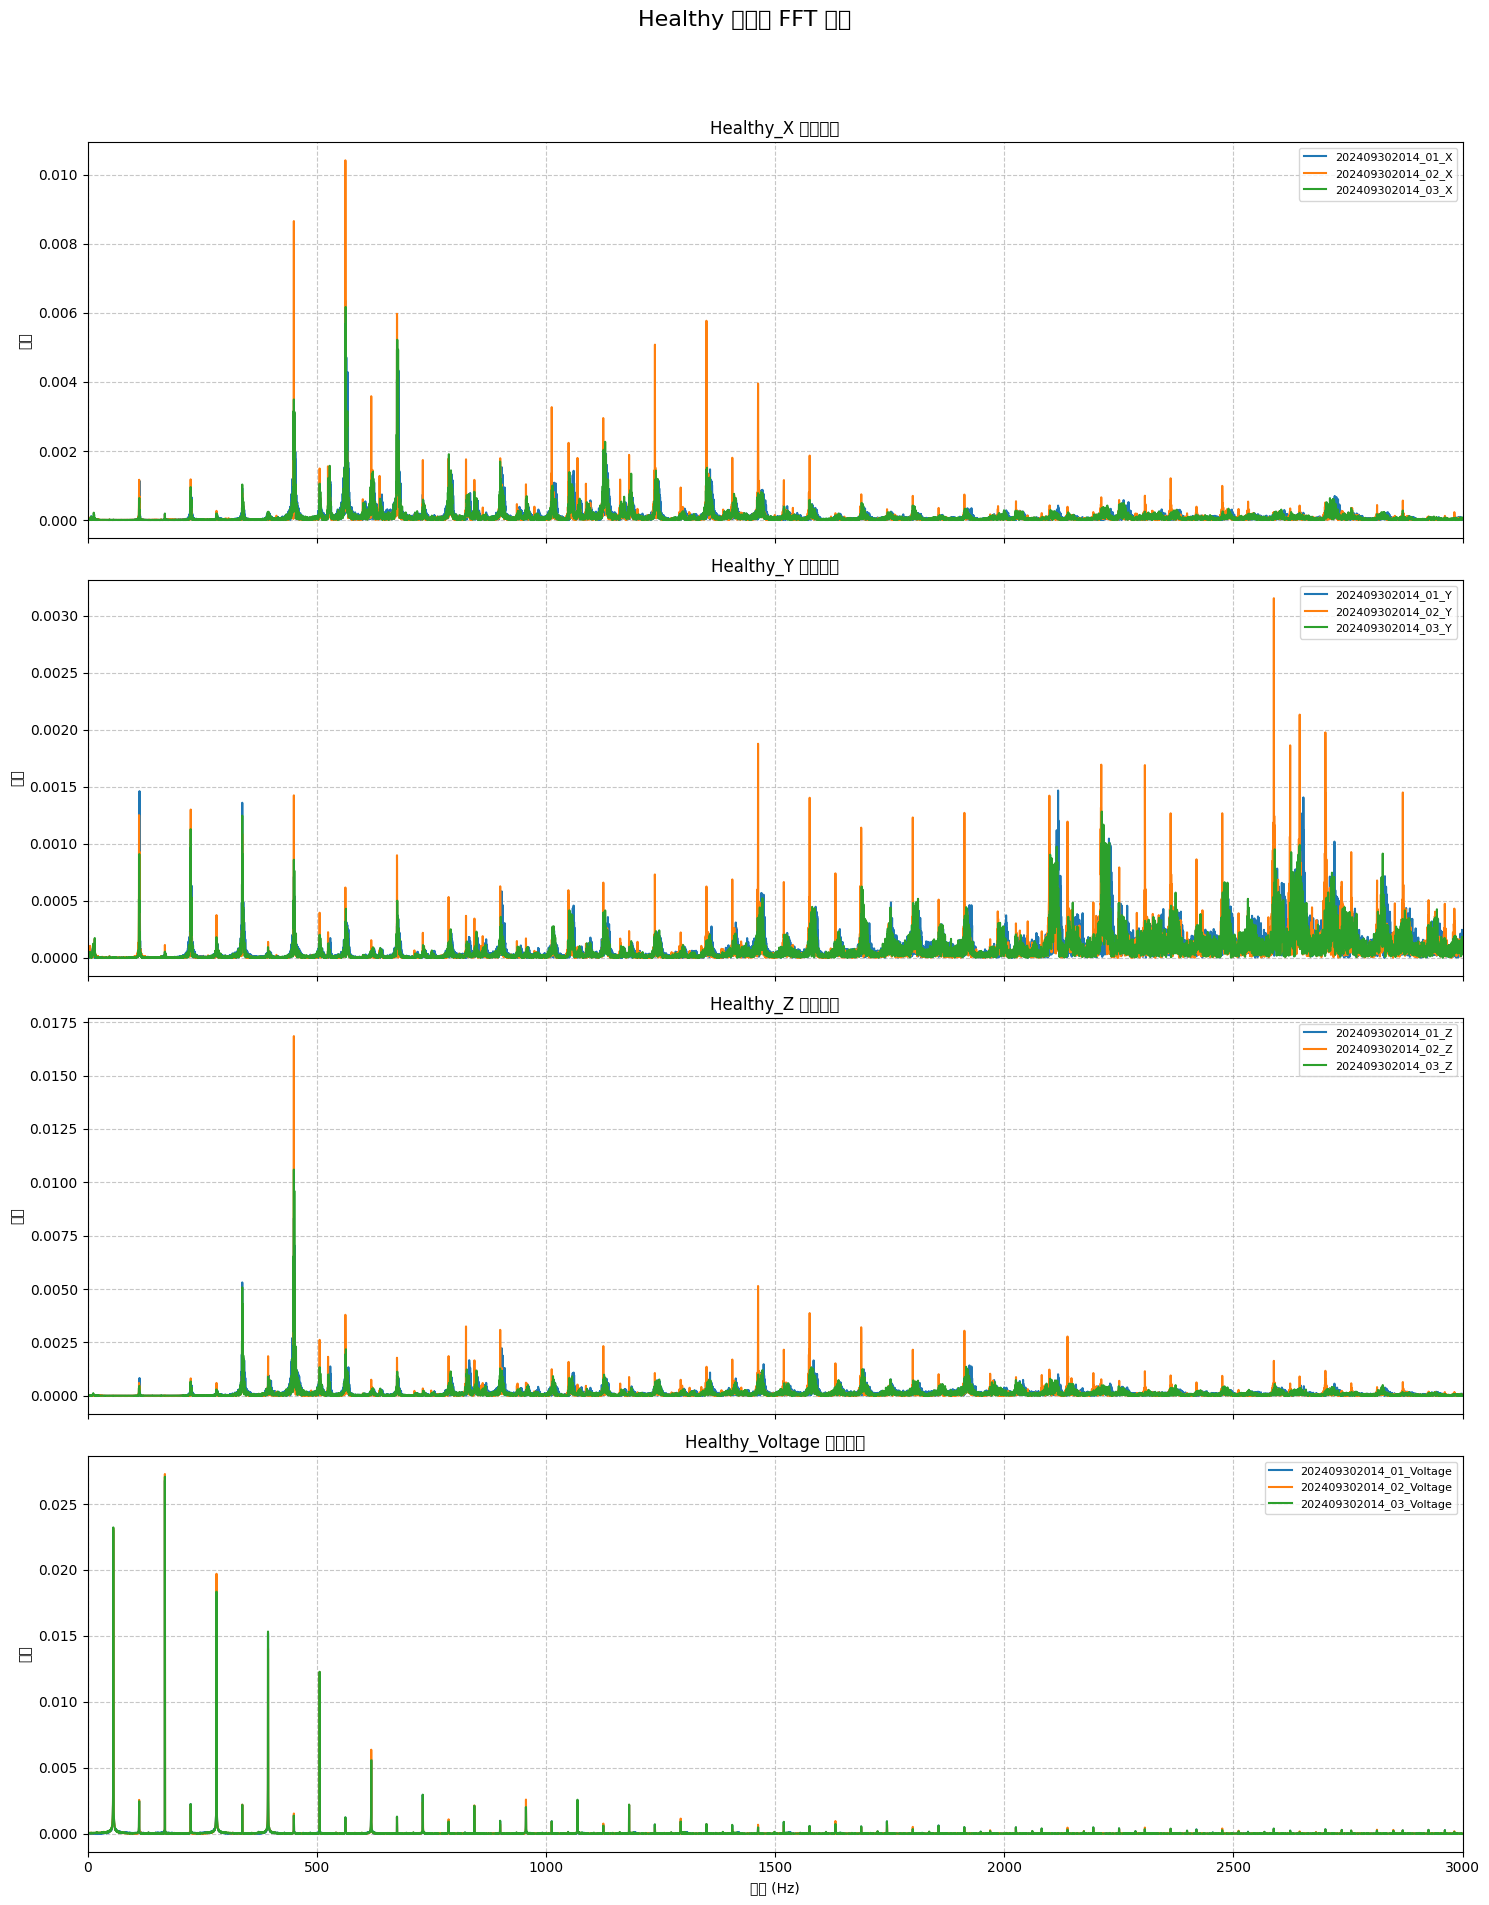

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm

# Configure Matplotlib to display Chinese characters
# You might need to install a CJK font if 'Arial Unicode MS' is not available.
# For Colab, 'SimHei' or 'Arial Unicode MS' are often pre-installed.
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # Set font to support Chinese
plt.rcParams['axes.unicode_minus'] = False # Solve the problem of '-' displaying as a square

# Define sampling parameters, consistent with previous FFT calculation
Fs = 6000  # Sampling frequency (Hz)
N = 30000  # Number of sampling points

# Create the frequency axis (same for all FFTs)
x_freq = np.fft.fftfreq(N, 1/Fs)[:N//2]

output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'

data_types = {
    'Healthy_X': 'Healthy_X_FFT_Df.csv',
    'Healthy_Y': 'Healthy_Y_FFT_Df.csv',
    'Healthy_Z': 'Healthy_Z_FFT_Df.csv',
    'Healthy_Voltage': 'Healthy_Voltage_FFT_Df.csv'
}

# Plotting loop for each data type
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 20), sharex=True)
fig.suptitle('Healthy 數據的 FFT 頻譜', fontsize=16, y=0.98)

for i, (df_name, file_name) in enumerate(data_types.items()):
    file_path = os.path.join(output_dir, file_name)

    if os.path.exists(file_path):
        fft_df = pd.read_csv(file_path)

        ax = axes[i]
        # Plot the first 3 columns from each FFT DataFrame for visualization
        # This prevents overcrowding the plot if there are many columns
        num_cols_to_plot = min(3, fft_df.shape[1])
        for j in range(num_cols_to_plot):
            column_to_plot = fft_df.columns[j]
            ax.plot(x_freq, fft_df[column_to_plot], label=column_to_plot.replace('_FFT_Magnitude', ''))

        ax.set_title(f'{df_name} 頻譜振幅', fontsize=12)
        ax.set_ylabel('振幅', fontsize=10)
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(0, Fs/2) # Limit x-axis to Nyquist frequency
    else:
        print(f"錯誤：檔案 {file_path} 不存在。請確認 FFT 步驟已成功執行。\n")
        axes[i].set_title(f'{df_name} 頻譜振幅 (檔案未找到)', fontsize=12)
        axes[i].set_ylabel('振幅', fontsize=10)
        axes[i].text(0.5, 0.5, '數據不可用', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, fontsize=14, color='red')

axes[-1].set_xlabel('頻率 (Hz)', fontsize=10) # Set xlabel only for the bottom plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
plt.show()


####Healthy_FFT_Feature_x1~x5

In [ ]:
import numpy as np
import pandas as pd
import os

# Define sampling parameters, consistent with previous FFT calculation
Fs = 6000  # Sampling frequency (Hz)
N = 30000  # Number of sampling points

# Create the frequency axis (same for all FFTs)
x_freq = np.fft.fftfreq(N, 1/Fs)[:N//2]

# The calculate_fft_features function is no longer needed based on user's last request,
# but it's kept here for context if other parts of the notebook rely on its definition.
# However, the calls to this function will be removed.
def calculate_fft_features(fft_df, df_name, freq_axis, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    """Calculates FFTx1-FFTx5 features for each column of an FFT DataFrame."""
    print(f"\n正在為 {df_name} 計算 FFT 特徵 (FFTx1-FFTx5)...")
    features_list = []

    if fft_df.empty:
        print(f"警告: {df_name} FFT DataFrame 為空，跳過特徵計算。")
        return pd.DataFrame()

    for col in fft_df.columns:
        amplitudes = fft_df[col].values

        # Ensure no division by zero for spectral centroid/spread
        total_amplitude = np.sum(amplitudes)
        if total_amplitude == 0:
            # Handle cases where all amplitudes are zero (e.g., a constant signal's FFT without DC component)
            spectral_centroid = 0
            spectral_spread = 0
        else:
            # FFTx4 (Spectral Centroid): Weighted average of frequencies
            spectral_centroid = np.sum(amplitudes * freq_axis) / total_amplitude

            # FFTx5 (Spectral Spread): Standard deviation around the spectral centroid
            # Using (freq - centroid)^2 * amplitude / total_amplitude
            spectral_spread = np.sqrt(np.sum(amplitudes * (freq_axis - spectral_centroid)**2) / total_amplitude)

        features_list.append({
            'Column': col.replace('_FFT_Magnitude', ''), # Clean column name
            'FFTx1_Max_Amplitude': np.max(amplitudes),
            'FFTx2_Mean_Amplitude': np.mean(amplitudes),
            'FFTx3_Std_Amplitude': np.std(amplitudes),
            'FFTx4_Spectral_Centroid': spectral_centroid,
            'FFTx5_Spectral_Spread': spectral_spread
        })

    features_df = pd.DataFrame(features_list)
    features_df = features_df.set_index('Column')

    output_file_path = f'{output_dir}{df_name}_FFT_Features_Df.csv'
    features_df.to_csv(output_file_path)

    print(f"已成功為 {df_name} 計算 FFT 特徵並儲存到 {output_file_path}")
    print(f"{df_name}_FFT_Features_Df 的前5行：")
    display(features_df.head())
    print(f"{df_name}_FFT_Features_Df 的維度：")
    print(features_df.shape)
    return features_df

# --- New function to calculate harmonic features (1X, 2X, ..., 5X) ---
def calculate_harmonic_features(fft_df, df_name, freq_axis, base_freq, freq_window, harmonic_orders, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    """Calculates harmonic features (max amplitude around n*base_freq) for each column of an FFT DataFrame."""
    print(f"\n正在為 {df_name} 計算 {len(harmonic_orders)} 個諧波特徵 (基頻 {base_freq} Hz)...")
    harmonic_features_list = []

    if fft_df.empty:
        print(f"警告: {df_name} FFT DataFrame 為空，跳過諧波特徵計算。")
        return pd.DataFrame()

    for col in fft_df.columns:
        column_features = {'Column': col.replace('_FFT_Magnitude', '')}
        amplitudes = fft_df[col].values

        for n in harmonic_orders:
            target_freq = base_freq * n
            lower_bound = target_freq - freq_window
            upper_bound = target_freq + freq_window

            # Find frequency indices within the window
            freq_indices = np.where((freq_axis >= lower_bound) & (freq_axis <= upper_bound))[0]

            max_harmonic_amplitude = np.nan
            if len(freq_indices) > 0:
                # Ensure indices are within bounds of amplitudes array
                valid_indices = freq_indices[(freq_indices >= 0) & (freq_indices < len(amplitudes))]
                if len(valid_indices) > 0:
                    max_harmonic_amplitude = np.max(amplitudes[valid_indices])
                else:
                    print(f"警告: 在 {df_name} 的欄位 {col} 中，諧波 {n}X 的頻率範圍 [{lower_bound:.2f}, {upper_bound:.2f}] Hz 內沒有找到有效的振幅資料。")
            else:
                print(f"警告: 在 {df_name} 的欄位 {col} 中，諧波 {n}X 的頻率範圍 [{lower_bound:.2f}, {upper_bound:.2f}] Hz 內沒有找到頻率點。")

            column_features[f'FFT_{n}X_Amplitude_{target_freq:.0f}Hz'] = max_harmonic_amplitude

        harmonic_features_list.append(column_features)

    harmonic_features_df = pd.DataFrame(harmonic_features_list)
    harmonic_features_df = harmonic_features_df.set_index('Column')

    output_file_path = f'{output_dir}{df_name}_Harmonic_Features_Df.csv'
    harmonic_features_df.to_csv(output_file_path)

    print(f"已成功為 {df_name} 計算諧波特徵並儲存到 {output_file_path}")
    print(f"{df_name}_Harmonic_Features_Df 的前5行：")
    display(harmonic_features_df.head())
    print(f"{df_name}_Harmonic_Features_Df 的維度：")
    print(harmonic_features_df.shape)
    return harmonic_features_df

# --- Load Healthy FFT DataFrames and calculate FFTx1-FFTx5 features ---
# These lines are commented out as per user's request to exclude FFTx1-FFTx5 features.
# healthy_X_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_X_FFT_Df.csv'
# Healthy_X_FFT_Df = pd.read_csv(healthy_X_fft_path)
# Healthy_X_FFT_Features_Df = calculate_fft_features(Healthy_X_FFT_Df, 'Healthy_X', x_freq)

# healthy_Y_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Y_FFT_Df.csv'
# Healthy_Y_FFT_Df = pd.read_csv(healthy_Y_fft_path)
# Healthy_Y_FFT_Features_Df = calculate_fft_features(Healthy_Y_FFT_Df, 'Healthy_Y', x_freq)

# healthy_Z_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Z_FFT_Df.csv'
# Healthy_Z_FFT_Df = pd.read_csv(healthy_Z_fft_path)
# Healthy_Z_FFT_Features_Df = calculate_fft_features(Healthy_Z_FFT_Df, 'Healthy_Z', x_freq)

# healthy_voltage_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Voltage_FFT_Df.csv'
# Healthy_Voltage_FFT_Df = pd.read_csv(healthy_voltage_fft_path)
# Healthy_Voltage_FFT_Features_Df = calculate_fft_features(Healthy_Voltage_FFT_Df, 'Healthy_Voltage', x_freq)

# --- Calculate Harmonic Features (1X, 2X, ..., 5X) for Healthy Data (as requested by the user) ---
base_freq = 117.0  # Rotating frequency (approximately 7000 RPM / 60)
freq_window = 1.0  # Frequency window around the harmonic
harmonic_orders = [1, 2, 3, 4, 5]

# Load FFT DataFrames (if not already loaded by a previous relevant step)
healthy_X_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_X_FFT_Df.csv'
Healthy_X_FFT_Df = pd.read_csv(healthy_X_fft_path)
healthy_Y_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Y_FFT_Df.csv'
Healthy_Y_FFT_Df = pd.read_csv(healthy_Y_fft_path)
healthy_Z_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Z_FFT_Df.csv'
Healthy_Z_FFT_Df = pd.read_csv(healthy_Z_fft_path)
healthy_voltage_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Voltage_FFT_Df.csv'
Healthy_Voltage_FFT_Df = pd.read_csv(healthy_voltage_fft_path)

# Healthy X Harmonic Features
Healthy_X_Harmonic_Features_Df = calculate_harmonic_features(Healthy_X_FFT_Df, 'Healthy_X', x_freq, base_freq, freq_window, harmonic_orders)

# Healthy Y Harmonic Features
Healthy_Y_Harmonic_Features_Df = calculate_harmonic_features(Healthy_Y_FFT_Df, 'Healthy_Y', x_freq, base_freq, freq_window, harmonic_orders)

# Healthy Z Harmonic Features
Healthy_Z_Harmonic_Features_Df = calculate_harmonic_features(Healthy_Z_FFT_Df, 'Healthy_Z', x_freq, base_freq, freq_window, harmonic_orders)

# Healthy Voltage Harmonic Features
Healthy_Voltage_Harmonic_Features_Df = calculate_harmonic_features(Healthy_Voltage_FFT_Df, 'Healthy_Voltage', x_freq, base_freq, freq_window, harmonic_orders)



正在為 Healthy_X 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Healthy_X 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_X_Harmonic_Features_Df.csv
Healthy_X_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
202409302014_01_X,0.000042,0.000031,0.000038,0.000129,0.000166
202409302014_02_X,0.000029,0.000022,0.000027,0.000076,0.000076
202409302014_03_X,0.000024,0.000037,0.000038,0.000088,0.000172
202409302014_04_X,0.000032,0.000019,0.000018,0.000110,0.000085
202409302014_05_X,0.000034,0.000031,0.000024,0.000090,0.000079


Healthy_X_Harmonic_Features_Df 的維度：
(48, 5)

正在為 Healthy_Y 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Healthy_Y 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Y_Harmonic_Features_Df.csv
Healthy_Y_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
202409302014_01_Y,0.000048,0.000055,0.000034,0.000030,0.000014
202409302014_02_Y,0.000045,0.000019,0.000017,0.000021,0.000007
202409302014_03_Y,0.000036,0.000037,0.000026,0.000022,0.000010
202409302014_04_Y,0.000039,0.000030,0.000017,0.000027,0.000007
202409302014_05_Y,0.000047,0.000030,0.000022,0.000022,0.000007


Healthy_Y_Harmonic_Features_Df 的維度：
(48, 5)

正在為 Healthy_Z 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Healthy_Z 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Z_Harmonic_Features_Df.csv
Healthy_Z_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
202409302014_01_Z,0.000030,0.000043,0.000199,0.000337,0.000056
202409302014_02_Z,0.000026,0.000016,0.000105,0.000218,0.000040
202409302014_03_Z,0.000023,0.000043,0.000154,0.000259,0.000047
202409302014_04_Z,0.000028,0.000027,0.000105,0.000246,0.000030
202409302014_05_Z,0.000029,0.000029,0.000124,0.000234,0.000025


Healthy_Z_Harmonic_Features_Df 的維度：
(48, 5)

正在為 Healthy_Voltage 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Healthy_Voltage 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Voltage_Harmonic_Features_Df.csv
Healthy_Voltage_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
202409302014_01_Voltage,0.000095,0.000077,0.000025,0.000049,0.000035
202409302014_02_Voltage,0.000084,0.000022,0.000049,0.000026,0.000021
202409302014_03_Voltage,0.000024,0.000049,0.000058,0.000017,0.000030
202409302014_04_Voltage,0.000062,0.000071,0.000054,0.000018,0.000074
202409302014_05_Voltage,0.000074,0.000035,0.000032,0.000033,0.000073


Healthy_Voltage_Harmonic_Features_Df 的維度：
(48, 5)


####Load_Healthy_Data，X、Y、Z、V



In [ ]:
import pandas as pd

# Define the file path for Healthy X data
healthy_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_X.csv'

# Load Healthy X data into DataFrame
Healthy_X_df = pd.read_csv(healthy_X_path)

print("Healthy X data loaded successfully.")
print(f"Healthy_X_df shape: {Healthy_X_df.shape}")

# Display head of the DataFrame for verification
print("\nHealthy_X_df head:")
display(Healthy_X_df.head())


# Define the file path for Healthy Y data
healthy_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Y.csv'

# Load Healthy Y data into DataFrame
Healthy_Y_df = pd.read_csv(healthy_Y_path)

print("Healthy Y data loaded successfully.")
print(f"Healthy_Y_df shape: {Healthy_Y_df.shape}")

# Display head of the DataFrame for verification
print("\nHealthy_Y_df head:")
display(Healthy_Y_df.head())


# Define the file path for Healthy Z data
healthy_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Z.csv'

# Load Healthy Z data into DataFrame
Healthy_Z_df = pd.read_csv(healthy_Z_path)

print("Healthy Z data loaded successfully.")
print(f"Healthy_Z_df shape: {Healthy_Z_df.shape}")

# Display head of the DataFrame for verification
print("\nHealthy_Z_df head:")
display(Healthy_Z_df.head())


# Define the file path for Healthy Voltage data
healthy_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Voltage.csv'

# Load Healthy Voltage data into DataFrame
Healthy_Voltage_df = pd.read_csv(healthy_voltage_path)

print("Healthy Voltage data loaded successfully.")
print(f"Healthy_Voltage_df shape: {Healthy_Voltage_df.shape}")

# Display head of the DataFrame for verification
print("\nHealthy_Voltage_df head:")
display(Healthy_Voltage_df.head())

Healthy X data loaded successfully.
Healthy_X_df shape: (30000, 48)

Healthy_X_df head:


,202409302014_01_X,202409302014_02_X,202409302014_03_X,202409302014_04_X,202409302014_05_X,202409302014_06_X,202409302014_07_X,202409302014_08_X,202409302014_09_X,202409302014_10_X,...,202409302014_39_X,202409302014_40_X,202409302014_41_X,202409302014_42_X,202409302014_43_X,202409302014_44_X,202409302014_45_X,202409302014_46_X,202409302014_47_X,202409302014_48_X
0,0.053857,0.006437,-0.012931,-0.025556,-0.011177,-0.029158,0.024948,-0.018021,-0.018625,0.004698,...,-0.018339,-0.018820,-0.003166,0.019873,0.027487,-0.029371,-0.003316,0.017632,-0.011159,-0.004920
1,0.032555,0.007665,0.011685,0.016332,-0.015793,-0.051850,0.021355,-0.006662,-0.032508,0.015592,...,-0.003302,-0.007441,-0.001389,0.000500,0.005066,-0.009990,-0.029379,0.000773,-0.005031,-0.018377
2,0.004798,-0.000910,0.023469,-0.021005,-0.021959,-0.028541,-0.020189,0.013649,-0.025893,0.017264,...,0.015708,-0.007477,-0.000003,-0.011413,0.006435,0.012263,-0.014929,-0.011990,0.006876,-0.030491
3,-0.019530,-0.007906,-0.002403,-0.030216,-0.002180,0.002617,-0.017600,0.020219,-0.029153,0.020154,...,-0.009273,-0.001912,-0.042673,0.000390,-0.014527,0.027033,0.008128,-0.028621,0.003613,-0.006652
4,-0.004428,0.003494,-0.023142,-0.033537,0.027174,0.025222,-0.006737,0.023051,-0.017705,0.027609,...,-0.020363,-0.010665,-0.037857,-0.003853,-0.016170,0.007323,0.038054,-0.014440,-0.015312,-0.007826


Healthy Y data loaded successfully.
Healthy_Y_df shape: (30000, 48)

Healthy_Y_df head:


,202409302014_01_Y,202409302014_02_Y,202409302014_03_Y,202409302014_04_Y,202409302014_05_Y,202409302014_06_Y,202409302014_07_Y,202409302014_08_Y,202409302014_09_Y,202409302014_10_Y,...,202409302014_39_Y,202409302014_40_Y,202409302014_41_Y,202409302014_42_Y,202409302014_43_Y,202409302014_44_Y,202409302014_45_Y,202409302014_46_Y,202409302014_47_Y,202409302014_48_Y
0,-0.002894,-0.004312,-0.011205,0.024770,-0.010585,0.000614,-0.027185,-0.000935,-0.002478,0.000275,...,0.008688,0.005982,0.005052,-0.004410,0.001664,0.007815,0.008863,-0.007857,-0.003550,0.001650
1,0.021578,-0.000951,-0.014247,-0.014703,0.012219,0.005388,0.001165,0.001867,0.004408,-0.000605,...,-0.010150,-0.014644,-0.011374,-0.006841,-0.003627,-0.009778,0.004480,0.007836,-0.002543,0.011825
2,-0.005554,0.006552,0.006519,-0.000202,-0.000700,-0.012702,0.000919,0.004049,-0.013674,-0.012211,...,-0.005519,0.009958,-0.007293,0.017396,0.014062,0.004035,-0.011019,0.003176,-0.010037,-0.002721
3,-0.003355,-0.002169,-0.005241,0.010603,0.010801,0.011321,0.002413,0.002618,0.029849,0.006951,...,0.008006,-0.018713,0.013689,-0.008422,-0.006005,-0.001340,0.011972,-0.004823,0.016302,-0.009393
4,0.011777,0.001144,0.003632,-0.004009,-0.012506,-0.005229,0.008167,0.012546,-0.000563,0.000208,...,0.007021,0.014715,-0.022791,0.002571,-0.002750,0.006886,-0.010893,0.014043,0.002032,0.016253


Healthy Z data loaded successfully.
Healthy_Z_df shape: (30000, 48)

Healthy_Z_df head:


,202409302014_01_Z,202409302014_02_Z,202409302014_03_Z,202409302014_04_Z,202409302014_05_Z,202409302014_06_Z,202409302014_07_Z,202409302014_08_Z,202409302014_09_Z,202409302014_10_Z,...,202409302014_39_Z,202409302014_40_Z,202409302014_41_Z,202409302014_42_Z,202409302014_43_Z,202409302014_44_Z,202409302014_45_Z,202409302014_46_Z,202409302014_47_Z,202409302014_48_Z
0,0.013345,0.003345,0.003829,-0.048036,-0.026550,0.015228,0.026216,-0.020087,-0.032981,0.018236,...,-0.002510,0.009054,0.015708,0.027127,-0.006457,0.023385,-0.001121,0.002889,-0.000820,0.038968
1,0.003450,0.006284,0.014974,0.032561,-0.016355,-0.016486,0.019179,-0.003899,-0.011097,0.022300,...,0.002003,-0.008228,0.017966,0.005423,-0.011654,0.004116,0.013188,-0.026541,-0.000855,-0.002716
2,0.051723,0.000462,0.020205,0.032954,-0.005006,-0.016084,-0.019832,0.018903,-0.018632,0.029334,...,0.002459,0.013595,0.005454,-0.012149,-0.023608,0.001486,-0.000091,-0.006522,-0.015640,0.011876
3,0.032483,-0.000201,0.000005,-0.000027,-0.006965,-0.000024,0.007128,-0.051073,-0.017765,0.007636,...,-0.010782,0.021372,-0.001974,0.006876,-0.004072,-0.014846,-0.004211,0.004182,-0.015516,0.006634
4,0.012203,-0.019746,-0.020544,0.018118,0.016459,0.005282,-0.001425,-0.062373,0.002561,0.010360,...,-0.012664,-0.007395,-0.002924,0.010913,0.027391,-0.017599,0.006283,-0.014849,-0.001844,-0.007916


Healthy Voltage data loaded successfully.
Healthy_Voltage_df shape: (30000, 48)

Healthy_Voltage_df head:


,202409302014_01_Voltage,202409302014_02_Voltage,202409302014_03_Voltage,202409302014_04_Voltage,202409302014_05_Voltage,202409302014_06_Voltage,202409302014_07_Voltage,202409302014_08_Voltage,202409302014_09_Voltage,202409302014_10_Voltage,...,202409302014_39_Voltage,202409302014_40_Voltage,202409302014_41_Voltage,202409302014_42_Voltage,202409302014_43_Voltage,202409302014_44_Voltage,202409302014_45_Voltage,202409302014_46_Voltage,202409302014_47_Voltage,202409302014_48_Voltage
0,0.000443,0.000124,0.000761,0.002672,0.000443,0.001080,0.002354,0.000443,-0.057536,0.001080,...,-0.021220,0.000761,0.000761,0.003310,0.000761,-0.078242,0.001398,-0.000513,0.002672,0.025290
1,0.002672,0.001398,0.001080,0.002991,0.046953,0.001398,0.002991,0.000124,-0.037785,0.029113,...,0.003310,0.001398,0.001398,0.003628,0.000124,-0.100860,0.001398,0.000124,0.002672,-0.000513
2,0.002672,0.001080,0.001398,0.003628,0.092188,0.001398,0.002991,0.000124,-0.015167,0.082632,...,0.002672,0.001080,0.000761,0.002991,0.000443,-0.106276,0.002035,0.000761,0.002672,0.000761
3,0.002991,0.001080,0.001080,0.002991,0.114488,0.002672,0.003310,-0.000195,0.002991,0.110665,...,0.002991,0.002672,0.002035,0.002672,0.000443,-0.102453,0.000761,0.001080,0.002991,0.000443
4,0.002991,0.000761,0.001080,0.003310,0.125637,0.002035,0.002672,-0.000832,0.002672,0.120859,...,0.002672,0.071163,0.001398,0.003628,0.000124,-0.090029,0.001080,0.002354,0.003947,0.001398


####Healthy_X_Y_Z_V__Features_df

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import math
import os

# Define the calculate_statistical_features function (redefined for robustness if not in global scope)
def calculate_statistical_features(df, df_name, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    print(f"\n正在為 {df_name} 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...")
    features_list = []

    if df.empty:
        print(f"警告: {df_name} 為空，跳過統計特徵計算。")
        return pd.DataFrame()

    for col in df.columns:
        data = df[col]

        # Calculate features
        col_mean = data.mean()
        col_std = data.std()
        col_rms = math.sqrt(data.pow(2).mean()) # RMS = sqrt(mean of squares)
        col_kurtosis = kurtosis(data)
        col_skewness = skew(data)

        features_list.append({
            'Column': col,
            'RMS': col_rms,
            'Mean': col_mean,
            'Kurtosis': col_kurtosis,
            'Std': col_std,
            'Skewness': col_skewness
        })

    features_df = pd.DataFrame(features_list)
    features_df = features_df.set_index('Column')

    desired_column_order = ['RMS', 'Mean', 'Kurtosis', 'Std', 'Skewness']
    features_df = features_df[desired_column_order]

    output_file_path = f'{output_dir}{df_name}_Features_df.csv'
    features_df.to_csv(output_file_path)

    print(f"已成功為 {df_name} 計算統計特徵並儲存到 {output_file_path}")
    print(f"{df_name}_Features_df 的前5行：")
    display(features_df.head())
    print(f"{df_name}_Features_df 的維度：")
    print(features_df.shape)
    return features_df

# Define file paths for Healthy data (raw merged clean tables)
healthy_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_X.csv'
healthy_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Y.csv'
healthy_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Z.csv'
healthy_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Merge_Clean_Table_Voltage.csv'

output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'
os.makedirs(output_dir, exist_ok=True)

print("--- 計算 Healthy 各維度統計特徵 ---")

# --- Process Healthy X data ---
Healthy_X_df = pd.read_csv(healthy_X_path)
Healthy_X_Features_df = calculate_statistical_features(Healthy_X_df, 'Healthy_X')

# --- Process Healthy Y data ---
Healthy_Y_df = pd.read_csv(healthy_Y_path)
Healthy_Y_Features_df = calculate_statistical_features(Healthy_Y_df, 'Healthy_Y')

# --- Process Healthy Z data ---
Healthy_Z_df = pd.read_csv(healthy_Z_path)
Healthy_Z_Features_df = calculate_statistical_features(Healthy_Z_df, 'Healthy_Z')

# --- Process Healthy Voltage data ---
Healthy_Voltage_df = pd.read_csv(healthy_voltage_path)
Healthy_Voltage_Features_df = calculate_statistical_features(Healthy_Voltage_df, 'Healthy_Voltage')

print("\n所有 Healthy 數據的統計特徵計算和儲存已完成。")

--- 計算 Healthy 各維度統計特徵 ---

正在為 Healthy_X 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Healthy_X 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_X_Features_df.csv
Healthy_X_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
202409302014_01_X,0.020941,0.000187,0.552959,0.020941,-0.031832
202409302014_02_X,0.023462,0.000175,0.111741,0.023461,-0.069489
202409302014_03_X,0.021899,0.000155,0.371541,0.021899,-0.007324
202409302014_04_X,0.023782,0.000138,0.376164,0.023782,-0.037927
202409302014_05_X,0.021763,0.000130,0.458398,0.021763,-0.079878


Healthy_X_Features_df 的維度：
(48, 5)

正在為 Healthy_Y 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Healthy_Y 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Y_Features_df.csv
Healthy_Y_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
202409302014_01_Y,0.011834,0.000059,0.284032,0.011834,-0.003254
202409302014_02_Y,0.013012,0.000034,0.310488,0.013012,-0.163291
202409302014_03_Y,0.011821,-0.000009,0.317472,0.011821,0.008843
202409302014_04_Y,0.011471,-0.000016,0.183106,0.011471,-0.000790
202409302014_05_Y,0.011831,-0.000060,0.276334,0.011831,-0.014345


Healthy_Y_Features_df 的維度：
(48, 5)

正在為 Healthy_Z 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Healthy_Z 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Z_Features_df.csv
Healthy_Z_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
202409302014_01_Z,0.022997,0.000185,0.172243,0.022997,0.154200
202409302014_02_Z,0.024697,0.000206,-0.184833,0.024697,0.191874
202409302014_03_Z,0.023507,0.000199,-0.029275,0.023507,0.080512
202409302014_04_Z,0.025484,0.000186,-0.407115,0.025484,0.123459
202409302014_05_Z,0.024129,0.000168,-0.113278,0.024129,0.067075


Healthy_Z_Features_df 的維度：
(48, 5)

正在為 Healthy_Voltage 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Healthy_Voltage 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Voltage_Features_df.csv
Healthy_Voltage_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
202409302014_01_Voltage,0.036212,0.003285,4.622796,0.036063,0.534536
202409302014_02_Voltage,0.036750,0.003321,4.559385,0.036600,0.516488
202409302014_03_Voltage,0.036528,0.003265,4.583190,0.036383,0.525748
202409302014_04_Voltage,0.036885,0.003307,4.562791,0.036737,0.522942
202409302014_05_Voltage,0.036570,0.003276,4.575264,0.036424,0.530866


Healthy_Voltage_Features_df 的維度：
(48, 5)

所有 Healthy 數據的統計特徵計算和儲存已完成。


In [ ]:
import pandas as pd
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive') # 確保 Google Drive 已掛載

# --- 步驟 1: 定義檔案路徑 ---
faulty_file_paths = {
    'X_Axis': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_X_Combined_Features_Df.csv',
    'Y_Axis': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Y_Combined_Features_Df.csv',
    'Z_Axis': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Z_Combined_Features_Df.csv',
    'Voltage': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Voltage_Combined_Features_Df.csv'
}

# --- 步驟 2: 載入數據並加上前綴 (Prefix) 進行水平合併 ---

final_merged_df = None

print("--- 開始處理與水平合併 Faulty 檔案 (刪除多餘軸向欄位) ---")
for axis_name, path in faulty_file_paths.items():
    try:
        df = pd.read_csv(path)

        # 🚨 關鍵修正：檢查並刪除多餘的 'Source_Axis' 欄位
        if 'Source_Axis' in df.columns:
            df.drop('Source_Axis', axis=1, inplace=True)
            print(f"在 {axis_name} 數據中，已刪除 'Source_Axis' 欄位。")

        # 關鍵步驟：為每個特徵欄位加上軸向/來源的前綴
        new_columns = {col: f'{axis_name}_{col}' for col in df.columns}
        df.rename(columns=new_columns, inplace=True)

        print(f"成功載入 {axis_name} 數據，維度: {df.shape}")

        # 進行水平合併
        if final_merged_df is None:
            final_merged_df = df
        else:
            final_merged_df = pd.concat([final_merged_df, df], axis=1)

    except FileNotFoundError:
        print(f"錯誤：找不到檔案路徑: {path}")

# 最終合併後的 DataFrame
faulty_combined_df_wide = final_merged_df

# --- 步驟 3: 檢查最終結果 ---
print("\n--- 水平合併結果驗證 (Faulty Data) ---")

# 假設四個檔案都是 48x10，最終應為 (48, 40)
actual_features = len(faulty_combined_df_wide.columns)

print(f"最終數據集維度: {faulty_combined_df_wide.shape}")
print(f"✅ 最終特徵總數: {actual_features} 欄。")

# 打印前 5 列
print("\n最終水平合併 Faulty 數據 (前 5 筆):")
print(faulty_combined_df_wide.head())

--- 開始處理與水平合併 Faulty 檔案 (刪除多餘軸向欄位) ---
成功載入 X_Axis 數據，維度: (48, 11)
成功載入 Y_Axis 數據，維度: (48, 11)
成功載入 Z_Axis 數據，維度: (48, 11)
成功載入 Voltage 數據，維度: (48, 11)

--- 水平合併結果驗證 (Faulty Data) ---
最終數據集維度: (48, 44)
✅ 最終特徵總數: 44 欄。

最終水平合併 Faulty 數據 (前 5 筆):
       X_Axis_Column  X_Axis_RMS  X_Axis_Mean  X_Axis_Kurtosis  X_Axis_Std  \
0  202409302025_01_X    0.023724     0.000137         0.587321    0.023724   
1  202409302025_02_X    0.022344     0.000169         1.406470    0.022343   
2  202409302025_03_X    0.023776     0.000143         1.327990    0.023776   
3  202409302025_04_X    0.024480     0.000129         1.213258    0.024480   
4  202409302025_05_X    0.026405     0.000151         1.488870    0.026405   

   X_Axis_Skewness  X_Axis_FFT_1X_Amplitude_117Hz  \
0        -0.229660                       0.000062   
1        -0.524710                       0.000047   
2        -0.464774                       0.000043   
3        -0.387796                       0.000033   
4        -0.191874   

####Healthy_合併Feature和FFT_Feature

In [ ]:
import pandas as pd
import os

output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'
os.makedirs(output_dir, exist_ok=True)

dimensions = ['X', 'Y', 'Z', 'Voltage']

# Dictionary to store combined feature dataframes for each dimension
Healthy_Combined_Features_Dict = {}

for dim in dimensions:
    print(f"\n--- 正在組合 Healthy {dim} 數據的統計特徵和諧波特徵 ---")

    # Define file paths for Statistical features and Harmonic features
    statistical_features_path = os.path.join(output_dir, f'Healthy_{dim}_Features_df.csv')
    harmonic_features_path = os.path.join(output_dir, f'Healthy_{dim}_Harmonic_Features_Df.csv')

    # Load the feature DataFrames
    try:
        statistical_features_df = pd.read_csv(statistical_features_path, index_col='Column')
        harmonic_features_df = pd.read_csv(harmonic_features_path, index_col='Column')
    except FileNotFoundError as e:
        print(f"錯誤: 找不到文件 {e.filename}。請確認所有統計特徵和諧波特徵已成功生成並儲存。")
        continue
    except Exception as e:
        print(f"載入文件時發生未知錯誤: {e}")
        continue

    # Combine the two feature DataFrames horizontally
    # Ensure both DataFrames have the same index for proper alignment
    if not statistical_features_df.index.equals(harmonic_features_df.index):
        print(f"警告: Healthy {dim} 的統計特徵和諧波特徵的索引不匹配。嘗試按索引合併。")
        # Use outer join to keep all indices and fill NaNs if necessary
        combined_features_df = pd.merge(
            statistical_features_df,
            harmonic_features_df,
            left_index=True,
            right_index=True,
            how='outer'
        )
    else:
        combined_features_df = pd.concat([statistical_features_df, harmonic_features_df], axis=1)

    # Store the combined DataFrame in the dictionary
    Healthy_Combined_Features_Dict[dim] = combined_features_df

    # Assign a name to the combined DataFrame in global scope for potential future use
    # This part is removed as the user requested to not combine into a single Healthy_All_Features_Df
    df_name = f'Healthy_{dim}_Combined_Features_Df'
    globals()[df_name] = combined_features_df

    # Save the combined DataFrame to a CSV file
    output_file_name = f'{df_name}.csv'
    output_file_path = os.path.join(output_dir, output_file_name)
    combined_features_df.to_csv(output_file_path, index=True) # Keep the 'Column' as index in CSV

    print(f"已成功組合並儲存 Healthy {dim} 的特徵至 {output_file_path}")
    print(f"{df_name} 的形狀: {combined_features_df.shape}")
    print(f"{df_name} 的前5行:")
    display(combined_features_df.head())

print("\n所有 Healthy 數據的特徵組合和儲存已完成。")



--- 正在組合 Healthy X 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Healthy X 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_X_Combined_Features_Df.csv
Healthy_X_Combined_Features_Df 的形狀: (48, 10)
Healthy_X_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
202409302014_01_X,0.020941,0.000187,0.552959,0.020941,-0.031832,0.000042,0.000031,0.000038,0.000129,0.000166
202409302014_02_X,0.023462,0.000175,0.111741,0.023461,-0.069489,0.000029,0.000022,0.000027,0.000076,0.000076
202409302014_03_X,0.021899,0.000155,0.371541,0.021899,-0.007324,0.000024,0.000037,0.000038,0.000088,0.000172
202409302014_04_X,0.023782,0.000138,0.376164,0.023782,-0.037927,0.000032,0.000019,0.000018,0.000110,0.000085
202409302014_05_X,0.021763,0.000130,0.458398,0.021763,-0.079878,0.000034,0.000031,0.000024,0.000090,0.000079



--- 正在組合 Healthy Y 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Healthy Y 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Y_Combined_Features_Df.csv
Healthy_Y_Combined_Features_Df 的形狀: (48, 10)
Healthy_Y_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
202409302014_01_Y,0.011834,0.000059,0.284032,0.011834,-0.003254,0.000048,0.000055,0.000034,0.000030,0.000014
202409302014_02_Y,0.013012,0.000034,0.310488,0.013012,-0.163291,0.000045,0.000019,0.000017,0.000021,0.000007
202409302014_03_Y,0.011821,-0.000009,0.317472,0.011821,0.008843,0.000036,0.000037,0.000026,0.000022,0.000010
202409302014_04_Y,0.011471,-0.000016,0.183106,0.011471,-0.000790,0.000039,0.000030,0.000017,0.000027,0.000007
202409302014_05_Y,0.011831,-0.000060,0.276334,0.011831,-0.014345,0.000047,0.000030,0.000022,0.000022,0.000007



--- 正在組合 Healthy Z 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Healthy Z 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Z_Combined_Features_Df.csv
Healthy_Z_Combined_Features_Df 的形狀: (48, 10)
Healthy_Z_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
202409302014_01_Z,0.022997,0.000185,0.172243,0.022997,0.154200,0.000030,0.000043,0.000199,0.000337,0.000056
202409302014_02_Z,0.024697,0.000206,-0.184833,0.024697,0.191874,0.000026,0.000016,0.000105,0.000218,0.000040
202409302014_03_Z,0.023507,0.000199,-0.029275,0.023507,0.080512,0.000023,0.000043,0.000154,0.000259,0.000047
202409302014_04_Z,0.025484,0.000186,-0.407115,0.025484,0.123459,0.000028,0.000027,0.000105,0.000246,0.000030
202409302014_05_Z,0.024129,0.000168,-0.113278,0.024129,0.067075,0.000029,0.000029,0.000124,0.000234,0.000025



--- 正在組合 Healthy Voltage 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Healthy Voltage 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Voltage_Combined_Features_Df.csv
Healthy_Voltage_Combined_Features_Df 的形狀: (48, 10)
Healthy_Voltage_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
202409302014_01_Voltage,0.036212,0.003285,4.622796,0.036063,0.534536,0.000095,0.000077,0.000025,0.000049,0.000035
202409302014_02_Voltage,0.036750,0.003321,4.559385,0.036600,0.516488,0.000084,0.000022,0.000049,0.000026,0.000021
202409302014_03_Voltage,0.036528,0.003265,4.583190,0.036383,0.525748,0.000024,0.000049,0.000058,0.000017,0.000030
202409302014_04_Voltage,0.036885,0.003307,4.562791,0.036737,0.522942,0.000062,0.000071,0.000054,0.000018,0.000074
202409302014_05_Voltage,0.036570,0.003276,4.575264,0.036424,0.530866,0.000074,0.000035,0.000032,0.000033,0.000073



所有 Healthy 數據的特徵組合和儲存已完成。


In [ ]:
import pandas as pd
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive') # 確保 Google Drive 已掛載

# --- 步驟 1: 定義檔案路徑 ---
file_paths = {
    'X_Axis': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_X_Combined_Features_Df.csv',
    'Y_Axis': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Y_Combined_Features_Df.csv',
    'Z_Axis': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Z_Combined_Features_Df.csv',
    'Voltage': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Voltage_Combined_Features_Df.csv'
}

# --- 步驟 2: 載入數據並加上前綴 (Prefix) 進行水平合併 ---

final_merged_df = None
AXIS_MARKER_COLUMN_NAME = 'Source_Axis' # 假設這是原始檔案中額外的欄位名稱

print("--- 開始處理與水平合併 Healthy 檔案 ---")
for axis_name, path in file_paths.items():
    try:
        df = pd.read_csv(path)

        # 🚨 關鍵步驟 A: 檢查並刪除原始的 Source_Axis 欄位
        if AXIS_MARKER_COLUMN_NAME in df.columns:
            df.drop(AXIS_MARKER_COLUMN_NAME, axis=1, inplace=True)
            # 這裡我們不打印，因為接下來我們要檢查合併後的表

        # 關鍵步驟 B: 為每個特徵欄位加上軸向/來源的前綴
        new_columns = {col: f'{axis_name}_{col}' for col in df.columns}
        df.rename(columns=new_columns, inplace=True)

        # 進行水平合併 (依賴行索引，axis=1)
        if final_merged_df is None:
            final_merged_df = df
        else:
            final_merged_df = pd.concat([final_merged_df, df], axis=1)

    except FileNotFoundError:
        print(f"錯誤：找不到檔案路徑: {path}")

# 最終合併後的 DataFrame
healthy_combined_df_wide = final_merged_df

# --- 步驟 3: 最終檢查與清理 ---

# 🚨 檢查是否仍有以 '_Source_Axis' 結尾的欄位 (理論上不應該有，但這是最終防護)
columns_to_drop_final = [
    col for col in healthy_combined_df_wide.columns
    if AXIS_MARKER_COLUMN_NAME in col
]

original_cols = healthy_combined_df_wide.shape[1]

print(f"\n--- 最終清理執行 (刪除冗餘軸向標記欄位) ---")
if columns_to_drop_final:
    healthy_combined_df_wide.drop(columns_to_drop_final, axis=1, inplace=True)

    final_cols = healthy_combined_df_wide.shape[1]

    print(f"✅ 成功刪除 {len(columns_to_drop_final)} 個冗餘的軸向標記欄位。")
    print(f"刪除後維度: ({healthy_combined_df_wide.shape[0]}, {final_cols})")
else:
    print("✅ 數據在載入時已清理乾淨，無需額外刪除。")


# --- 步驟 4: 檢查最終結果 ---
print("\n--- 最終結果驗證 ---")
final_cols = healthy_combined_df_wide.shape[1]

print(f"最終數據集維度: ({healthy_combined_df_wide.shape[0]}, {final_cols})")
if healthy_combined_df_wide.shape == (48, 40):
    print("✨ 確認：最終大小為 (48x40)。")
else:
    print(f"⚠️ 警告：最終維度不是 (48, 40)，而是 {healthy_combined_df_wide.shape}，請檢查原始檔案特徵數。")


# 打印前 5 列
print("\n最終水平合併數據 (前 5 筆):")
print(healthy_combined_df_wide.head())

--- 開始處理與水平合併 Healthy 檔案 ---

--- 最終清理執行 (刪除冗餘軸向標記欄位) ---
✅ 數據在載入時已清理乾淨，無需額外刪除。

--- 最終結果驗證 ---
最終數據集維度: (48, 44)
⚠️ 警告：最終維度不是 (48, 40)，而是 (48, 44)，請檢查原始檔案特徵數。

最終水平合併數據 (前 5 筆):
       X_Axis_Column  X_Axis_RMS  X_Axis_Mean  X_Axis_Kurtosis  X_Axis_Std  \
0  202409302014_01_X    0.020941     0.000187         0.552959    0.020941   
1  202409302014_02_X    0.023462     0.000175         0.111741    0.023461   
2  202409302014_03_X    0.021899     0.000155         0.371541    0.021899   
3  202409302014_04_X    0.023782     0.000138         0.376164    0.023782   
4  202409302014_05_X    0.021763     0.000130         0.458398    0.021763   

   X_Axis_Skewness  X_Axis_FFT_1X_Amplitude_117Hz  \
0        -0.031832                       0.000042   
1        -0.069489                       0.000029   
2        -0.007324                       0.000024   
3        -0.037927                       0.000032   
4        -0.079878                       0.000034   

   X_Axis_FFT_2X_Amplitude_234Hz 

###特徵表建立Fauty的特徵rms，mean，kurtosis，std，skewness，X1~X5，共10個欄位

****前5個特徵的值和matlab一樣，第6~第10不一樣，因為套件的運算方式和matlab不同

####Fauty快速傅立葉轉換

In [ ]:
import numpy as np
import pandas as pd
import os

# Define sampling parameters, consistent with previous FFT calculation
Fs = 6000  # Sampling frequency (Hz)
N = 30000  # Number of sampling points

# The perform_fft_and_save function should already be defined in a previous cell.
# If not, it needs to be defined here or run the cell where it's defined.

def perform_fft_and_save(df, df_name, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    """Performs FFT on each column of a DataFrame and saves the magnitudes to a new CSV."""
    print(f"\n正在對 {df_name} 執行 FFT...")
    fft_df = pd.DataFrame()

    if df.empty:
        print(f"警告: {df_name} 為空，跳過 FFT。")
        return pd.DataFrame() # Return an empty DataFrame if input is empty

    for column in df.columns:
        signal = df[column].values

        yf = np.fft.fft(signal, axis=0)

        amplitude = np.abs(yf[0:N//2]) / N * 2
        amplitude[0] = amplitude[0] / 2  # DC component

        fft_df[f'{column}_FFT_Magnitude'] = amplitude

    output_file_path = f'{output_dir}{df_name}_FFT_Df.csv'
    fft_df.to_csv(output_file_path, index=False)

    print(f"已成功對所有 {df_name} 列執行 FFT 並儲存到 {output_file_path}")
    print(f"{df_name}_FFT_Df 的前5行：")
    display(fft_df.head())
    print(f"{df_name}_FFT_Df 的維度：")
    print(fft_df.shape)
    return fft_df

# --- Faulty X data ---
faulty_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_X.csv'
Faulty_X_df = pd.read_csv(faulty_X_path)
Faulty_X_FFT_Df = perform_fft_and_save(Faulty_X_df, 'Faulty_X')

# --- Faulty Y data ---
faulty_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Y.csv'
Faulty_Y_df = pd.read_csv(faulty_Y_path)
Faulty_Y_FFT_Df = perform_fft_and_save(Faulty_Y_df, 'Faulty_Y')

# --- Faulty Z data ---
faulty_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Z.csv'
Faulty_Z_df = pd.read_csv(faulty_Z_path)
Faulty_Z_FFT_Df = perform_fft_and_save(Faulty_Z_df, 'Faulty_Z')

# --- Faulty Voltage data ---
faulty_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Voltage.csv'
Faulty_Voltage_df = pd.read_csv(faulty_voltage_path)
Faulty_Voltage_FFT_Df = perform_fft_and_save(Faulty_Voltage_df, 'Faulty_Voltage')



正在對 Faulty_X 執行 FFT...
已成功對所有 Faulty_X 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_X_FFT_Df.csv
Faulty_X_FFT_Df 的前5行：


,202409302025_01_X_FFT_Magnitude,202409302025_02_X_FFT_Magnitude,202409302025_03_X_FFT_Magnitude,202409302025_04_X_FFT_Magnitude,202409302025_05_X_FFT_Magnitude,202409302025_06_X_FFT_Magnitude,202409302025_07_X_FFT_Magnitude,202409302025_08_X_FFT_Magnitude,202409302025_09_X_FFT_Magnitude,202409302025_10_X_FFT_Magnitude,...,202409302025_39_X_FFT_Magnitude,202409302025_40_X_FFT_Magnitude,202409302025_41_X_FFT_Magnitude,202409302025_42_X_FFT_Magnitude,202409302025_43_X_FFT_Magnitude,202409302025_44_X_FFT_Magnitude,202409302025_45_X_FFT_Magnitude,202409302025_46_X_FFT_Magnitude,202409302025_47_X_FFT_Magnitude,202409302025_48_X_FFT_Magnitude
0,0.000137,0.000169,0.000143,0.000129,0.000151,0.000125,0.000135,0.000133,0.000115,0.000119,...,0.000132,0.000132,0.000118,0.000126,0.000120,0.000124,0.000138,0.000148,0.000145,0.000139
1,0.000018,0.000022,0.000017,0.000011,0.000012,0.000016,0.000047,0.000012,0.000003,0.000009,...,0.000022,0.000008,0.000033,0.000020,0.000014,0.000003,0.000014,0.000037,0.000008,0.000005
2,0.000025,0.000010,0.000019,0.000008,0.000012,0.000016,0.000022,0.000033,0.000010,0.000025,...,0.000002,0.000014,0.000004,0.000007,0.000005,0.000022,0.000030,0.000006,0.000023,0.000008
3,0.000007,0.000010,0.000004,0.000011,0.000006,0.000003,0.000007,0.000007,0.000001,0.000008,...,0.000011,0.000004,0.000005,0.000013,0.000004,0.000006,0.000013,0.000010,0.000003,0.000013
4,0.000006,0.000012,0.000008,0.000003,0.000026,0.000009,0.000012,0.000007,0.000004,0.000021,...,0.000006,0.000012,0.000011,0.000004,0.000011,0.000005,0.000012,0.000008,0.000019,0.000008


Faulty_X_FFT_Df 的維度：
(15000, 48)

正在對 Faulty_Y 執行 FFT...
已成功對所有 Faulty_Y 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Y_FFT_Df.csv
Faulty_Y_FFT_Df 的前5行：


,202409302025_01_Y_FFT_Magnitude,202409302025_02_Y_FFT_Magnitude,202409302025_03_Y_FFT_Magnitude,202409302025_04_Y_FFT_Magnitude,202409302025_05_Y_FFT_Magnitude,202409302025_06_Y_FFT_Magnitude,202409302025_07_Y_FFT_Magnitude,202409302025_08_Y_FFT_Magnitude,202409302025_09_Y_FFT_Magnitude,202409302025_10_Y_FFT_Magnitude,...,202409302025_39_Y_FFT_Magnitude,202409302025_40_Y_FFT_Magnitude,202409302025_41_Y_FFT_Magnitude,202409302025_42_Y_FFT_Magnitude,202409302025_43_Y_FFT_Magnitude,202409302025_44_Y_FFT_Magnitude,202409302025_45_Y_FFT_Magnitude,202409302025_46_Y_FFT_Magnitude,202409302025_47_Y_FFT_Magnitude,202409302025_48_Y_FFT_Magnitude
0,0.000038,0.000041,0.000025,4.615212e-07,0.000035,0.000009,0.000059,0.000064,0.000068,0.000078,...,0.000030,0.000014,0.000056,0.000017,0.000040,0.000039,4.347453e-05,0.000004,0.000065,0.000010
1,0.000053,0.000036,0.000012,3.685267e-05,0.000004,0.000011,0.000042,0.000004,0.000034,0.000025,...,0.000018,0.000024,0.000020,0.000031,0.000015,0.000038,4.430590e-05,0.000044,0.000029,0.000047
2,0.000038,0.000016,0.000022,2.480708e-05,0.000007,0.000011,0.000002,0.000007,0.000021,0.000007,...,0.000002,0.000021,0.000002,0.000024,0.000024,0.000007,1.581360e-05,0.000021,0.000021,0.000030
3,0.000012,0.000009,0.000015,1.919855e-05,0.000006,0.000022,0.000004,0.000014,0.000007,0.000010,...,0.000006,0.000013,0.000006,0.000010,0.000002,0.000008,9.320124e-06,0.000007,0.000013,0.000008
4,0.000008,0.000006,0.000007,9.066671e-06,0.000010,0.000012,0.000009,0.000008,0.000004,0.000003,...,0.000012,0.000005,0.000009,0.000010,0.000004,0.000007,3.105329e-07,0.000007,0.000009,0.000010


Faulty_Y_FFT_Df 的維度：
(15000, 48)

正在對 Faulty_Z 執行 FFT...
已成功對所有 Faulty_Z 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Z_FFT_Df.csv
Faulty_Z_FFT_Df 的前5行：


,202409302025_01_Z_FFT_Magnitude,202409302025_02_Z_FFT_Magnitude,202409302025_03_Z_FFT_Magnitude,202409302025_04_Z_FFT_Magnitude,202409302025_05_Z_FFT_Magnitude,202409302025_06_Z_FFT_Magnitude,202409302025_07_Z_FFT_Magnitude,202409302025_08_Z_FFT_Magnitude,202409302025_09_Z_FFT_Magnitude,202409302025_10_Z_FFT_Magnitude,...,202409302025_39_Z_FFT_Magnitude,202409302025_40_Z_FFT_Magnitude,202409302025_41_Z_FFT_Magnitude,202409302025_42_Z_FFT_Magnitude,202409302025_43_Z_FFT_Magnitude,202409302025_44_Z_FFT_Magnitude,202409302025_45_Z_FFT_Magnitude,202409302025_46_Z_FFT_Magnitude,202409302025_47_Z_FFT_Magnitude,202409302025_48_Z_FFT_Magnitude
0,0.000194,0.000196,0.000190,0.000160,0.000183,0.000203,0.000177,0.000150,0.000164,0.000156,...,0.000181,0.000179,0.000180,0.000172,0.000182,0.000166,0.000181,0.000182,0.000191,0.000179
1,0.000023,0.000008,0.000012,0.000014,0.000011,0.000017,0.000021,0.000024,0.000003,0.000006,...,0.000022,0.000017,0.000007,0.000007,0.000005,0.000008,0.000007,0.000023,0.000016,0.000006
2,0.000013,0.000010,0.000007,0.000021,0.000009,0.000021,0.000009,0.000004,0.000017,0.000001,...,0.000002,0.000006,0.000011,0.000019,0.000024,0.000012,0.000014,0.000007,0.000016,0.000010
3,0.000004,0.000009,0.000009,0.000001,0.000019,0.000011,0.000004,0.000010,0.000003,0.000014,...,0.000007,0.000022,0.000023,0.000006,0.000014,0.000007,0.000006,0.000004,0.000005,0.000012
4,0.000009,0.000004,0.000004,0.000022,0.000009,0.000009,0.000014,0.000013,0.000007,0.000007,...,0.000006,0.000017,0.000003,0.000015,0.000005,0.000022,0.000015,0.000004,0.000002,0.000019


Faulty_Z_FFT_Df 的維度：
(15000, 48)

正在對 Faulty_Voltage 執行 FFT...
已成功對所有 Faulty_Voltage 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Voltage_FFT_Df.csv
Faulty_Voltage_FFT_Df 的前5行：


,202409302025_01_Voltage_FFT_Magnitude,202409302025_02_Voltage_FFT_Magnitude,202409302025_03_Voltage_FFT_Magnitude,202409302025_04_Voltage_FFT_Magnitude,202409302025_05_Voltage_FFT_Magnitude,202409302025_06_Voltage_FFT_Magnitude,202409302025_07_Voltage_FFT_Magnitude,202409302025_08_Voltage_FFT_Magnitude,202409302025_09_Voltage_FFT_Magnitude,202409302025_10_Voltage_FFT_Magnitude,...,202409302025_39_Voltage_FFT_Magnitude,202409302025_40_Voltage_FFT_Magnitude,202409302025_41_Voltage_FFT_Magnitude,202409302025_42_Voltage_FFT_Magnitude,202409302025_43_Voltage_FFT_Magnitude,202409302025_44_Voltage_FFT_Magnitude,202409302025_45_Voltage_FFT_Magnitude,202409302025_46_Voltage_FFT_Magnitude,202409302025_47_Voltage_FFT_Magnitude,202409302025_48_Voltage_FFT_Magnitude
0,0.004308,0.004258,0.004241,0.004289,0.004259,0.004354,0.004331,0.004344,0.004419,0.004381,...,0.004317,0.004326,0.004341,0.004257,0.004338,0.004294,0.004298,0.004304,0.004240,0.004296
1,0.000086,0.000062,0.000036,0.000026,0.000074,0.000025,0.000038,0.000088,0.000064,0.000027,...,0.000062,0.000061,0.000071,0.000068,0.000049,0.000069,0.000034,0.000042,0.000042,0.000054
2,0.000039,0.000035,0.000064,0.000080,0.000035,0.000021,0.000010,0.000067,0.000057,0.000018,...,0.000040,0.000027,0.000027,0.000075,0.000064,0.000056,0.000009,0.000057,0.000051,0.000045
3,0.000059,0.000009,0.000044,0.000049,0.000030,0.000020,0.000026,0.000061,0.000060,0.000014,...,0.000019,0.000047,0.000042,0.000045,0.000048,0.000064,0.000017,0.000051,0.000073,0.000040
4,0.000058,0.000021,0.000038,0.000055,0.000032,0.000041,0.000049,0.000046,0.000045,0.000022,...,0.000040,0.000041,0.000063,0.000049,0.000039,0.000047,0.000031,0.000045,0.000033,0.000042


Faulty_Voltage_FFT_Df 的維度：
(15000, 48)


####Fauty 數據的 FFT 頻譜圖。

/tmp/ipython-input-368001581.py:57: UserWarning: Glyph 25391 (\N{CJK UNIFIED IDEOGRAPH-632F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-368001581.py:57: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-368001581.py:57: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-368001581.py:57: UserWarning: Glyph 35676 (\N{CJK UNIFIED IDEOGRAPH-8B5C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-368001581.py:57: UserWarning: Glyph 29575

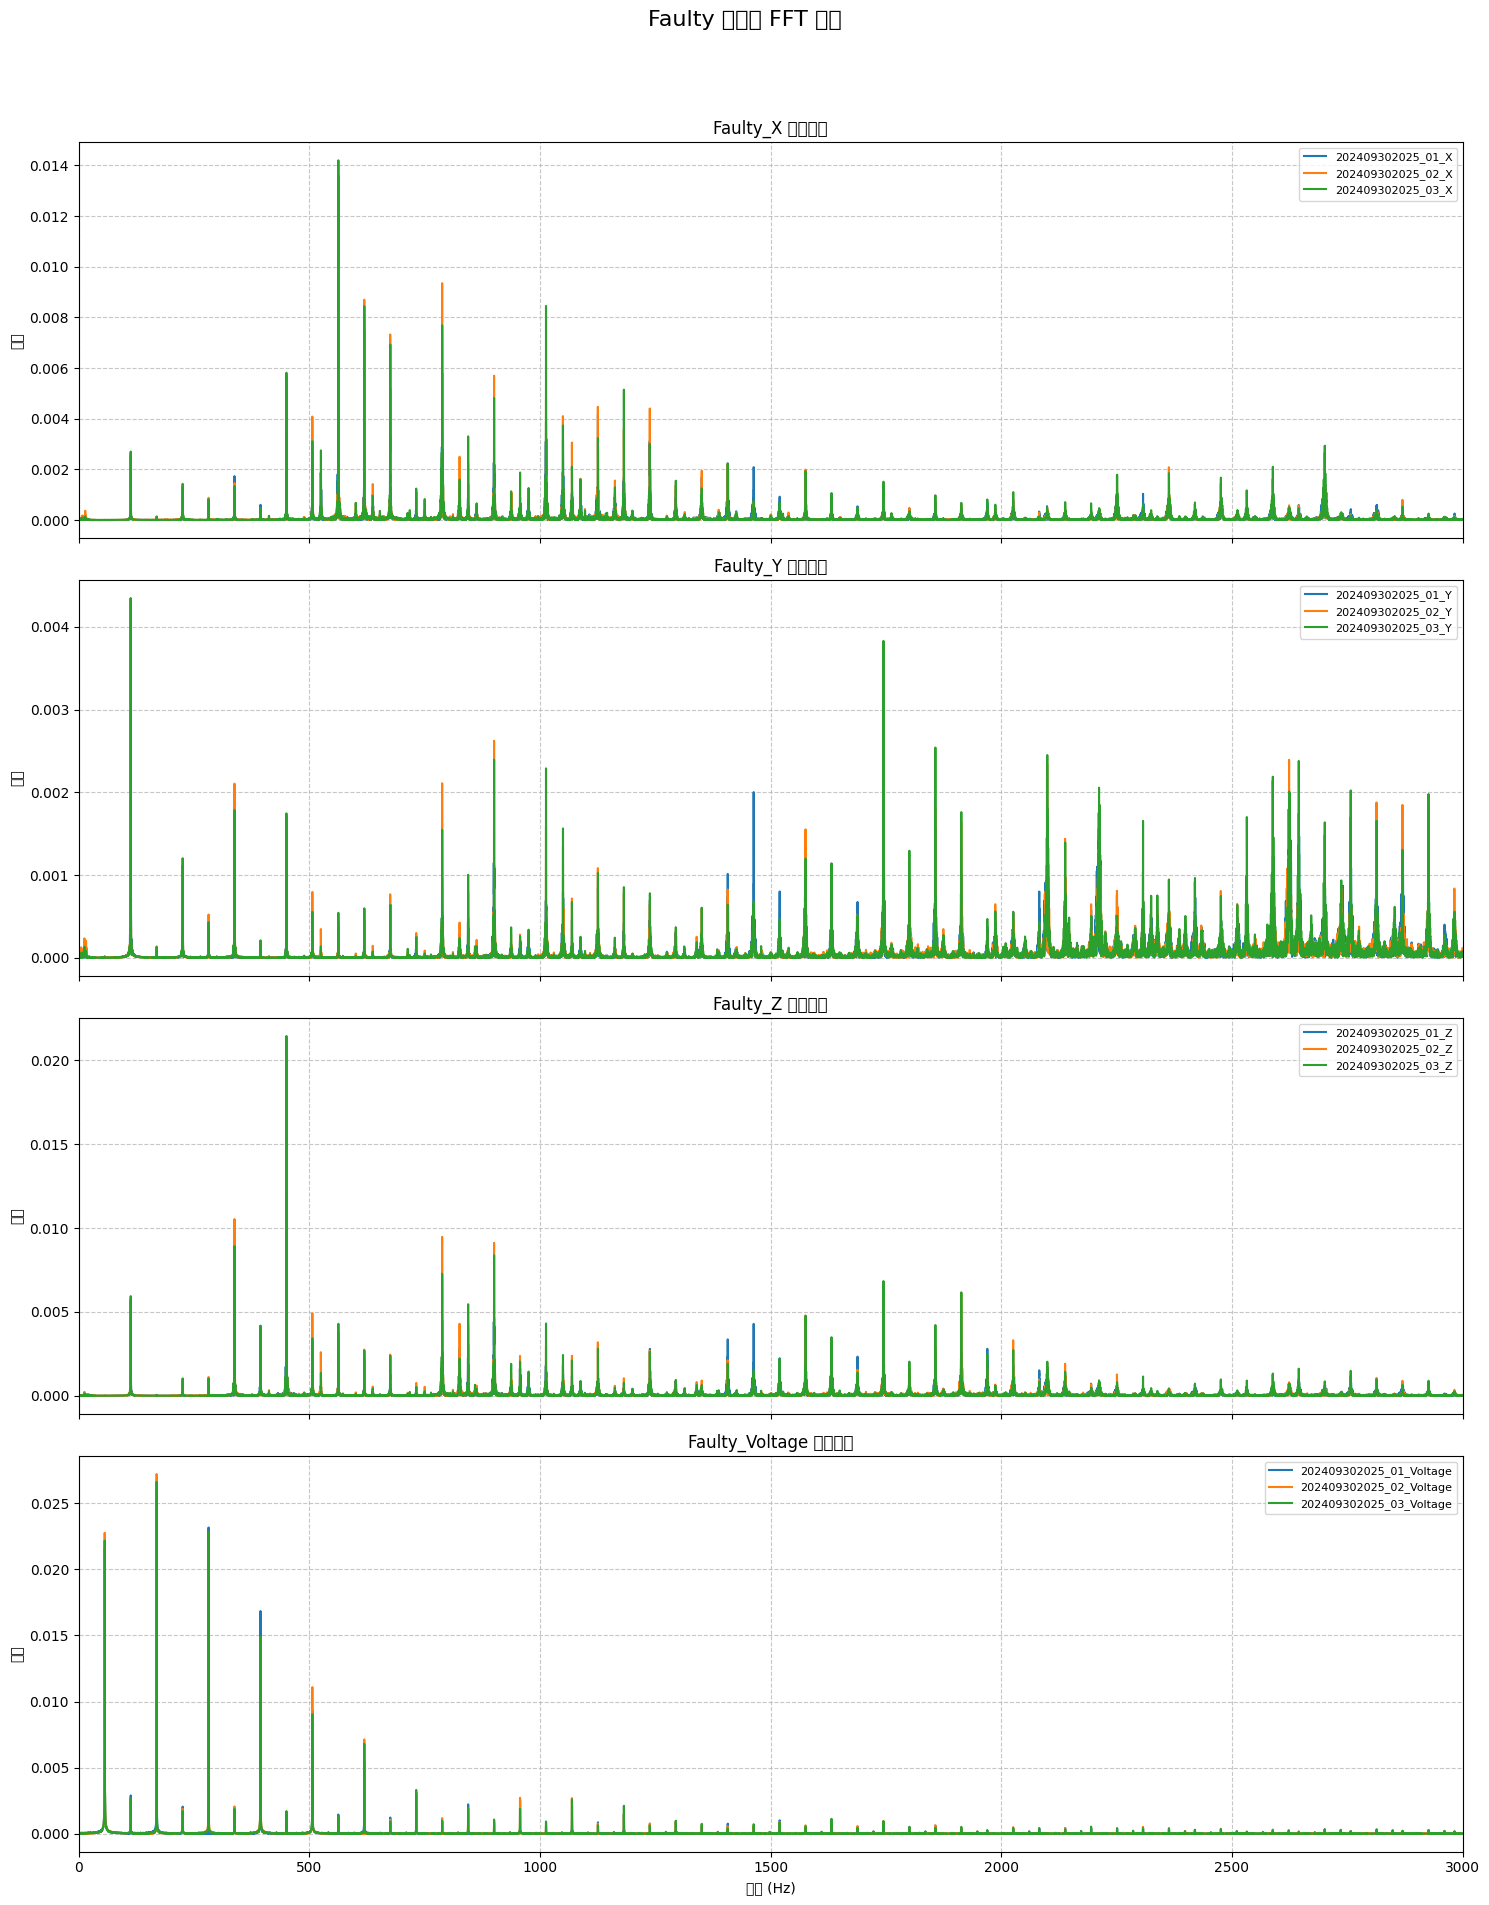

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm

# Configure Matplotlib to display Chinese characters
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # Set font to support Chinese
plt.rcParams['axes.unicode_minus'] = False # Solve the problem of '-' displaying as a square

# Define sampling parameters, consistent with previous FFT calculation
Fs = 6000  # Sampling frequency (Hz)
N = 30000  # Number of sampling points

# Create the frequency axis (same for all FFTs)
x_freq = np.fft.fftfreq(N, 1/Fs)[:N//2]

output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'

data_types = {
    'Faulty_X': 'Faulty_X_FFT_Df.csv',
    'Faulty_Y': 'Faulty_Y_FFT_Df.csv',
    'Faulty_Z': 'Faulty_Z_FFT_Df.csv',
    'Faulty_Voltage': 'Faulty_Voltage_FFT_Df.csv'
}

# Plotting loop for each data type
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 20), sharex=True)
fig.suptitle('Faulty 數據的 FFT 頻譜', fontsize=16, y=0.98)

for i, (df_name, file_name) in enumerate(data_types.items()):
    file_path = os.path.join(output_dir, file_name)

    if os.path.exists(file_path):
        fft_df = pd.read_csv(file_path)

        ax = axes[i]
        # Plot the first 3 columns from each FFT DataFrame for visualization
        # This prevents overcrowding the plot if there are many columns
        num_cols_to_plot = min(3, fft_df.shape[1])
        for j in range(num_cols_to_plot):
            column_to_plot = fft_df.columns[j]
            ax.plot(x_freq, fft_df[column_to_plot], label=column_to_plot.replace('_FFT_Magnitude', ''))

        ax.set_title(f'{df_name} 頻譜振幅', fontsize=12)
        ax.set_ylabel('振幅', fontsize=10)
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(0, Fs/2) # Limit x-axis to Nyquist frequency
    else:
        print(f"錯誤：檔案 {file_path} 不存在。請確認 FFT 步驟已成功執行。\n")
        axes[i].set_title(f'{df_name} 頻譜振幅 (檔案未找到)', fontsize=12)
        axes[i].set_ylabel('振幅', fontsize=10)
        axes[i].text(0.5, 0.5, '數據不可用', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, fontsize=14, color='red')

axes[-1].set_xlabel('頻率 (Hz)', fontsize=10) # Set xlabel only for the bottom plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
plt.show()


####Fauty_FFT_Feature_x1~x5

In [ ]:
import numpy as np
import pandas as pd
import os

# Define sampling parameters, consistent with previous FFT calculation
Fs = 6000  # Sampling frequency (Hz)
N = 30000  # Number of sampling points

# Create the frequency axis (same for all FFTs)
x_freq = np.fft.fftfreq(N, 1/Fs)[:N//2]

def calculate_fft_features(fft_df, df_name, freq_axis, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    """Calculates FFTx1-FFTx5 features for each column of an FFT DataFrame."""
    print(f"\n正在為 {df_name} 計算 FFT 特徵 (FFTx1-FFTx5)...")
    features_list = []

    if fft_df.empty:
        print(f"警告: {df_name} FFT DataFrame 為空，跳過特徵計算。")
        return pd.DataFrame()

    for col in fft_df.columns:
        amplitudes = fft_df[col].values

        # Ensure no division by zero for spectral centroid/spread
        total_amplitude = np.sum(amplitudes)
        if total_amplitude == 0:
            # Handle cases where all amplitudes are zero (e.g., a constant signal's FFT without DC component)
            spectral_centroid = 0
            spectral_spread = 0
        else:
            # FFTx4 (Spectral Centroid): Weighted average of frequencies
            spectral_centroid = np.sum(amplitudes * freq_axis) / total_amplitude

            # FFTx5 (Spectral Spread): Standard deviation around the spectral centroid
            # Using (freq - centroid)^2 * amplitude / total_amplitude
            spectral_spread = np.sqrt(np.sum(amplitudes * (freq_axis - spectral_centroid)**2) / total_amplitude)

        features_list.append({
            'Column': col.replace('_FFT_Magnitude', ''), # Clean column name
            'FFTx1_Max_Amplitude': np.max(amplitudes),
            'FFTx2_Mean_Amplitude': np.mean(amplitudes),
            'FFTx3_Std_Amplitude': np.std(amplitudes),
            'FFTx4_Spectral_Centroid': spectral_centroid,
            'FFTx5_Spectral_Spread': spectral_spread
        })

    features_df = pd.DataFrame(features_list)
    features_df = features_df.set_index('Column')

    output_file_path = f'{output_dir}{df_name}_FFT_Features_Df.csv'
    features_df.to_csv(output_file_path)

    print(f"已成功為 {df_name} 計算 FFT 特徵並儲存到 {output_file_path}")
    print(f"{df_name}_FFT_Features_Df 的前5行：")
    display(features_df.head())
    print(f"{df_name}_FFT_Features_Df 的維度：")
    print(features_df.shape)
    return features_df

# --- New function to calculate harmonic features (1X, 2X, ..., 5X) ---
def calculate_harmonic_features(fft_df, df_name, freq_axis, base_freq, freq_window, harmonic_orders, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    """Calculates harmonic features (max amplitude around n*base_freq) for each column of an FFT DataFrame."""
    print(f"\n正在為 {df_name} 計算 {len(harmonic_orders)} 個諧波特徵 (基頻 {base_freq} Hz)...")
    harmonic_features_list = []

    if fft_df.empty:
        print(f"警告: {df_name} FFT DataFrame 為空，跳過諧波特徵計算。")
        return pd.DataFrame()

    for col in fft_df.columns:
        column_features = {'Column': col.replace('_FFT_Magnitude', '')}
        amplitudes = fft_df[col].values

        for n in harmonic_orders:
            target_freq = base_freq * n
            lower_bound = target_freq - freq_window
            upper_bound = target_freq + freq_window

            # Find frequency indices within the window
            freq_indices = np.where((freq_axis >= lower_bound) & (freq_axis <= upper_bound))[0]

            max_harmonic_amplitude = np.nan
            if len(freq_indices) > 0:
                # Ensure indices are within bounds of amplitudes array
                valid_indices = freq_indices[(freq_indices >= 0) & (freq_indices < len(amplitudes))]
                if len(valid_indices) > 0:
                    max_harmonic_amplitude = np.max(amplitudes[valid_indices])
                else:
                    print(f"警告: 在 {df_name} 的欄位 {col} 中，諧波 {n}X 的頻率範圍 [{lower_bound:.2f}, {upper_bound:.2f}] Hz 內沒有找到有效的振幅資料。")
            else:
                print(f"警告: 在 {df_name} 的欄位 {col} 中，諧波 {n}X 的頻率範圍 [{lower_bound:.2f}, {upper_bound:.2f}] Hz 內沒有找到頻率點。")

            column_features[f'FFT_{n}X_Amplitude_{target_freq:.0f}Hz'] = max_harmonic_amplitude

        harmonic_features_list.append(column_features)

    harmonic_features_df = pd.DataFrame(harmonic_features_list)
    harmonic_features_df = harmonic_features_df.set_index('Column')

    output_file_path = f'{output_dir}{df_name}_Harmonic_Features_Df.csv'
    harmonic_features_df.to_csv(output_file_path)

    print(f"已成功為 {df_name} 計算諧波特徵並儲存到 {output_file_path}")
    print(f"{df_name}_Harmonic_Features_Df 的前5行：")
    display(harmonic_features_df.head())
    print(f"{df_name}_Harmonic_Features_Df 的維度：")
    print(harmonic_features_df.shape)
    return harmonic_features_df

# --- Load Faulty FFT DataFrames and calculate FFTx1-FFTx5 features ---

# Faulty X FFT Features (FFTx1-FFTx5)
faulty_X_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_X_FFT_Df.csv'
Faulty_X_FFT_Df = pd.read_csv(faulty_X_fft_path)
Faulty_X_FFT_Features_Df = calculate_fft_features(Faulty_X_FFT_Df, 'Faulty_X', x_freq)

# Faulty Y FFT Features (FFTx1-FFTx5)
faulty_Y_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Y_FFT_Df.csv'
Faulty_Y_FFT_Df = pd.read_csv(faulty_Y_fft_path)
Faulty_Y_FFT_Features_Df = calculate_fft_features(Faulty_Y_FFT_Df, 'Faulty_Y', x_freq)

# Faulty Z FFT Features (FFTx1-FFTx5)
faulty_Z_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Z_FFT_Df.csv'
Faulty_Z_FFT_Df = pd.read_csv(faulty_Z_fft_path)
Faulty_Z_FFT_Features_Df = calculate_fft_features(Faulty_Z_FFT_Df, 'Faulty_Z', x_freq)

# Faulty Voltage FFT Features (FFTx1-FFTx5)
faulty_voltage_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Voltage_FFT_Df.csv'
Faulty_Voltage_FFT_Df = pd.read_csv(faulty_voltage_fft_path)
Faulty_Voltage_FFT_Features_Df = calculate_fft_features(Faulty_Voltage_FFT_Df, 'Faulty_Voltage', x_freq)

# --- Calculate Harmonic Features (1X, 2X, ..., 5X) for Faulty Data ---
base_freq = 117.0  # Rotating frequency (approximately 7000 RPM / 60)
freq_window = 1.0  # Frequency window around the harmonic
harmonic_orders = [1, 2, 3, 4, 5]

# Faulty X Harmonic Features
Faulty_X_Harmonic_Features_Df = calculate_harmonic_features(Faulty_X_FFT_Df, 'Faulty_X', x_freq, base_freq, freq_window, harmonic_orders)

# Faulty Y Harmonic Features
Faulty_Y_Harmonic_Features_Df = calculate_harmonic_features(Faulty_Y_FFT_Df, 'Faulty_Y', x_freq, base_freq, freq_window, harmonic_orders)

# Faulty Z Harmonic Features
Faulty_Z_Harmonic_Features_Df = calculate_harmonic_features(Faulty_Z_FFT_Df, 'Faulty_Z', x_freq, base_freq, freq_window, harmonic_orders)

# Faulty Voltage Harmonic Features
Faulty_Voltage_Harmonic_Features_Df = calculate_harmonic_features(Faulty_Voltage_FFT_Df, 'Faulty_Voltage', x_freq, base_freq, freq_window, harmonic_orders)



正在為 Faulty_X 計算 FFT 特徵 (FFTx1-FFTx5)...
已成功為 Faulty_X 計算 FFT 特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_X_FFT_Features_Df.csv
Faulty_X_FFT_Features_Df 的前5行：


,FFTx1_Max_Amplitude,FFTx2_Mean_Amplitude,FFTx3_Std_Amplitude,FFTx4_Spectral_Centroid,FFTx5_Spectral_Spread
Column,,,,,
202409302025_01_X,0.013602,0.000083,0.000261,1402.508997,766.678977
202409302025_02_X,0.010226,0.000074,0.000247,1415.358564,783.930009
202409302025_03_X,0.014198,0.000074,0.000264,1426.412800,777.367103
202409302025_04_X,0.014609,0.000072,0.000273,1430.290878,779.678072
202409302025_05_X,0.012651,0.000087,0.000292,1383.723135,750.424854


Faulty_X_FFT_Features_Df 的維度：
(48, 5)

正在為 Faulty_Y 計算 FFT 特徵 (FFTx1-FFTx5)...
已成功為 Faulty_Y 計算 FFT 特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Y_FFT_Features_Df.csv
Faulty_Y_FFT_Features_Df 的前5行：


,FFTx1_Max_Amplitude,FFTx2_Mean_Amplitude,FFTx3_Std_Amplitude,FFTx4_Spectral_Centroid,FFTx5_Spectral_Spread
Column,,,,,
202409302025_01_Y,0.004344,0.000070,0.000144,2053.044942,725.279303
202409302025_02_Y,0.004322,0.000066,0.000142,2048.105224,737.670726
202409302025_03_Y,0.004347,0.000066,0.000153,2072.207948,722.731604
202409302025_04_Y,0.004266,0.000064,0.000158,2084.256605,721.897547
202409302025_05_Y,0.004374,0.000068,0.000154,2100.643560,691.872484


Faulty_Y_FFT_Features_Df 的維度：
(48, 5)

正在為 Faulty_Z 計算 FFT 特徵 (FFTx1-FFTx5)...
已成功為 Faulty_Z 計算 FFT 特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Z_FFT_Features_Df.csv
Faulty_Z_FFT_Features_Df 的前5行：


,FFTx1_Max_Amplitude,FFTx2_Mean_Amplitude,FFTx3_Std_Amplitude,FFTx4_Spectral_Centroid,FFTx5_Spectral_Spread
Column,,,,,
202409302025_01_Z,0.012037,0.000102,0.000274,1488.519410,744.516336
202409302025_02_Z,0.021447,0.000097,0.000318,1483.630561,760.015746
202409302025_03_Z,0.021453,0.000093,0.000316,1489.037853,758.663273
202409302025_04_Z,0.021599,0.000090,0.000316,1492.574918,767.450470
202409302025_05_Z,0.012525,0.000093,0.000245,1546.433509,738.718209


Faulty_Z_FFT_Features_Df 的維度：
(48, 5)

正在為 Faulty_Voltage 計算 FFT 特徵 (FFTx1-FFTx5)...
已成功為 Faulty_Voltage 計算 FFT 特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Voltage_FFT_Features_Df.csv
Faulty_Voltage_FFT_Features_Df 的前5行：


,FFTx1_Max_Amplitude,FFTx2_Mean_Amplitude,FFTx3_Std_Amplitude,FFTx4_Spectral_Centroid,FFTx5_Spectral_Spread
Column,,,,,
202409302025_01_Voltage,0.025722,0.000044,0.000425,685.372975,751.157705
202409302025_02_Voltage,0.027216,0.000045,0.000425,703.611023,756.315517
202409302025_03_Voltage,0.026624,0.000045,0.000425,693.149288,751.504582
202409302025_04_Voltage,0.026515,0.000044,0.000424,669.796565,741.156536
202409302025_05_Voltage,0.026618,0.000044,0.000422,662.778234,735.089103


Faulty_Voltage_FFT_Features_Df 的維度：
(48, 5)

正在為 Faulty_X 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Faulty_X 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_X_Harmonic_Features_Df.csv
Faulty_X_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
202409302025_01_X,0.000062,0.000012,0.000009,0.000043,0.000065
202409302025_02_X,0.000047,0.000027,0.000018,0.000052,0.000054
202409302025_03_X,0.000043,0.000020,0.000009,0.000043,0.000075
202409302025_04_X,0.000033,0.000020,0.000012,0.000050,0.000062
202409302025_05_X,0.000022,0.000020,0.000021,0.000053,0.000059


Faulty_X_Harmonic_Features_Df 的維度：
(48, 5)

正在為 Faulty_Y 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Faulty_Y 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Y_Harmonic_Features_Df.csv
Faulty_Y_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
202409302025_01_Y,0.000101,0.000016,0.000012,0.000015,0.000005
202409302025_02_Y,0.000070,0.000011,0.000015,0.000012,0.000007
202409302025_03_Y,0.000072,0.000012,0.000014,0.000014,0.000005
202409302025_04_Y,0.000054,0.000018,0.000013,0.000016,0.000007
202409302025_05_Y,0.000022,0.000019,0.000010,0.000021,0.000004


Faulty_Y_Harmonic_Features_Df 的維度：
(48, 5)

正在為 Faulty_Z 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Faulty_Z 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Z_Harmonic_Features_Df.csv
Faulty_Z_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
202409302025_01_Z,0.000138,0.000014,0.000075,0.000146,0.000031
202409302025_02_Z,0.000090,0.000010,0.000094,0.000123,0.000032
202409302025_03_Z,0.000094,0.000012,0.000088,0.000132,0.000029
202409302025_04_Z,0.000077,0.000017,0.000083,0.000147,0.000035
202409302025_05_Z,0.000044,0.000016,0.000071,0.000187,0.000029


Faulty_Z_Harmonic_Features_Df 的維度：
(48, 5)

正在為 Faulty_Voltage 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Faulty_Voltage 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Voltage_Harmonic_Features_Df.csv
Faulty_Voltage_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
202409302025_01_Voltage,0.000088,0.000048,0.000023,0.000033,0.000077
202409302025_02_Voltage,0.000038,0.000043,0.000028,0.000027,0.000058
202409302025_03_Voltage,0.000032,0.000036,0.000031,0.000029,0.000068
202409302025_04_Voltage,0.000091,0.000036,0.000032,0.000043,0.000078
202409302025_05_Voltage,0.000020,0.000031,0.000046,0.000041,0.000088


Faulty_Voltage_Harmonic_Features_Df 的維度：
(48, 5)


####Load_Fauty_Data，X、Y、Z、V

In [ ]:
import pandas as pd

# Define file paths for Faulty data
faulty_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_X.csv'
faulty_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Y.csv'
faulty_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Z.csv'
faulty_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Voltage.csv'

# Load Faulty data into DataFrames
Faulty_X_df = pd.read_csv(faulty_X_path)
Faulty_Y_df = pd.read_csv(faulty_Y_path)
Faulty_Z_df = pd.read_csv(faulty_Z_path)
Faulty_Voltage_df = pd.read_csv(faulty_voltage_path)

print("Faulty data loaded successfully.")
print(f"Faulty_X_df shape: {Faulty_X_df.shape}")
print(f"Faulty_Y_df shape: {Faulty_Y_df.shape}")
print(f"Faulty_Z_df shape: {Faulty_Z_df.shape}")
print(f"Faulty_Voltage_df shape: {Faulty_Voltage_df.shape}")

# Display head of one DataFrame for verification
print("\nFaulty_X_df head:")
display(Faulty_X_df.head())


Faulty data loaded successfully.
Faulty_X_df shape: (30000, 48)
Faulty_Y_df shape: (30000, 48)
Faulty_Z_df shape: (30000, 48)
Faulty_Voltage_df shape: (30000, 48)

Faulty_X_df head:


,202409302025_01_X,202409302025_02_X,202409302025_03_X,202409302025_04_X,202409302025_05_X,202409302025_06_X,202409302025_07_X,202409302025_08_X,202409302025_09_X,202409302025_10_X,...,202409302025_39_X,202409302025_40_X,202409302025_41_X,202409302025_42_X,202409302025_43_X,202409302025_44_X,202409302025_45_X,202409302025_46_X,202409302025_47_X,202409302025_48_X
0,0.012858,0.002999,-0.010269,0.006186,-0.023477,0.028791,0.010270,0.005649,0.030702,-0.026971,...,0.012274,0.105804,-0.006244,-0.000176,0.005946,0.006647,-0.021958,-0.015788,-0.011093,-0.008140
1,-0.032346,0.024062,0.025824,0.006513,-0.016347,-0.007647,0.026750,0.011834,0.013707,0.013238,...,0.018455,0.009045,-0.004631,-0.020287,-0.007058,0.016782,-0.001428,-0.009923,-0.010077,0.012112
2,-0.011552,-0.004301,0.048699,0.018335,-0.000228,-0.005740,-0.004280,0.007815,0.001053,0.047169,...,-0.004505,-0.029644,0.023080,-0.020585,0.011544,-0.008638,-0.018401,-0.011965,0.001947,-0.004476
3,0.029130,-0.001112,0.013614,-0.000970,0.022173,0.023577,0.031438,-0.015432,0.009472,0.040392,...,-0.034062,-0.005381,-0.013912,-0.015786,0.015199,-0.026361,-0.023552,-0.007284,0.001212,-0.009097
4,0.068891,0.006404,-0.015303,0.009529,0.042601,-0.003908,0.028108,0.013059,0.012413,0.038745,...,-0.027097,0.009454,-0.040518,-0.012530,0.015102,-0.022047,0.005120,-0.008506,-0.024614,-0.019782


####Faulty_X_Y_Z_V__Features_df

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import math
import os

# Define the calculate_statistical_features function if it's not already defined
# This function should be present from a previous execution (e.g., cell TwaDKDplt8_4)
# For robustness, redefine it here if necessary, assuming it's the same as TwaDKDplt8_4

def calculate_statistical_features(df, df_name, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    print(f"\n正在為 {df_name} 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...")
    features_list = []

    if df.empty:
        print(f"警告: {df_name} 為空，跳過統計特徵計算。")
        return pd.DataFrame()

    for col in df.columns:
        data = df[col]

        # Calculate features
        col_mean = data.mean()
        col_std = data.std()
        col_rms = math.sqrt(data.pow(2).mean()) # RMS = sqrt(mean of squares)
        col_kurtosis = kurtosis(data)
        col_skewness = skew(data)

        features_list.append({
            'Column': col,
            'RMS': col_rms,
            'Mean': col_mean,
            'Kurtosis': col_kurtosis,
            'Std': col_std,
            'Skewness': col_skewness
        })

    features_df = pd.DataFrame(features_list)
    features_df = features_df.set_index('Column')

    desired_column_order = ['RMS', 'Mean', 'Kurtosis', 'Std', 'Skewness']
    features_df = features_df[desired_column_order]

    output_file_path = f'{output_dir}{df_name}_Features_df.csv'
    features_df.to_csv(output_file_path)

    print(f"已成功為 {df_name} 計算統計特徵並儲存到 {output_file_path}")
    print(f"{df_name}_Features_df 的前5行：")
    display(features_df.head())
    print(f"{df_name}_Features_df 的維度：")
    print(features_df.shape)
    return features_df

# Define file paths for Faulty data (raw merged clean tables)
faulty_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_X.csv'
faulty_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Y.csv'
faulty_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Z.csv'
faulty_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Merge_Clean_Table_Voltage.csv'

output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'
os.makedirs(output_dir, exist_ok=True)

print("--- 計算 Faulty 各維度統計特徵 ---")

# --- Process Faulty X data ---
Faulty_X_df = pd.read_csv(faulty_X_path)
Faulty_X_Features_df = calculate_statistical_features(Faulty_X_df, 'Faulty_X')

# --- Process Faulty Y data ---
Faulty_Y_df = pd.read_csv(faulty_Y_path)
Faulty_Y_Features_df = calculate_statistical_features(Faulty_Y_df, 'Faulty_Y')

# --- Process Faulty Z data ---
Faulty_Z_df = pd.read_csv(faulty_Z_path)
Faulty_Z_Features_df = calculate_statistical_features(Faulty_Z_df, 'Faulty_Z')

# --- Process Faulty Voltage data ---
Faulty_Voltage_df = pd.read_csv(faulty_voltage_path)
Faulty_Voltage_Features_df = calculate_statistical_features(Faulty_Voltage_df, 'Faulty_Voltage')

print("\n所有 Faulty 數據的統計特徵計算和儲存已完成。")


--- 計算 Faulty 各維度統計特徵 ---

正在為 Faulty_X 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Faulty_X 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_X_Features_df.csv
Faulty_X_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
202409302025_01_X,0.023724,0.000137,0.587321,0.023724,-0.229660
202409302025_02_X,0.022344,0.000169,1.406470,0.022343,-0.524710
202409302025_03_X,0.023776,0.000143,1.327990,0.023776,-0.464774
202409302025_04_X,0.024480,0.000129,1.213258,0.024480,-0.387796
202409302025_05_X,0.026405,0.000151,1.488870,0.026405,-0.191874


Faulty_X_Features_df 的維度：
(48, 5)

正在為 Faulty_Y 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Faulty_Y 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Y_Features_df.csv
Faulty_Y_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
202409302025_01_Y,0.013849,3.777142e-05,0.351289,0.013849,0.273323
202409302025_02_Y,0.013577,4.051662e-05,0.238624,0.013577,0.250151
202409302025_03_Y,0.014384,-2.465137e-05,0.460819,0.014384,0.318642
202409302025_04_Y,0.014746,4.615212e-07,0.475268,0.014747,0.310077
202409302025_05_Y,0.014580,-3.471709e-05,0.643327,0.014581,0.055786


Faulty_Y_Features_df 的維度：
(48, 5)

正在為 Faulty_Z 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Faulty_Z 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Z_Features_df.csv
Faulty_Z_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
202409302025_01_Z,0.025296,0.000194,0.550180,0.025296,-0.513408
202409302025_02_Z,0.028755,0.000196,0.669885,0.028754,-0.560187
202409302025_03_Z,0.028541,0.000190,0.664697,0.028541,-0.593706
202409302025_04_Z,0.028484,0.000160,0.788878,0.028484,-0.633625
202409302025_05_Z,0.022667,0.000183,0.182677,0.022667,-0.008922


Faulty_Z_Features_df 的維度：
(48, 5)

正在為 Faulty_Voltage 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Faulty_Voltage 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Voltage_Features_df.csv
Faulty_Voltage_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
202409302025_01_Voltage,0.037097,0.004308,4.545382,0.036846,0.517489
202409302025_02_Voltage,0.037159,0.004258,4.546249,0.036914,0.498782
202409302025_03_Voltage,0.037145,0.004241,4.547058,0.036903,0.493571
202409302025_04_Voltage,0.037059,0.004289,4.564633,0.036811,0.505664
202409302025_05_Voltage,0.036837,0.004259,4.497206,0.036591,0.514691


Faulty_Voltage_Features_df 的維度：
(48, 5)

所有 Faulty 數據的統計特徵計算和儲存已完成。


####Fauty_合併Feature和FFT_Feature

In [ ]:
import pandas as pd
import os

output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'
os.makedirs(output_dir, exist_ok=True)

dimensions = ['X', 'Y', 'Z', 'Voltage']

# Dictionary to store combined feature dataframes for each dimension
Faulty_Combined_Features_Dict = {}

for dim in dimensions:
    print(f"\n--- 正在組合 Faulty {dim} 數據的統計特徵和諧波特徵 ---")

    # Define file paths for Statistical features and Harmonic features
    statistical_features_path = os.path.join(output_dir, f'Faulty_{dim}_Features_df.csv')
    harmonic_features_path = os.path.join(output_dir, f'Faulty_{dim}_Harmonic_Features_Df.csv')

    # Load the feature DataFrames
    try:
        statistical_features_df = pd.read_csv(statistical_features_path, index_col='Column')
        harmonic_features_df = pd.read_csv(harmonic_features_path, index_col='Column')
    except FileNotFoundError as e:
        print(f"錯誤: 找不到文件 {e.filename}。請確認所有統計特徵和諧波特徵已成功生成並儲存。")
        continue
    except Exception as e:
        print(f"載入文件時發生未知錯誤: {e}")
        continue

    # Combine the two feature DataFrames horizontally
    # Ensure both DataFrames have the same index for proper alignment
    if not statistical_features_df.index.equals(harmonic_features_df.index):
        print(f"警告: Faulty {dim} 的統計特徵和諧波特徵的索引不匹配。嘗試按索引合併。")
        # Use outer join to keep all indices and fill NaNs if necessary
        combined_features_df = pd.merge(
            statistical_features_df,
            harmonic_features_df,
            left_index=True,
            right_index=True,
            how='outer'
        )
    else:
        combined_features_df = pd.concat([statistical_features_df, harmonic_features_df], axis=1)

    # Store the combined DataFrame in the dictionary
    Faulty_Combined_Features_Dict[dim] = combined_features_df

    # Assign a name to the combined DataFrame in global scope for potential future use
    df_name = f'Faulty_{dim}_Combined_Features_Df'
    globals()[df_name] = combined_features_df

    # Save the combined DataFrame to a CSV file
    output_file_name = f'{df_name}.csv'
    output_file_path = os.path.join(output_dir, output_file_name)
    combined_features_df.to_csv(output_file_path, index=True) # Keep the 'Column' as index in CSV

    print(f"已成功組合並儲存 Faulty {dim} 的特徵至 {output_file_path}")
    print(f"{df_name} 的形狀: {combined_features_df.shape}")
    print(f"{df_name} 的前5行:")
    display(combined_features_df.head())


# --- Combine all dimension-specific combined DataFrames into a single Faulty_All_Features_Df ---
print("\n--- 正在將所有 Faulty 特徵 DataFrame 整合為一個 ---")

# Retrieve all four combined dataframes from the dictionary
Faulty_X_Combined_Features_Df = Faulty_Combined_Features_Dict.get('X')
Faulty_Y_Combined_Features_Df = Faulty_Combined_Features_Dict.get('Y')
Faulty_Z_Combined_Features_Df = Faulty_Combined_Features_Dict.get('Z')
Faulty_Voltage_Combined_Features_Df = Faulty_Combined_Features_Dict.get('Voltage')

# Check if all DataFrames were successfully loaded and combined in the loop
if all(df is not None for df in [Faulty_X_Combined_Features_Df, Faulty_Y_Combined_Features_Df, Faulty_Z_Combined_Features_Df, Faulty_Voltage_Combined_Features_Df]):
    Faulty_All_Features_Df = pd.concat(
        [
            Faulty_X_Combined_Features_Df,
            Faulty_Y_Combined_Features_Df,
            Faulty_Z_Combined_Features_Df,
            Faulty_Voltage_Combined_Features_Df
        ],
        axis=1
    )

    # Save the final combined DataFrame to a CSV file
    final_output_file_path = os.path.join(output_dir, 'Faulty_All_Features_Df.csv')
    Faulty_All_Features_Df.to_csv(final_output_file_path, index=True)

    print("\nFaulty_All_Features_Df 已成功建立。")
    print(f"Faulty_All_Features_Df 的形狀: {Faulty_All_Features_Df.shape}")
    print("Faulty_All_Features_Df 的前5行:")
    display(Faulty_All_Features_Df.head())
    print(f"最終整合的 Faulty 特徵已儲存至: {final_output_file_path}")
else:
    print("錯誤: 某些 Faulty 維度的特徵組合失敗，無法建立 Faulty_All_Features_Df。")

print("\n所有 Faulty 數據的特徵組合和儲存已完成。")



--- 正在組合 Faulty X 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Faulty X 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_X_Combined_Features_Df.csv
Faulty_X_Combined_Features_Df 的形狀: (48, 10)
Faulty_X_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
202409302025_01_X,0.023724,0.000137,0.587321,0.023724,-0.229660,0.000062,0.000012,0.000009,0.000043,0.000065
202409302025_02_X,0.022344,0.000169,1.406470,0.022343,-0.524710,0.000047,0.000027,0.000018,0.000052,0.000054
202409302025_03_X,0.023776,0.000143,1.327990,0.023776,-0.464774,0.000043,0.000020,0.000009,0.000043,0.000075
202409302025_04_X,0.024480,0.000129,1.213258,0.024480,-0.387796,0.000033,0.000020,0.000012,0.000050,0.000062
202409302025_05_X,0.026405,0.000151,1.488870,0.026405,-0.191874,0.000022,0.000020,0.000021,0.000053,0.000059



--- 正在組合 Faulty Y 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Faulty Y 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Y_Combined_Features_Df.csv
Faulty_Y_Combined_Features_Df 的形狀: (48, 10)
Faulty_Y_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
202409302025_01_Y,0.013849,3.777142e-05,0.351289,0.013849,0.273323,0.000101,0.000016,0.000012,0.000015,0.000005
202409302025_02_Y,0.013577,4.051662e-05,0.238624,0.013577,0.250151,0.000070,0.000011,0.000015,0.000012,0.000007
202409302025_03_Y,0.014384,-2.465137e-05,0.460819,0.014384,0.318642,0.000072,0.000012,0.000014,0.000014,0.000005
202409302025_04_Y,0.014746,4.615212e-07,0.475268,0.014747,0.310077,0.000054,0.000018,0.000013,0.000016,0.000007
202409302025_05_Y,0.014580,-3.471709e-05,0.643327,0.014581,0.055786,0.000022,0.000019,0.000010,0.000021,0.000004



--- 正在組合 Faulty Z 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Faulty Z 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Z_Combined_Features_Df.csv
Faulty_Z_Combined_Features_Df 的形狀: (48, 10)
Faulty_Z_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
202409302025_01_Z,0.025296,0.000194,0.550180,0.025296,-0.513408,0.000138,0.000014,0.000075,0.000146,0.000031
202409302025_02_Z,0.028755,0.000196,0.669885,0.028754,-0.560187,0.000090,0.000010,0.000094,0.000123,0.000032
202409302025_03_Z,0.028541,0.000190,0.664697,0.028541,-0.593706,0.000094,0.000012,0.000088,0.000132,0.000029
202409302025_04_Z,0.028484,0.000160,0.788878,0.028484,-0.633625,0.000077,0.000017,0.000083,0.000147,0.000035
202409302025_05_Z,0.022667,0.000183,0.182677,0.022667,-0.008922,0.000044,0.000016,0.000071,0.000187,0.000029



--- 正在組合 Faulty Voltage 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Faulty Voltage 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Voltage_Combined_Features_Df.csv
Faulty_Voltage_Combined_Features_Df 的形狀: (48, 10)
Faulty_Voltage_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
202409302025_01_Voltage,0.037097,0.004308,4.545382,0.036846,0.517489,0.000088,0.000048,0.000023,0.000033,0.000077
202409302025_02_Voltage,0.037159,0.004258,4.546249,0.036914,0.498782,0.000038,0.000043,0.000028,0.000027,0.000058
202409302025_03_Voltage,0.037145,0.004241,4.547058,0.036903,0.493571,0.000032,0.000036,0.000031,0.000029,0.000068
202409302025_04_Voltage,0.037059,0.004289,4.564633,0.036811,0.505664,0.000091,0.000036,0.000032,0.000043,0.000078
202409302025_05_Voltage,0.036837,0.004259,4.497206,0.036591,0.514691,0.000020,0.000031,0.000046,0.000041,0.000088



--- 正在將所有 Faulty 特徵 DataFrame 整合為一個 ---

Faulty_All_Features_Df 已成功建立。
Faulty_All_Features_Df 的形狀: (192, 40)
Faulty_All_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz,...,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,,,,,,,,,,,,
202409302025_01_X,0.023724,0.000137,0.587321,0.023724,-0.229660,0.000062,0.000012,0.000009,0.000043,0.000065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202409302025_02_X,0.022344,0.000169,1.406470,0.022343,-0.524710,0.000047,0.000027,0.000018,0.000052,0.000054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202409302025_03_X,0.023776,0.000143,1.327990,0.023776,-0.464774,0.000043,0.000020,0.000009,0.000043,0.000075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202409302025_04_X,0.024480,0.000129,1.213258,0.024480,-0.387796,0.000033,0.000020,0.000012,0.000050,0.000062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202409302025_05_X,0.026405,0.000151,1.488870,0.026405,-0.191874,0.000022,0.000020,0.000021,0.000053,0.000059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


最終整合的 Faulty 特徵已儲存至: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_All_Features_Df.csv

所有 Faulty 數據的特徵組合和儲存已完成。


###特徵表建立Testing的特徵rms，mean，kurtosis，std，skewness，X1~X5，共10個欄位

****前5個特徵的值和matlab一樣，第6~第10不一樣，因為套件的運算方式和matlab不同

####Testing快速傅立葉轉換

In [ ]:
import numpy as np
import pandas as pd
import os

# Define sampling parameters, consistent with previous FFT calculation
Fs = 6000  # Sampling frequency (Hz)
N = 30000  # Number of sampling points

# The perform_fft_and_save function should already be defined in a previous cell.
# If not, it needs to be defined here or run the cell where it's defined.

def perform_fft_and_save(df, df_name, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    """Performs FFT on each column of a DataFrame and saves the magnitudes to a new CSV."""
    print(f"\n正在對 {df_name} 執行 FFT...")
    fft_df = pd.DataFrame()

    if df.empty:
        print(f"警告: {df_name} 為空，跳過 FFT。")
        return pd.DataFrame() # Return an empty DataFrame if input is empty

    for column in df.columns:
        signal = df[column].values

        yf = np.fft.fft(signal, axis=0)

        amplitude = np.abs(yf[0:N//2]) / N * 2
        amplitude[0] = amplitude[0] / 2  # DC component

        fft_df[f'{column}_FFT_Magnitude'] = amplitude

    output_file_path = f'{output_dir}{df_name}_FFT_Df.csv'
    fft_df.to_csv(output_file_path, index=False)

    print(f"已成功對所有 {df_name} 列執行 FFT 並儲存到 {output_file_path}")
    print(f"{df_name}_FFT_Df 的前5行：")
    display(fft_df.head())
    print(f"{df_name}_FFT_Df 的維度：")
    print(fft_df.shape)
    return fft_df

# --- Testing X data ---
testing_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_X.csv'
Testing_X_df = pd.read_csv(testing_X_path)
Testing_X_FFT_Df = perform_fft_and_save(Testing_X_df, 'Testing_X')

# --- Testing Y data ---
testing_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Y.csv'
Testing_Y_df = pd.read_csv(testing_Y_path)
Testing_Y_FFT_Df = perform_fft_and_save(Testing_Y_df, 'Testing_Y')

# --- Testing Z data ---
testing_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Z.csv'
Testing_Z_df = pd.read_csv(testing_Z_path)
Testing_Z_FFT_Df = perform_fft_and_save(Testing_Z_df, 'Testing_Z')

# --- Testing Voltage data ---
testing_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Voltage.csv'
Testing_Voltage_df = pd.read_csv(testing_voltage_path)
Testing_Voltage_FFT_Df = perform_fft_and_save(Testing_Voltage_df, 'Testing_Voltage')



正在對 Testing_X 執行 FFT...
已成功對所有 Testing_X 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_X_FFT_Df.csv
Testing_X_FFT_Df 的前5行：


,faulty_ (1)_X_FFT_Magnitude,faulty_ (10)_X_FFT_Magnitude,faulty_ (11)_X_FFT_Magnitude,faulty_ (12)_X_FFT_Magnitude,faulty_ (2)_X_FFT_Magnitude,faulty_ (3)_X_FFT_Magnitude,faulty_ (4)_X_FFT_Magnitude,faulty_ (5)_X_FFT_Magnitude,faulty_ (6)_X_FFT_Magnitude,faulty_ (7)_X_FFT_Magnitude,...,healthy_ (11)_X_FFT_Magnitude,healthy_ (12)_X_FFT_Magnitude,healthy_ (2)_X_FFT_Magnitude,healthy_ (3)_X_FFT_Magnitude,healthy_ (4)_X_FFT_Magnitude,healthy_ (5)_X_FFT_Magnitude,healthy_ (6)_X_FFT_Magnitude,healthy_ (7)_X_FFT_Magnitude,healthy_ (8)_X_FFT_Magnitude,healthy_ (9)_X_FFT_Magnitude
0,0.000142,0.000125,0.000138,0.000130,0.000131,0.000118,0.000132,0.000138,0.000140,0.000156,...,0.000120,0.000119,0.000120,0.000129,0.000133,0.000118,0.000129,0.000124,0.000150,0.000130
1,0.000009,0.000017,0.000028,0.000004,0.000012,0.000022,0.000014,0.000015,0.000020,0.000034,...,0.000004,0.000027,0.000011,0.000016,0.000024,0.000012,0.000008,0.000021,0.000018,0.000011
2,0.000003,0.000019,0.000008,0.000020,0.000010,0.000002,0.000008,0.000013,0.000015,0.000018,...,0.000016,0.000005,0.000011,0.000013,0.000014,0.000014,0.000015,0.000007,0.000009,0.000006
3,0.000011,0.000013,0.000017,0.000021,0.000015,0.000014,0.000014,0.000012,0.000017,0.000009,...,0.000009,0.000004,0.000015,0.000007,0.000016,0.000015,0.000012,0.000010,0.000005,0.000012
4,0.000001,0.000018,0.000013,0.000006,0.000002,0.000002,0.000007,0.000008,0.000007,0.000003,...,0.000006,0.000003,0.000011,0.000003,0.000004,0.000017,0.000005,0.000001,0.000010,0.000003


Testing_X_FFT_Df 的維度：
(15000, 24)

正在對 Testing_Y 執行 FFT...
已成功對所有 Testing_Y 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_FFT_Df.csv
Testing_Y_FFT_Df 的前5行：


,faulty_ (1)_Y_FFT_Magnitude,faulty_ (10)_Y_FFT_Magnitude,faulty_ (11)_Y_FFT_Magnitude,faulty_ (12)_Y_FFT_Magnitude,faulty_ (2)_Y_FFT_Magnitude,faulty_ (3)_Y_FFT_Magnitude,faulty_ (4)_Y_FFT_Magnitude,faulty_ (5)_Y_FFT_Magnitude,faulty_ (6)_Y_FFT_Magnitude,faulty_ (7)_Y_FFT_Magnitude,...,healthy_ (11)_Y_FFT_Magnitude,healthy_ (12)_Y_FFT_Magnitude,healthy_ (2)_Y_FFT_Magnitude,healthy_ (3)_Y_FFT_Magnitude,healthy_ (4)_Y_FFT_Magnitude,healthy_ (5)_Y_FFT_Magnitude,healthy_ (6)_Y_FFT_Magnitude,healthy_ (7)_Y_FFT_Magnitude,healthy_ (8)_Y_FFT_Magnitude,healthy_ (9)_Y_FFT_Magnitude
0,0.000046,0.000010,0.000036,0.000011,0.000007,0.000014,0.000042,0.000039,0.000050,0.000060,...,0.000024,0.000053,0.000004,0.000010,0.000036,0.000038,0.000081,0.000095,0.000025,0.000046
1,0.000038,0.000018,0.000025,0.000013,0.000021,0.000040,0.000013,0.000015,0.000033,0.000025,...,0.000016,0.000014,0.000051,0.000022,0.000014,0.000015,0.000030,0.000033,0.000031,0.000029
2,0.000010,0.000024,0.000010,0.000025,0.000015,0.000019,0.000020,0.000024,0.000008,0.000007,...,0.000014,0.000023,0.000021,0.000007,0.000024,0.000010,0.000025,0.000014,0.000010,0.000008
3,0.000012,0.000018,0.000015,0.000011,0.000014,0.000015,0.000011,0.000009,0.000009,0.000017,...,0.000012,0.000015,0.000007,0.000005,0.000007,0.000022,0.000007,0.000003,0.000015,0.000013
4,0.000016,0.000008,0.000019,0.000025,0.000006,0.000016,0.000029,0.000013,0.000012,0.000007,...,0.000008,0.000004,0.000006,0.000004,0.000008,0.000023,0.000017,0.000014,0.000010,0.000018


Testing_Y_FFT_Df 的維度：
(15000, 24)

正在對 Testing_Z 執行 FFT...
已成功對所有 Testing_Z 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Z_FFT_Df.csv
Testing_Z_FFT_Df 的前5行：


,faulty_ (1)_Z_FFT_Magnitude,faulty_ (10)_Z_FFT_Magnitude,faulty_ (11)_Z_FFT_Magnitude,faulty_ (12)_Z_FFT_Magnitude,faulty_ (2)_Z_FFT_Magnitude,faulty_ (3)_Z_FFT_Magnitude,faulty_ (4)_Z_FFT_Magnitude,faulty_ (5)_Z_FFT_Magnitude,faulty_ (6)_Z_FFT_Magnitude,faulty_ (7)_Z_FFT_Magnitude,...,healthy_ (11)_Z_FFT_Magnitude,healthy_ (12)_Z_FFT_Magnitude,healthy_ (2)_Z_FFT_Magnitude,healthy_ (3)_Z_FFT_Magnitude,healthy_ (4)_Z_FFT_Magnitude,healthy_ (5)_Z_FFT_Magnitude,healthy_ (6)_Z_FFT_Magnitude,healthy_ (7)_Z_FFT_Magnitude,healthy_ (8)_Z_FFT_Magnitude,healthy_ (9)_Z_FFT_Magnitude
0,0.000181,0.000178,0.000191,0.000186,0.000190,0.000184,0.000189,0.000190,0.000159,0.000209,...,0.000170,0.000163,0.000174,0.000165,0.000166,0.000166,0.000166,0.000170,0.000158,0.000167
1,0.000041,0.000001,0.000019,0.000019,0.000032,0.000012,0.000010,0.000028,0.000007,0.000008,...,0.000002,0.000009,0.000011,0.000010,0.000013,0.000007,0.000010,0.000002,0.000014,0.000005
2,0.000016,0.000022,0.000008,0.000014,0.000028,0.000022,0.000019,0.000011,0.000007,0.000027,...,0.000013,0.000005,0.000003,0.000004,0.000013,0.000014,0.000003,0.000006,0.000023,0.000004
3,0.000003,0.000016,0.000013,0.000020,0.000014,0.000010,0.000004,0.000009,0.000013,0.000004,...,0.000010,0.000006,0.000014,0.000015,0.000018,0.000005,0.000012,0.000004,0.000005,0.000008
4,0.000012,0.000005,0.000012,0.000009,0.000004,0.000014,0.000015,0.000015,0.000010,0.000006,...,0.000006,0.000021,0.000011,0.000008,0.000019,0.000005,0.000011,0.000011,0.000004,0.000002


Testing_Z_FFT_Df 的維度：
(15000, 24)

正在對 Testing_Voltage 執行 FFT...
已成功對所有 Testing_Voltage 列執行 FFT 並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Voltage_FFT_Df.csv
Testing_Voltage_FFT_Df 的前5行：


,faulty_ (1)_Voltage_FFT_Magnitude,faulty_ (10)_Voltage_FFT_Magnitude,faulty_ (11)_Voltage_FFT_Magnitude,faulty_ (12)_Voltage_FFT_Magnitude,faulty_ (2)_Voltage_FFT_Magnitude,faulty_ (3)_Voltage_FFT_Magnitude,faulty_ (4)_Voltage_FFT_Magnitude,faulty_ (5)_Voltage_FFT_Magnitude,faulty_ (6)_Voltage_FFT_Magnitude,faulty_ (7)_Voltage_FFT_Magnitude,...,healthy_ (11)_Voltage_FFT_Magnitude,healthy_ (12)_Voltage_FFT_Magnitude,healthy_ (2)_Voltage_FFT_Magnitude,healthy_ (3)_Voltage_FFT_Magnitude,healthy_ (4)_Voltage_FFT_Magnitude,healthy_ (5)_Voltage_FFT_Magnitude,healthy_ (6)_Voltage_FFT_Magnitude,healthy_ (7)_Voltage_FFT_Magnitude,healthy_ (8)_Voltage_FFT_Magnitude,healthy_ (9)_Voltage_FFT_Magnitude
0,0.004359,0.004272,0.004284,0.004280,0.004324,0.004358,0.004377,0.004327,0.004358,0.004296,...,0.003304,0.003257,0.003314,0.003395,0.003260,0.003330,0.003360,0.003341,0.003305,0.003434
1,0.000086,0.000088,0.000054,0.000073,0.000094,0.000045,0.000054,0.000054,0.000095,0.000012,...,0.000050,0.000045,0.000074,0.000004,0.000025,0.000055,0.000038,0.000083,0.000039,0.000053
2,0.000058,0.000036,0.000087,0.000023,0.000038,0.000032,0.000076,0.000081,0.000051,0.000052,...,0.000034,0.000032,0.000055,0.000005,0.000050,0.000048,0.000075,0.000030,0.000015,0.000043
3,0.000059,0.000081,0.000052,0.000058,0.000033,0.000029,0.000064,0.000063,0.000053,0.000059,...,0.000043,0.000048,0.000054,0.000061,0.000026,0.000037,0.000053,0.000040,0.000033,0.000058
4,0.000061,0.000040,0.000030,0.000060,0.000047,0.000032,0.000040,0.000059,0.000064,0.000053,...,0.000069,0.000056,0.000056,0.000035,0.000021,0.000057,0.000050,0.000040,0.000036,0.000048


Testing_Voltage_FFT_Df 的維度：
(15000, 24)


In [ ]:
import pandas as pd

# --- Load Testing FFT DataFrames and calculate FFTx1-FFTx5 features ---

# Testing X FFT Features (FFTx1-FFTx5)
testing_X_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_X_FFT_Df.csv'
Testing_X_FFT_Df = pd.read_csv(testing_X_fft_path)
Testing_X_FFT_Features_Df = calculate_fft_features(Testing_X_FFT_Df, 'Testing_X', x_freq)

# Testing Y FFT Features (FFTx1-FFTx5)
testing_Y_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_FFT_Df.csv'
Testing_Y_FFT_Df = pd.read_csv(testing_Y_fft_path)
Testing_Y_FFT_Features_Df = calculate_fft_features(Testing_Y_FFT_Df, 'Testing_Y', x_freq)

# Testing Z FFT Features (FFTx1-FFTx5)
testing_Z_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Z_FFT_Df.csv'
Testing_Z_FFT_Df = pd.read_csv(testing_Z_fft_path)
Testing_Z_FFT_Features_Df = calculate_fft_features(Testing_Z_FFT_Df, 'Testing_Z', x_freq)

# Testing Voltage FFT Features (FFTx1-FFTx5)
testing_voltage_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Voltage_FFT_Df.csv'
Testing_Voltage_FFT_Df = pd.read_csv(testing_voltage_fft_path)
Testing_Voltage_FFT_Features_Df = calculate_fft_features(Testing_Voltage_FFT_Df, 'Testing_Voltage', x_freq)


正在為 Testing_X 計算 FFT 特徵 (FFTx1-FFTx5)...
已成功為 Testing_X 計算 FFT 特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_X_FFT_Features_Df.csv
Testing_X_FFT_Features_Df 的前5行：


,FFTx1_Max_Amplitude,FFTx2_Mean_Amplitude,FFTx3_Std_Amplitude,FFTx4_Spectral_Centroid,FFTx5_Spectral_Spread
Column,,,,,
faulty_ (1)_X,0.013417,0.000078,0.000298,1438.733577,759.379766
faulty_ (10)_X,0.012506,0.000069,0.000290,1382.678702,741.263430
faulty_ (11)_X,0.007911,0.000091,0.000257,1361.680794,756.305327
faulty_ (12)_X,0.006689,0.000083,0.000225,1311.201306,754.584021
faulty_ (2)_X,0.013225,0.000085,0.000296,1438.908469,767.339445


Testing_X_FFT_Features_Df 的維度：
(24, 5)

正在為 Testing_Y 計算 FFT 特徵 (FFTx1-FFTx5)...
已成功為 Testing_Y 計算 FFT 特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_FFT_Features_Df.csv
Testing_Y_FFT_Features_Df 的前5行：


,FFTx1_Max_Amplitude,FFTx2_Mean_Amplitude,FFTx3_Std_Amplitude,FFTx4_Spectral_Centroid,FFTx5_Spectral_Spread
Column,,,,,
faulty_ (1)_Y,0.004764,0.000062,0.000156,2089.603724,718.291768
faulty_ (10)_Y,0.004812,0.000053,0.000160,2141.031854,686.435028
faulty_ (11)_Y,0.002926,0.000072,0.000142,2054.420665,743.538152
faulty_ (12)_Y,0.004029,0.000069,0.000125,2012.326059,767.159342
faulty_ (2)_Y,0.004629,0.000068,0.000155,2094.613650,717.653462


Testing_Y_FFT_Features_Df 的維度：
(24, 5)

正在為 Testing_Z 計算 FFT 特徵 (FFTx1-FFTx5)...
已成功為 Testing_Z 計算 FFT 特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Z_FFT_Features_Df.csv
Testing_Z_FFT_Features_Df 的前5行：


,FFTx1_Max_Amplitude,FFTx2_Mean_Amplitude,FFTx3_Std_Amplitude,FFTx4_Spectral_Centroid,FFTx5_Spectral_Spread
Column,,,,,
faulty_ (1)_Z,0.014657,0.000080,0.000248,1586.387175,748.704193
faulty_ (10)_Z,0.012514,0.000069,0.000239,1578.933177,753.867636
faulty_ (11)_Z,0.010781,0.000102,0.000234,1476.871235,771.147880
faulty_ (12)_Z,0.017609,0.000102,0.000281,1419.458719,769.209098
faulty_ (2)_Z,0.014843,0.000088,0.000248,1593.890725,758.610729


Testing_Z_FFT_Features_Df 的維度：
(24, 5)

正在為 Testing_Voltage 計算 FFT 特徵 (FFTx1-FFTx5)...
已成功為 Testing_Voltage 計算 FFT 特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Voltage_FFT_Features_Df.csv
Testing_Voltage_FFT_Features_Df 的前5行：


,FFTx1_Max_Amplitude,FFTx2_Mean_Amplitude,FFTx3_Std_Amplitude,FFTx4_Spectral_Centroid,FFTx5_Spectral_Spread
Column,,,,,
faulty_ (1)_Voltage,0.026952,0.000044,0.000425,668.616916,742.998173
faulty_ (10)_Voltage,0.019625,0.000052,0.000426,606.422649,708.331446
faulty_ (11)_Voltage,0.023059,0.000045,0.000424,663.359176,766.438490
faulty_ (12)_Voltage,0.022858,0.000045,0.000427,648.771117,752.621210
faulty_ (2)_Voltage,0.026304,0.000045,0.000425,684.342479,750.197907


Testing_Voltage_FFT_Features_Df 的維度：
(24, 5)


####Testing 數據的 FFT 頻譜圖。

Matplotlib 已配置中文字體。


/tmp/ipython-input-3316674134.py:72: UserWarning: Glyph 25391 (\N{CJK UNIFIED IDEOGRAPH-632F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-3316674134.py:72: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-3316674134.py:72: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-3316674134.py:72: UserWarning: Glyph 35676 (\N{CJK UNIFIED IDEOGRAPH-8B5C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
/tmp/ipython-input-3316674134.py:72: UserWarning: Glyph 

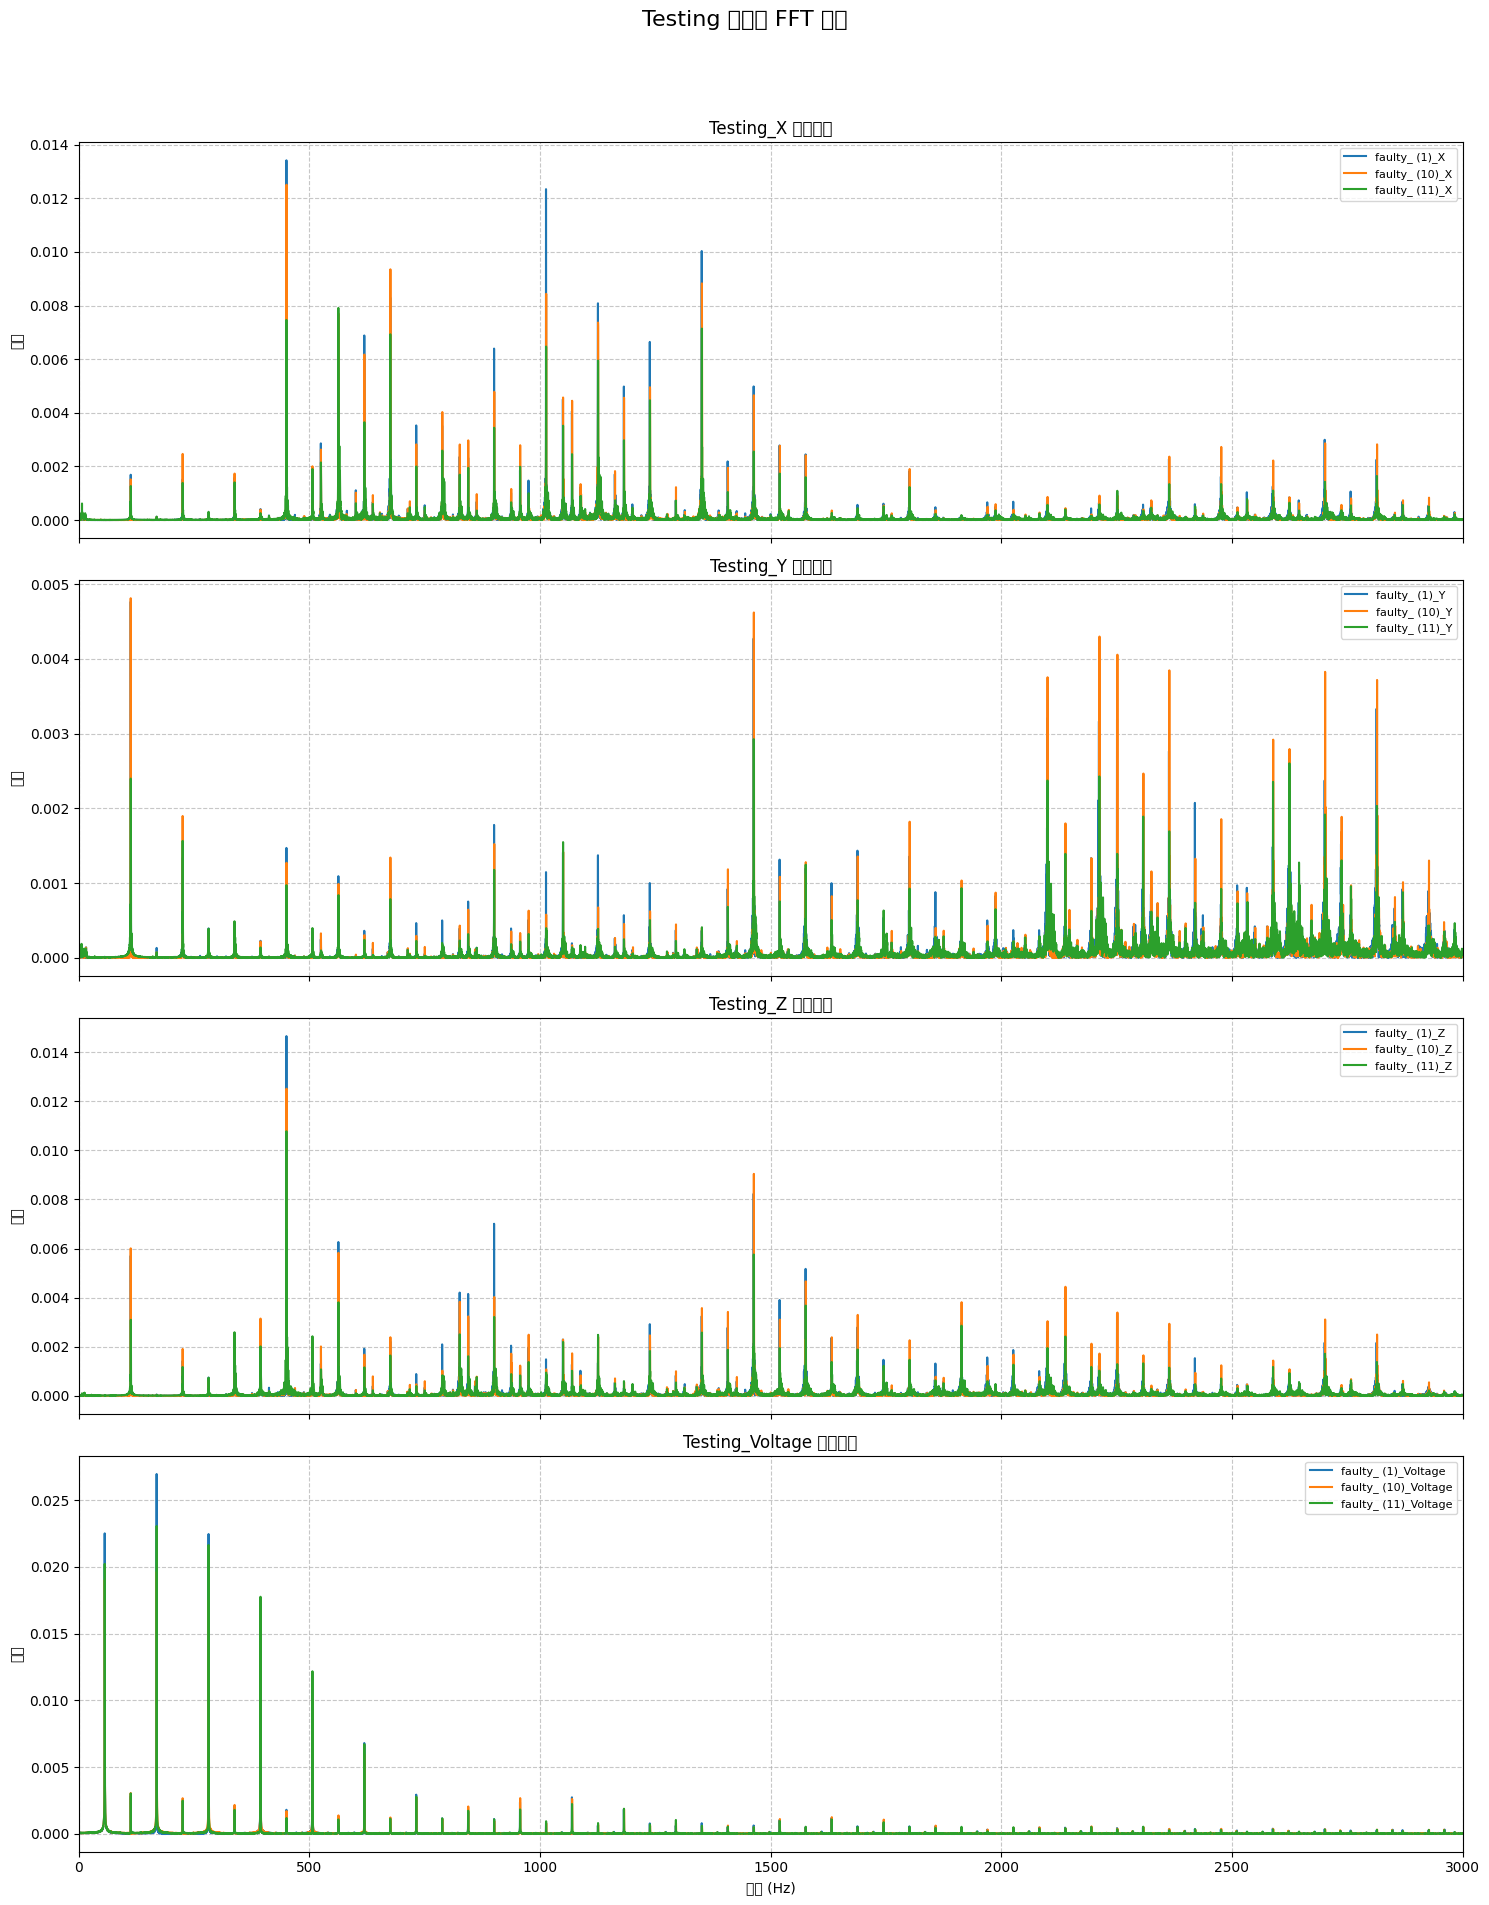

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm

# --- Start of Font Configuration Fix ---
# Install a Chinese font if not already present
# This command is for Debian/Ubuntu based systems like Colab
!sudo apt-get install -y fonts-wqy-zenhei > /dev/null 2>&1

# Remove existing font cache to ensure new fonts are detected
!rm -rf ~/.cache/matplotlib

# Rebuild font cache and set font properties for Chinese display
fm.findSystemFonts(fontpaths=None, fontext='ttf')

# Set font to 'WenQuanYi Zen Hei' or 'Arial Unicode MS' as a fallback, and 'sans-serif' as a generic family
# 'WenQuanYi Zen Hei' is a common open-source Chinese font.
# 'Arial Unicode MS' is often available in some environments.
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False # Solve the problem of '-' displaying as a square
print("Matplotlib 已配置中文字體。")
# --- End of Font Configuration Fix ---

# Define sampling parameters, consistent with previous FFT calculation
Fs = 6000  # Sampling frequency (Hz)
N = 30000  # Number of sampling points

# Create the frequency axis (same for all FFTs)
x_freq = np.fft.fftfreq(N, 1/Fs)[:N//2]

output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'

data_types = {
    'Testing_X': 'Testing_X_FFT_Df.csv',
    'Testing_Y': 'Testing_Y_FFT_Df.csv',
    'Testing_Z': 'Testing_Z_FFT_Df.csv',
    'Testing_Voltage': 'Testing_Voltage_FFT_Df.csv'
}

# Plotting loop for each data type
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 20), sharex=True)
fig.suptitle('Testing 數據的 FFT 頻譜', fontsize=16, y=0.98)

for i, (df_name, file_name) in enumerate(data_types.items()):
    file_path = os.path.join(output_dir, file_name)

    if os.path.exists(file_path):
        fft_df = pd.read_csv(file_path)

        ax = axes[i]
        # Plot the first 3 columns from each FFT DataFrame for visualization
        # This prevents overcrowding the plot if there are many columns
        num_cols_to_plot = min(3, fft_df.shape[1])
        for j in range(num_cols_to_plot):
            column_to_plot = fft_df.columns[j]
            ax.plot(x_freq, fft_df[column_to_plot], label=column_to_plot.replace('_FFT_Magnitude', ''))

        ax.set_title(f'{df_name} 頻譜振幅', fontsize=12)
        ax.set_ylabel('振幅', fontsize=10)
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(0, Fs/2) # Limit x-axis to Nyquist frequency
    else:
        print(f"錯誤：檔案 {file_path} 不存在。請確認 FFT 步驟已成功執行。\n")
        axes[i].set_title(f'{df_name} 頻譜振幅 (檔案未找到)', fontsize=12)
        axes[i].set_ylabel('振幅', fontsize=10)
        axes[i].text(0.5, 0.5, '數據不可用', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, fontsize=14, color='red')

axes[-1].set_xlabel('頻率 (Hz)', fontsize=10) # Set xlabel only for the bottom plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leaving space for suptitle
plt.show()


####Testing_FFT_Feature_x1~x5

In [ ]:
import pandas as pd
import numpy as np
import os

# Re-define necessary parameters and function if not globally available, for robustness.
# Fs, N, x_freq, base_freq, freq_window, harmonic_orders were defined in previous cells.
# The calculate_harmonic_features function was defined in cell 'ca6d1931'.
# For this cell to run independently, I will redefine it, but note it is already in the kernel's state.

Fs = 6000  # Sampling frequency (Hz)
N = 30000  # Number of sampling points
x_freq = np.fft.fftfreq(N, 1/Fs)[:N//2] # Create the frequency axis

base_freq = 117.0  # Rotating frequency (approximately 7000 RPM / 60)
freq_window = 1.0  # Frequency window around the harmonic
harmonic_orders = [1, 2, 3, 4, 5]
output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'

def calculate_harmonic_features(fft_df, df_name, freq_axis, base_freq, freq_window, harmonic_orders, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    """Calculates harmonic features (max amplitude around n*base_freq) for each column of an FFT DataFrame."""
    print(f"\n正在為 {df_name} 計算 {len(harmonic_orders)} 個諧波特徵 (基頻 {base_freq} Hz)...")
    harmonic_features_list = []

    if fft_df.empty:
        print(f"警告: {df_name} FFT DataFrame 為空，跳過諧波特徵計算。")
        return pd.DataFrame()

    for col in fft_df.columns:
        column_features = {'Column': col.replace('_FFT_Magnitude', '')}
        amplitudes = fft_df[col].values

        for n in harmonic_orders:
            target_freq = base_freq * n
            lower_bound = target_freq - freq_window
            upper_bound = target_freq + freq_window

            freq_indices = np.where((freq_axis >= lower_bound) & (freq_axis <= upper_bound))[0]

            max_harmonic_amplitude = np.nan
            if len(freq_indices) > 0:
                valid_indices = freq_indices[(freq_indices >= 0) & (freq_indices < len(amplitudes))]
                if len(valid_indices) > 0:
                    max_harmonic_amplitude = np.max(amplitudes[valid_indices])

            column_features[f'FFT_{n}X_Amplitude_{target_freq:.0f}Hz'] = max_harmonic_amplitude

        harmonic_features_list.append(column_features)

    harmonic_features_df = pd.DataFrame(harmonic_features_list)
    harmonic_features_df = harmonic_features_df.set_index('Column')

    output_file_path = f'{output_dir}{df_name}_Harmonic_Features_Df.csv'
    harmonic_features_df.to_csv(output_file_path, index=True)

    print(f"已成功為 {df_name} 計算諧波特徵並儲存到 {output_file_path}")
    print(f"{df_name}_Harmonic_Features_Df 的前5行：")
    display(harmonic_features_df.head())
    print(f"{df_name}_Harmonic_Features_Df 的維度：")
    print(harmonic_features_df.shape)
    return harmonic_features_df

# Load Testing FFT DataFrames
testing_X_fft_path = os.path.join(output_dir, 'Testing_X_FFT_Df.csv')
testing_Y_fft_path = os.path.join(output_dir, 'Testing_Y_FFT_Df.csv')
testing_Z_fft_path = os.path.join(output_dir, 'Testing_Z_FFT_Df.csv')
testing_voltage_fft_path = os.path.join(output_dir, 'Testing_Voltage_FFT_Df.csv')

Testing_X_FFT_Df = pd.read_csv(testing_X_fft_path)
Testing_Y_FFT_Df = pd.read_csv(testing_Y_fft_path)
Testing_Z_FFT_Df = pd.read_csv(testing_Z_fft_path)
Testing_Voltage_FFT_Df = pd.read_csv(testing_voltage_fft_path)

# Calculate Harmonic Features for Testing Data
Testing_X_Harmonic_Features_Df = calculate_harmonic_features(Testing_X_FFT_Df, 'Testing_X', x_freq, base_freq, freq_window, harmonic_orders)
Testing_Y_Harmonic_Features_Df = calculate_harmonic_features(Testing_Y_FFT_Df, 'Testing_Y', x_freq, base_freq, freq_window, harmonic_orders)
Testing_Z_Harmonic_Features_Df = calculate_harmonic_features(Testing_Z_FFT_Df, 'Testing_Z', x_freq, base_freq, freq_window, harmonic_orders)
Testing_Voltage_Harmonic_Features_Df = calculate_harmonic_features(Testing_Voltage_FFT_Df, 'Testing_Voltage', x_freq, base_freq, freq_window, harmonic_orders)

print("\n所有 Testing 數據的諧波特徵計算、儲存和驗證已完成。")


正在為 Testing_X 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Testing_X 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_X_Harmonic_Features_Df.csv
Testing_X_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
faulty_ (1)_X,0.000029,0.000024,0.000013,0.000195,0.000073
faulty_ (10)_X,0.000009,0.000014,0.000013,0.000094,0.000065
faulty_ (11)_X,0.000059,0.000024,0.000018,0.000104,0.000096
faulty_ (12)_X,0.000083,0.000027,0.000020,0.000065,0.000107
faulty_ (2)_X,0.000027,0.000021,0.000017,0.000132,0.000071


Testing_X_Harmonic_Features_Df 的維度：
(24, 5)

正在為 Testing_Y 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Testing_Y 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_Harmonic_Features_Df.csv
Testing_Y_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
faulty_ (1)_Y,0.000075,0.000017,0.000005,0.000031,0.000004
faulty_ (10)_Y,0.000032,0.000006,0.000004,0.000032,0.000002
faulty_ (11)_Y,0.000126,0.000016,0.000015,0.000023,0.000004
faulty_ (12)_Y,0.000149,0.000012,0.000020,0.000018,0.000007
faulty_ (2)_Y,0.000087,0.000018,0.000014,0.000029,0.000006


Testing_Y_Harmonic_Features_Df 的維度：
(24, 5)

正在為 Testing_Z 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Testing_Z 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Z_Harmonic_Features_Df.csv
Testing_Z_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
faulty_ (1)_Z,0.000092,0.000016,0.000034,0.000294,0.000028
faulty_ (10)_Z,0.000039,0.000010,0.000029,0.000318,0.000023
faulty_ (11)_Z,0.000155,0.000025,0.000075,0.000226,0.000021
faulty_ (12)_Z,0.000177,0.000020,0.000096,0.000167,0.000042
faulty_ (2)_Z,0.000108,0.000024,0.000109,0.000263,0.000026


Testing_Z_Harmonic_Features_Df 的維度：
(24, 5)

正在為 Testing_Voltage 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Testing_Voltage 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Voltage_Harmonic_Features_Df.csv
Testing_Voltage_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
faulty_ (1)_Voltage,0.000093,0.000027,0.000034,0.000035,0.000074
faulty_ (10)_Voltage,0.000053,0.000052,0.000050,0.000034,0.000027
faulty_ (11)_Voltage,0.000077,0.000064,0.000036,0.000022,0.000060
faulty_ (12)_Voltage,0.000042,0.000038,0.000027,0.000015,0.000052
faulty_ (2)_Voltage,0.000027,0.000028,0.000046,0.000045,0.000067


Testing_Voltage_Harmonic_Features_Df 的維度：
(24, 5)

所有 Testing 數據的諧波特徵計算、儲存和驗證已完成。


####Load_Testing_Data，X、Y、Z、V

In [ ]:
import pandas as pd
import numpy as np

# Define sampling parameters, consistent with previous FFT calculation
Fs = 6000  # Sampling frequency (Hz)
N = 30000  # Number of sampling points
x_freq = np.fft.fftfreq(N, 1/Fs)[:N//2] # Create the frequency axis

# Define base frequency and frequency window for harmonic feature calculation
base_freq = 117.0  # Rotating frequency (approximately 7000 RPM / 60)
freq_window = 1.0  # Frequency window around the harmonic
harmonic_orders = [1, 2, 3, 4, 5]
output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'

# --- New function to calculate harmonic features (1X, 2X, ..., 5X) ---
def calculate_harmonic_features(fft_df, df_name, freq_axis, base_freq, freq_window, harmonic_orders, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    """Calculates harmonic features (max amplitude around n*base_freq) for each column of an FFT DataFrame."""
    print(f"\n正在為 {df_name} 計算 {len(harmonic_orders)} 個諧波特徵 (基頻 {base_freq} Hz)...")
    harmonic_features_list = []

    if fft_df.empty:
        print(f"警告: {df_name} FFT DataFrame 為空，跳過諧波特徵計算。")
        return pd.DataFrame()

    for col in fft_df.columns:
        column_features = {'Column': col.replace('_FFT_Magnitude', '')}
        amplitudes = fft_df[col].values

        for n in harmonic_orders:
            target_freq = base_freq * n
            lower_bound = target_freq - freq_window
            upper_bound = target_freq + freq_window

            # Find frequency indices within the window
            freq_indices = np.where((freq_axis >= lower_bound) & (freq_axis <= upper_bound))[0]

            max_harmonic_amplitude = np.nan
            if len(freq_indices) > 0:
                # Ensure indices are within bounds of amplitudes array
                valid_indices = freq_indices[(freq_indices >= 0) & (freq_indices < len(amplitudes))]
                if len(valid_indices) > 0:
                    max_harmonic_amplitude = np.max(amplitudes[valid_indices])
                else:
                    print(f"警告: 在 {df_name} 的欄位 {col} 中，諧波 {n}X 的頻率範圍 [{lower_bound:.2f}, {upper_bound:.2f}] Hz 內沒有找到有效的振幅資料。")
            else:
                print(f"警告: 在 {df_name} 的欄位 {col} 中，諧波 {n}X 的頻率範圍 [{lower_bound:.2f}, {upper_bound:.2f}] Hz 內沒有找到頻率點。")

            column_features[f'FFT_{n}X_Amplitude_{target_freq:.0f}Hz'] = max_harmonic_amplitude

        harmonic_features_list.append(column_features)

    harmonic_features_df = pd.DataFrame(harmonic_features_list)
    harmonic_features_df = harmonic_features_df.set_index('Column')

    output_file_path = f'{output_dir}{df_name}_Harmonic_Features_Df.csv'
    harmonic_features_df.to_csv(output_file_path)

    print(f"已成功為 {df_name} 計算諧波特徵並儲存到 {output_file_path}")
    print(f"{df_name}_Harmonic_Features_Df 的前5行：")
    display(harmonic_features_df.head())
    print(f"{df_name}_Harmonic_Features_Df 的維度：")
    print(harmonic_features_df.shape)
    return harmonic_features_df

# --- Load Testing FFT DataFrames (if not already loaded) and calculate Harmonic features ---

# Assuming Testing_X_FFT_Df, Testing_Y_FFT_Df, Testing_Z_FFT_Df, Testing_Voltage_FFT_Df are already loaded.
# If not, add pd.read_csv lines here for each.

# Testing X Harmonic Features
testing_X_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_X_FFT_Df.csv'
Testing_X_FFT_Df = pd.read_csv(testing_X_fft_path)
Testing_X_Harmonic_Features_Df = calculate_harmonic_features(Testing_X_FFT_Df, 'Testing_X', x_freq, base_freq, freq_window, harmonic_orders)

# Testing Y Harmonic Features
testing_Y_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_FFT_Df.csv'
Testing_Y_FFT_Df = pd.read_csv(testing_Y_fft_path)
Testing_Y_Harmonic_Features_Df = calculate_harmonic_features(Testing_Y_FFT_Df, 'Testing_Y', x_freq, base_freq, freq_window, harmonic_orders)

# Testing Z Harmonic Features
testing_Z_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Z_FFT_Df.csv'
Testing_Z_FFT_Df = pd.read_csv(testing_Z_fft_path)
Testing_Z_Harmonic_Features_Df = calculate_harmonic_features(Testing_Z_FFT_Df, 'Testing_Z', x_freq, base_freq, freq_window, harmonic_orders)

# Testing Voltage Harmonic Features
testing_voltage_fft_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Voltage_FFT_Df.csv'
Testing_Voltage_FFT_Df = pd.read_csv(testing_voltage_fft_path)
Testing_Voltage_Harmonic_Features_Df = calculate_harmonic_features(Testing_Voltage_FFT_Df, 'Testing_Voltage', x_freq, base_freq, freq_window, harmonic_orders)


正在為 Testing_X 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Testing_X 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_X_Harmonic_Features_Df.csv
Testing_X_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
faulty_ (1)_X,0.000029,0.000024,0.000013,0.000195,0.000073
faulty_ (10)_X,0.000009,0.000014,0.000013,0.000094,0.000065
faulty_ (11)_X,0.000059,0.000024,0.000018,0.000104,0.000096
faulty_ (12)_X,0.000083,0.000027,0.000020,0.000065,0.000107
faulty_ (2)_X,0.000027,0.000021,0.000017,0.000132,0.000071


Testing_X_Harmonic_Features_Df 的維度：
(24, 5)

正在為 Testing_Y 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Testing_Y 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_Harmonic_Features_Df.csv
Testing_Y_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
faulty_ (1)_Y,0.000075,0.000017,0.000005,0.000031,0.000004
faulty_ (10)_Y,0.000032,0.000006,0.000004,0.000032,0.000002
faulty_ (11)_Y,0.000126,0.000016,0.000015,0.000023,0.000004
faulty_ (12)_Y,0.000149,0.000012,0.000020,0.000018,0.000007
faulty_ (2)_Y,0.000087,0.000018,0.000014,0.000029,0.000006


Testing_Y_Harmonic_Features_Df 的維度：
(24, 5)

正在為 Testing_Z 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Testing_Z 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Z_Harmonic_Features_Df.csv
Testing_Z_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
faulty_ (1)_Z,0.000092,0.000016,0.000034,0.000294,0.000028
faulty_ (10)_Z,0.000039,0.000010,0.000029,0.000318,0.000023
faulty_ (11)_Z,0.000155,0.000025,0.000075,0.000226,0.000021
faulty_ (12)_Z,0.000177,0.000020,0.000096,0.000167,0.000042
faulty_ (2)_Z,0.000108,0.000024,0.000109,0.000263,0.000026


Testing_Z_Harmonic_Features_Df 的維度：
(24, 5)

正在為 Testing_Voltage 計算 5 個諧波特徵 (基頻 117.0 Hz)...
已成功為 Testing_Voltage 計算諧波特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Voltage_Harmonic_Features_Df.csv
Testing_Voltage_Harmonic_Features_Df 的前5行：


,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,
faulty_ (1)_Voltage,0.000093,0.000027,0.000034,0.000035,0.000074
faulty_ (10)_Voltage,0.000053,0.000052,0.000050,0.000034,0.000027
faulty_ (11)_Voltage,0.000077,0.000064,0.000036,0.000022,0.000060
faulty_ (12)_Voltage,0.000042,0.000038,0.000027,0.000015,0.000052
faulty_ (2)_Voltage,0.000027,0.000028,0.000046,0.000045,0.000067


Testing_Voltage_Harmonic_Features_Df 的維度：
(24, 5)


####Testing_X_Y_Z_V_Features_df

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
import math
import os

# Define a function to calculate features
def calculate_statistical_features(df, df_name, output_dir='/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'):
    print(f"\n正在為 {df_name} 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...")
    features_list = []

    if df.empty:
        print(f"警告: {df_name} 為空，跳過統計特徵計算。")
        return pd.DataFrame()

    for col in df.columns:
        data = df[col]

        # Calculate features
        col_mean = data.mean()
        col_std = data.std()
        col_rms = math.sqrt(data.pow(2).mean()) # RMS = sqrt(mean of squares)
        col_kurtosis = kurtosis(data)
        col_skewness = skew(data)

        features_list.append({
            'Column': col,
            'RMS': col_rms,
            'Mean': col_mean,
            'Kurtosis': col_kurtosis,
            'Std': col_std,
            'Skewness': col_skewness
        })

    features_df = pd.DataFrame(features_list)
    features_df = features_df.set_index('Column')

    desired_column_order = ['RMS', 'Mean', 'Kurtosis', 'Std', 'Skewness']
    features_df = features_df[desired_column_order]

    output_file_path = f'{output_dir}{df_name}_Features_df.csv'
    features_df.to_csv(output_file_path)

    print(f"已成功為 {df_name} 計算統計特徵並儲存到 {output_file_path}")
    print(f"{df_name}_Features_df 的前5行：")
    display(features_df.head())
    print(f"{df_name}_Features_df 的維度：")
    print(features_df.shape)
    return features_df

# --- Process Testing X data ---
testing_X_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_X.csv'
Testing_X_df = pd.read_csv(testing_X_path)
Testing_X_Features_df = calculate_statistical_features(Testing_X_df, 'Testing_X')

# --- Process Testing Y data ---
testing_Y_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Y.csv'
Testing_Y_df = pd.read_csv(testing_Y_path)
Testing_Y_Features_df = calculate_statistical_features(Testing_Y_df, 'Testing_Y')

# --- Process Testing Z data ---
testing_Z_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Z.csv'
Testing_Z_df = pd.read_csv(testing_Z_path)
Testing_Z_Features_df = calculate_statistical_features(Testing_Z_df, 'Testing_Z')

# --- Process Testing Voltage data ---
testing_voltage_path = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Merge_Clean_Table_Voltage.csv'
Testing_Voltage_df = pd.read_csv(testing_voltage_path)
Testing_Voltage_Features_df = calculate_statistical_features(Testing_Voltage_df, 'Testing_Voltage')



正在為 Testing_X 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Testing_X 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_X_Features_df.csv
Testing_X_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
faulty_ (1)_X,0.026646,0.000142,2.084052,0.026646,0.056510
faulty_ (10)_X,0.025780,0.000125,1.724572,0.025781,-0.094391
faulty_ (11)_X,0.023569,0.000138,1.244287,0.023569,-0.120714
faulty_ (12)_X,0.020810,0.000130,0.547267,0.020810,0.013970
faulty_ (2)_X,0.026708,0.000131,2.050733,0.026708,0.043561


Testing_X_Features_df 的維度：
(24, 5)

正在為 Testing_Y 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Testing_Y 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_Features_df.csv
Testing_Y_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
faulty_ (1)_Y,0.014519,0.000046,0.592574,0.014519,0.160231
faulty_ (10)_Y,0.014628,-0.000010,0.640736,0.014628,0.200797
faulty_ (11)_Y,0.013769,-0.000036,0.418839,0.013770,0.142388
faulty_ (12)_Y,0.012330,-0.000011,0.185134,0.012331,0.142441
faulty_ (2)_Y,0.014687,-0.000007,0.635467,0.014688,0.177005


Testing_Y_Features_df 的維度：
(24, 5)

正在為 Testing_Z 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Testing_Z 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Z_Features_df.csv
Testing_Z_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
faulty_ (1)_Z,0.022568,0.000181,0.259391,0.022568,0.229091
faulty_ (10)_Z,0.021554,0.000178,-0.005777,0.021553,0.196600
faulty_ (11)_Z,0.022147,0.000191,0.137552,0.022147,0.107620
faulty_ (12)_Z,0.025886,0.000186,-0.095884,0.025885,0.176584
faulty_ (2)_Z,0.022796,0.000190,0.236386,0.022795,0.244856


Testing_Z_Features_df 的維度：
(24, 5)

正在為 Testing_Voltage 計算統計特徵 (RMS, Mean, Kurtosis, Std, Skewness)...
已成功為 Testing_Voltage 計算統計特徵並儲存到 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Voltage_Features_df.csv
Testing_Voltage_Features_df 的前5行：


,RMS,Mean,Kurtosis,Std,Skewness
Column,,,,,
faulty_ (1)_Voltage,0.037091,0.004359,4.443277,0.036835,0.513238
faulty_ (10)_Voltage,0.037275,0.004272,4.430403,0.037030,0.506366
faulty_ (11)_Voltage,0.037068,0.004284,4.486167,0.036820,0.512237
faulty_ (12)_Voltage,0.037270,0.004280,4.540165,0.037024,0.511813
faulty_ (2)_Voltage,0.037150,0.004324,4.440085,0.036898,0.506631


Testing_Voltage_Features_df 的維度：
(24, 5)


####Testing_合併Feature和FFT_Feature

In [ ]:
import pandas as pd
import os

output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'
os.makedirs(output_dir, exist_ok=True)

dimensions = ['X', 'Y', 'Z', 'Voltage']

# Dictionary to store combined feature dataframes for each dimension
Testing_Combined_Features_Dict = {}

for dim in dimensions:
    print(f"\n--- \u6b63\u5728\u7d44\u5408 Testing {dim} \u6578\u64da\u7684\u7d71\u8a08\u7279\u5fb5\u548c\u8ae7\u6ce2\u7279\u5fb5 ---")

    # Define file paths for Statistical features and Harmonic features
    statistical_features_path = os.path.join(output_dir, f'Testing_{dim}_Features_df.csv')
    harmonic_features_path = os.path.join(output_dir, f'Testing_{dim}_Harmonic_Features_Df.csv')

    # Load the feature DataFrames
    try:
        statistical_features_df = pd.read_csv(statistical_features_path, index_col='Column')
        harmonic_features_df = pd.read_csv(harmonic_features_path, index_col='Column')
    except FileNotFoundError as e:
        print(f"\u932f\u8aa4: \u627e\u4e0d\u5230\u6587\u4ef6 {e.filename}\u3002\u8acb\u78ba\u8a8d\u6240\u6709\u7d71\u8a08\u7279\u5fb5\u548c\u8ae7\u6ce2\u7279\u5fb5\u5df2\u6210\u529f\u7522\u751f\u4e26\u5132\u5b58\u3002")
        continue
    except Exception as e:
        print(f"\u8f09\u5165\u6587\u4ef6\u6642\u767c\u751f\u672a\u77e5\u932f\u8aa4: {e}")
        continue

    # Combine the two feature DataFrames horizontally
    # Ensure both DataFrames have the same index for proper alignment
    if not statistical_features_df.index.equals(harmonic_features_df.index):
        print(f"\u8b66\u544a: Testing {dim} \u7684\u7d71\u8a08\u7279\u5fb5\u548c\u8ae7\u6ce2\u7279\u5fb5\u7684\u7d22\u5f15\u4e0d\u5339\u914d\u3002\u5617\u8a66\u6309\u7d22\u5f15\u5408\u4f75\u3002")
        # Use outer join to keep all indices and fill NaNs if necessary
        combined_features_df = pd.merge(
            statistical_features_df,
            harmonic_features_df,
            left_index=True,
            right_index=True,
            how='outer'
        )
    else:
        combined_features_df = pd.concat([statistical_features_df, harmonic_features_df], axis=1)

    # Store the combined DataFrame in the dictionary
    Testing_Combined_Features_Dict[dim] = combined_features_df

    # Assign a name to the combined DataFrame in global scope for potential future use
    df_name = f'Testing_{dim}_Combined_Features_Df'
    globals()[df_name] = combined_features_df

    # Save the combined DataFrame to a CSV file
    output_file_name = f'{df_name}.csv'
    output_file_path = os.path.join(output_dir, output_file_name)
    combined_features_df.to_csv(output_file_path, index=True) # Keep the 'Column' as index in CSV

    print(f"\u5df2\u6210\u529f\u7d44\u5408\u4e26\u5132\u5b58 Testing {dim} \u7684\u7279\u5fb5\u81f3 {output_file_path}")
    print(f"{df_name} \u7684\u5f62\u72c0: {combined_features_df.shape}")
    print(f"{df_name} \u7684\u524d5\u884c:")
    display(combined_features_df.head())

print("\n\u6240\u6709 Testing \u6578\u64da\u7684\u7279\u5fb5\u7d44\u5408\u548c\u5132\u5b58\u5df2\u5b8c\u6210\u3002")



--- 正在組合 Testing X 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Testing X 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_X_Combined_Features_Df.csv
Testing_X_Combined_Features_Df 的形狀: (24, 10)
Testing_X_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
faulty_ (1)_X,0.026646,0.000142,2.084052,0.026646,0.056510,0.000029,0.000024,0.000013,0.000195,0.000073
faulty_ (10)_X,0.025780,0.000125,1.724572,0.025781,-0.094391,0.000009,0.000014,0.000013,0.000094,0.000065
faulty_ (11)_X,0.023569,0.000138,1.244287,0.023569,-0.120714,0.000059,0.000024,0.000018,0.000104,0.000096
faulty_ (12)_X,0.020810,0.000130,0.547267,0.020810,0.013970,0.000083,0.000027,0.000020,0.000065,0.000107
faulty_ (2)_X,0.026708,0.000131,2.050733,0.026708,0.043561,0.000027,0.000021,0.000017,0.000132,0.000071



--- 正在組合 Testing Y 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Testing Y 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_Combined_Features_Df.csv
Testing_Y_Combined_Features_Df 的形狀: (24, 10)
Testing_Y_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
faulty_ (1)_Y,0.014519,0.000046,0.592574,0.014519,0.160231,0.000075,0.000017,0.000005,0.000031,0.000004
faulty_ (10)_Y,0.014628,-0.000010,0.640736,0.014628,0.200797,0.000032,0.000006,0.000004,0.000032,0.000002
faulty_ (11)_Y,0.013769,-0.000036,0.418839,0.013770,0.142388,0.000126,0.000016,0.000015,0.000023,0.000004
faulty_ (12)_Y,0.012330,-0.000011,0.185134,0.012331,0.142441,0.000149,0.000012,0.000020,0.000018,0.000007
faulty_ (2)_Y,0.014687,-0.000007,0.635467,0.014688,0.177005,0.000087,0.000018,0.000014,0.000029,0.000006



--- 正在組合 Testing Z 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Testing Z 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Z_Combined_Features_Df.csv
Testing_Z_Combined_Features_Df 的形狀: (24, 10)
Testing_Z_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
faulty_ (1)_Z,0.022568,0.000181,0.259391,0.022568,0.229091,0.000092,0.000016,0.000034,0.000294,0.000028
faulty_ (10)_Z,0.021554,0.000178,-0.005777,0.021553,0.196600,0.000039,0.000010,0.000029,0.000318,0.000023
faulty_ (11)_Z,0.022147,0.000191,0.137552,0.022147,0.107620,0.000155,0.000025,0.000075,0.000226,0.000021
faulty_ (12)_Z,0.025886,0.000186,-0.095884,0.025885,0.176584,0.000177,0.000020,0.000096,0.000167,0.000042
faulty_ (2)_Z,0.022796,0.000190,0.236386,0.022795,0.244856,0.000108,0.000024,0.000109,0.000263,0.000026



--- 正在組合 Testing Voltage 數據的統計特徵和諧波特徵 ---
已成功組合並儲存 Testing Voltage 的特徵至 /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Voltage_Combined_Features_Df.csv
Testing_Voltage_Combined_Features_Df 的形狀: (24, 10)
Testing_Voltage_Combined_Features_Df 的前5行:


,RMS,Mean,Kurtosis,Std,Skewness,FFT_1X_Amplitude_117Hz,FFT_2X_Amplitude_234Hz,FFT_3X_Amplitude_351Hz,FFT_4X_Amplitude_468Hz,FFT_5X_Amplitude_585Hz
Column,,,,,,,,,,
faulty_ (1)_Voltage,0.037091,0.004359,4.443277,0.036835,0.513238,0.000093,0.000027,0.000034,0.000035,0.000074
faulty_ (10)_Voltage,0.037275,0.004272,4.430403,0.037030,0.506366,0.000053,0.000052,0.000050,0.000034,0.000027
faulty_ (11)_Voltage,0.037068,0.004284,4.486167,0.036820,0.512237,0.000077,0.000064,0.000036,0.000022,0.000060
faulty_ (12)_Voltage,0.037270,0.004280,4.540165,0.037024,0.511813,0.000042,0.000038,0.000027,0.000015,0.000052
faulty_ (2)_Voltage,0.037150,0.004324,4.440085,0.036898,0.506631,0.000027,0.000028,0.000046,0.000045,0.000067



所有 Testing 數據的特徵組合和儲存已完成。


##3.1正規化Z-Score

##合併healthy ok

In [50]:
import pandas as pd

# 定義文件路徑
file_paths = {
    'X': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_X_Combined_Features_Df.csv",
    'Y': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Y_Combined_Features_Df.csv",
    'Z': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Z_Combined_Features_Df.csv",
    'Voltage': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Voltage_Combined_Features_Df.csv"
}

# 讀取每個文件並處理
dfs = []
for prefix, file_path in file_paths.items():
    df = pd.read_csv(file_path)

    # 刪除Column欄位
    if 'Column' in df.columns:
        df = df.drop(columns=['Column'])

    # 為10個特徵列加上前綴
    feature_columns = [col for col in df.columns]  # 所有列都是特徵列（除了已刪除的Column）
    df = df.rename(columns={col: f"{prefix}_{col}" for col in feature_columns})

    dfs.append(df)
    print(f"{prefix}文件: {len(df)} 行, {len(df.columns)} 列")

# 橫向合併（axis=1）
combined_df = pd.concat(dfs, axis=1)

print(f"\n合併後的表格: {len(combined_df)} 行 x {len(combined_df.columns)} 列")

# 顯示前幾行以確認
print("\n前5行預覽:")
print(combined_df.head())

# 保存合併後的數據
output_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Combined_Features_Df.csv"
combined_df.to_csv(output_path, index=False)
print(f"\n已保存到: {output_path}")



X文件: 48 行, 10 列
Y文件: 48 行, 10 列
Z文件: 48 行, 10 列
Voltage文件: 48 行, 10 列

合併後的表格: 48 行 x 40 列

前5行預覽:
      X_RMS    X_Mean  X_Kurtosis     X_Std  X_Skewness  \
0  0.020941  0.000187    0.552959  0.020941   -0.031832   
1  0.023462  0.000175    0.111741  0.023461   -0.069489   
2  0.021899  0.000155    0.371541  0.021899   -0.007324   
3  0.023782  0.000138    0.376164  0.023782   -0.037927   
4  0.021763  0.000130    0.458398  0.021763   -0.079878   

   X_FFT_1X_Amplitude_117Hz  X_FFT_2X_Amplitude_234Hz  \
0                  0.000042                  0.000031   
1                  0.000029                  0.000022   
2                  0.000024                  0.000037   
3                  0.000032                  0.000019   
4                  0.000034                  0.000031   

   X_FFT_3X_Amplitude_351Hz  X_FFT_4X_Amplitude_468Hz  \
0                  0.000038                  0.000129   
1                  0.000027                  0.000076   
2                  0.000038     

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

# --- 步驟 1: 掛載 Google Drive (如果您在 Colab 環境) ---
# 🚨 再次提醒，如果還沒掛載，請手動執行這行程式碼
# drive.mount('/content/drive')
print("請確保 Google Drive 已經掛載到 /content/drive/")


# --- 步驟 2: 定義檔案路徑與標籤 ---
file_paths = {
    'X_Axis': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_X_Combined_Features_Df.csv',
    'Y_Axis': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Y_Combined_Features_Df.csv',
    'Z_Axis': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Z_Combined_Features_Df.csv',
    # 這是 48x6 的檔案
    'Voltage': '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Voltage_Features_df.csv'
}

# --- 步驟 3: 載入數據並加上前綴 (Prefix) 進行水平合併 ---

final_merged_df = None # 用於儲存最終合併結果

print("\n--- 開始處理與水平合併檔案 (保留所有特徵) ---")
for axis_name, path in file_paths.items():
    try:
        df = pd.read_csv(path)

        # 🚨 關鍵步驟：為每個特徵欄位加上軸向/來源的前綴
        # 例如：RMS 變成 X_Axis_RMS，避免不同軸向特徵名稱重複
        new_columns = {col: f'{axis_name}_{col}' for col in df.columns}
        df.rename(columns=new_columns, inplace=True)

        print(f"成功載入 {axis_name} 數據，維度: {df.shape}")

        # 進行水平合併
        if final_merged_df is None:
            # 第一個 DataFrame 作為基礎
            final_merged_df = df
        else:
            # 依賴索引 (index) 進行水平合併 (axis=1)
            # 由於所有檔案的行數都是 48，它們會依序對齊
            final_merged_df = pd.concat([final_merged_df, df], axis=1)

    except FileNotFoundError:
        print(f"錯誤：找不到檔案路徑: {path}")

# 最終合併後的 DataFrame
healthy_combined_df_wide = final_merged_df

# --- 步驟 4: 檢查最終結果 ---
print("\n--- 水平合併結果驗證 ---")
print(f"最終訓練集（正樣本）維度: {healthy_combined_df_wide.shape}")

# 預期維度: 48 筆樣本， 3*10 + 1*6 = 36 欄
print(f"✅ 最終特徵總數應為 36 欄。")

# 打印前幾行數據，確認結構和新的欄位名稱
print("\n最終水平合併數據 (前 5 筆):")
print(healthy_combined_df_wide.head())

print("\n最終數據集的欄位總數和部分欄位名稱 (確認 X, Y, Z, Voltage 特徵皆已包含):")
print(f"欄位總數: {len(healthy_combined_df_wide.columns)}")

# 打印前 5 個欄位 (X-Axis) 和最後 5 個欄位 (Voltage)
print(healthy_combined_df_wide.columns.tolist()[:5] + ['...'] + healthy_combined_df_wide.columns.tolist()[-5:])

請確保 Google Drive 已經掛載到 /content/drive/

--- 開始處理與水平合併檔案 (保留所有特徵) ---
成功載入 X_Axis 數據，維度: (48, 11)
成功載入 Y_Axis 數據，維度: (48, 11)
成功載入 Z_Axis 數據，維度: (48, 11)
成功載入 Voltage 數據，維度: (48, 6)

--- 水平合併結果驗證 ---
最終訓練集（正樣本）維度: (48, 39)
✅ 最終特徵總數應為 36 欄。

最終水平合併數據 (前 5 筆):
       X_Axis_Column  X_Axis_RMS  X_Axis_Mean  X_Axis_Kurtosis  X_Axis_Std  \
0  202409302014_01_X    0.020941     0.000187         0.552959    0.020941   
1  202409302014_02_X    0.023462     0.000175         0.111741    0.023461   
2  202409302014_03_X    0.021899     0.000155         0.371541    0.021899   
3  202409302014_04_X    0.023782     0.000138         0.376164    0.023782   
4  202409302014_05_X    0.021763     0.000130         0.458398    0.021763   

   X_Axis_Skewness  X_Axis_FFT_1X_Amplitude_117Hz  \
0        -0.031832                       0.000042   
1        -0.069489                       0.000029   
2        -0.007324                       0.000024   
3        -0.037927                       0.000032   
4       

##合併fauty ok


In [52]:
import pandas as pd

# 定義文件路徑
file_paths = {
    'X': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_X_Combined_Features_Df.csv",
    'Y': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Y_Combined_Features_Df.csv",
    'Z': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Z_Combined_Features_Df.csv",
    'Voltage': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Voltage_Combined_Features_Df.csv"
}

# 讀取每個文件並處理
dfs = []
for prefix, file_path in file_paths.items():
    df = pd.read_csv(file_path)

    # 刪除Column欄位
    if 'Column' in df.columns:
        df = df.drop(columns=['Column'])

    # 為10個特徵列加上前綴
    feature_columns = [col for col in df.columns]  # 所有列都是特徵列（除了已刪除的Column）
    df = df.rename(columns={col: f"{prefix}_{col}" for col in feature_columns})

    dfs.append(df)
    print(f"{prefix}文件: {len(df)} 行, {len(df.columns)} 列")

# 橫向合併（axis=1）
combined_df = pd.concat(dfs, axis=1)

print(f"\n合併後的表格: {len(combined_df)} 行 x {len(combined_df.columns)} 列")

# 顯示前幾行以確認
print("\n前5行預覽:")
print(combined_df.head())

# 保存合併後的數據
output_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Fauty_Combined_Features_Df.csv"
combined_df.to_csv(output_path, index=False)
print(f"\n已保存到: {output_path}")



X文件: 48 行, 10 列
Y文件: 48 行, 10 列
Z文件: 48 行, 10 列
Voltage文件: 48 行, 10 列

合併後的表格: 48 行 x 40 列

前5行預覽:
      X_RMS    X_Mean  X_Kurtosis     X_Std  X_Skewness  \
0  0.023724  0.000137    0.587321  0.023724   -0.229660   
1  0.022344  0.000169    1.406470  0.022343   -0.524710   
2  0.023776  0.000143    1.327990  0.023776   -0.464774   
3  0.024480  0.000129    1.213258  0.024480   -0.387796   
4  0.026405  0.000151    1.488870  0.026405   -0.191874   

   X_FFT_1X_Amplitude_117Hz  X_FFT_2X_Amplitude_234Hz  \
0                  0.000062                  0.000012   
1                  0.000047                  0.000027   
2                  0.000043                  0.000020   
3                  0.000033                  0.000020   
4                  0.000022                  0.000020   

   X_FFT_3X_Amplitude_351Hz  X_FFT_4X_Amplitude_468Hz  \
0                  0.000009                  0.000043   
1                  0.000018                  0.000052   
2                  0.000009     

#合併2張大表OK

In [58]:
import pandas as pd

# 定義文件路徑
file_paths = [
    "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Fauty_Combined_Features_Df.csv",
    "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Combined_Features_Df.csv"
]

# 讀取兩個文件並添加標籤
dfs = []
labels = [0, 1]  # 0=Faulty, 1=Healthy
label_names = ['Faulty', 'Healthy']  # 用於顯示

for i, file_path in enumerate(file_paths):
    df = pd.read_csv(file_path)
    # 添加標籤列識別來源
    df['Label'] = labels[i]
    dfs.append(df)
    print(f"文件 {i+1}: {len(df)} 行 x {len(df.columns)} 列 - {file_path.split('/')[-1]} (標籤: {labels[i]}={label_names[i]})")

# 垂直合併（axis=0）
merged_df = pd.concat(dfs, axis=0, ignore_index=True)

# 將Label列移到最前面
cols = ['Label'] + [col for col in merged_df.columns if col != 'Label']
merged_df = merged_df[cols]

print(f"\n合併後的表格: {len(merged_df)} 行 x {len(merged_df.columns)} 列")

# 顯示前幾行和後幾行以確認
print("\n前5行預覽:")
print(merged_df.head())
print("\n後5行預覽:")
print(merged_df.tail())

# 保存合併後的數據
output_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Combined_Features_Df.csv"
merged_df.to_csv(output_path, index=False)
print(f"\n已保存到: {output_path}")



文件 1: 48 行 x 41 列 - Fauty_Combined_Features_Df.csv (標籤: 0=Faulty)
文件 2: 48 行 x 41 列 - Healthy_Combined_Features_Df.csv (標籤: 1=Healthy)

合併後的表格: 96 行 x 41 列

前5行預覽:
   Label     X_RMS    X_Mean  X_Kurtosis     X_Std  X_Skewness  \
0      0  0.023724  0.000137    0.587321  0.023724   -0.229660   
1      0  0.022344  0.000169    1.406470  0.022343   -0.524710   
2      0  0.023776  0.000143    1.327990  0.023776   -0.464774   
3      0  0.024480  0.000129    1.213258  0.024480   -0.387796   
4      0  0.026405  0.000151    1.488870  0.026405   -0.191874   

   X_FFT_1X_Amplitude_117Hz  X_FFT_2X_Amplitude_234Hz  \
0                  0.000062                  0.000012   
1                  0.000047                  0.000027   
2                  0.000043                  0.000020   
3                  0.000033                  0.000020   
4                  0.000022                  0.000020   

   X_FFT_3X_Amplitude_351Hz  X_FFT_4X_Amplitude_468Hz  \
0                  0.000009            

##合併testing ok


In [65]:
import pandas as pd
import os

# 定義文件路徑
file_paths = {
    'Y1': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_Combined_Features_Df.csv",
    'Y2': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_Combined_Features_Df.csv",
    'Z': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Z_Combined_Features_Df.csv",
    'X': "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_X_Combined_Features_Df.csv"
}

print("="*60)
print("合併Testing數據文件")
print("="*60)

dfs = []
for prefix, file_path in file_paths.items():
    print(f"\n讀取文件: {file_path}")

    # 檢查文件是否存在
    if not os.path.exists(file_path):
        print(f"警告: 文件不存在 - {file_path}")
        continue

    # 讀取CSV文件
    df = pd.read_csv(file_path)
    print(f"原始形狀: {df.shape}")
    print(f"原始欄位: {df.columns.tolist()}")

    # 刪除Column欄位（如果存在）
    if 'Column' in df.columns:
        df = df.drop(columns=['Column'])
        print(f"已刪除Column欄位")

    # 給特徵加上前綴
    feature_columns = [col for col in df.columns]
    df = df.rename(columns={col: f"{prefix}_{col}" for col in feature_columns})
    print(f"已加上前綴: {prefix}_")
    print(f"更新後欄位: {df.columns.tolist()[:5]}...")  # 顯示前5個欄位

    dfs.append(df)

# 水平合併所有DataFrame
if dfs:
    combined_df = pd.concat(dfs, axis=1)
    print(f"\n合併後形狀: {combined_df.shape}")

    print(f"最終形狀: {combined_df.shape}")

    # 保存合併後的數據
    output_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Combined_Features_Df.csv"
    combined_df.to_csv(output_path, index=False)
    print(f"\n合併後的數據已保存到: {output_path}")
    print(f"數據形狀: {combined_df.shape[0]}行 x {combined_df.shape[1]}列")

    # 顯示前幾行數據
    print(f"\n前5行數據預覽:")
    print(combined_df.head())

else:
    print("\n錯誤: 沒有成功讀取任何文件")

print("\n完成！")



合併Testing數據文件

讀取文件: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_Combined_Features_Df.csv
原始形狀: (24, 11)
原始欄位: ['Column', 'RMS', 'Mean', 'Kurtosis', 'Std', 'Skewness', 'FFT_1X_Amplitude_117Hz', 'FFT_2X_Amplitude_234Hz', 'FFT_3X_Amplitude_351Hz', 'FFT_4X_Amplitude_468Hz', 'FFT_5X_Amplitude_585Hz']
已刪除Column欄位
已加上前綴: Y1_
更新後欄位: ['Y1_RMS', 'Y1_Mean', 'Y1_Kurtosis', 'Y1_Std', 'Y1_Skewness']...

讀取文件: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Y_Combined_Features_Df.csv
原始形狀: (24, 11)
原始欄位: ['Column', 'RMS', 'Mean', 'Kurtosis', 'Std', 'Skewness', 'FFT_1X_Amplitude_117Hz', 'FFT_2X_Amplitude_234Hz', 'FFT_3X_Amplitude_351Hz', 'FFT_4X_Amplitude_468Hz', 'FFT_5X_Amplitude_585Hz']
已刪除Column欄位
已加上前綴: Y2_
更新後欄位: ['Y2_RMS', 'Y2_Mean', 'Y2_Kurtosis', 'Y2_Std', 'Y2_Skewness']...

讀取文件: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Testing_Z_Combined_Features_Df.csv
原始形狀: (24, 11)
原始欄位: ['Column', 'RMS', 'Mean', 'Kurtosis', 'Std', 'Skewness', 'F

####**Healthy正規化的表合併

In [ ]:
import pandas as pd
import re
import os

# Initialize an empty list to store processed DataFrames
processed_dfs = []

# Define a list of dimensions
dimensions = ['X', 'Y', 'Z', 'Voltage']

# Dictionary to hold the normalized DataFrames (assuming they are already loaded as per previous steps)
healthy_normalized_dfs = {
    'X': Healthy_X_Combined_Features_Df_normalized,
    'Y': Healthy_Y_Combined_Features_Df_normalized,
    'Z': Healthy_Z_Combined_Features_Df_normalized,
    'Voltage': Healthy_Voltage_Combined_Features_Df_normalized
}

print("--- Processing and combining normalized Healthy DataFrames ---")

for dim, df in healthy_normalized_dfs.items():
    print(f"\nProcessing Healthy {dim} data...")

    # 1. Reset its index. This will convert the 'Column' index into a regular column.
    df_processed = df.reset_index()

    # 2. Extract the base file ID (e.g., '202409302014_01' from '202409302014_01_X')
    # Use regex to handle 'faulty_ (1)' or 'healthy_ (1)' pattern if present in Testing data, or just the filename for Training data.
    # For Healthy, the pattern is usually 'YYYYMMDDHHMM_NN_DIM'
    # The goal is to get 'YYYYMMDDHHMM_NN'
    def extract_base_id(col_name):
        match = re.match(r'(.+_\d{2})_.*', col_name)
        if match:
            return match.group(1)
        # Handle cases like 'healthy_ (1)_X'
        match_paren = re.match(r'(healthy_ \(\d+\))_.*', col_name)
        if match_paren:
            return match_paren.group(1).replace(' ', '')
        return col_name.split('_')[-1] # Fallback if no pattern matches, but typically one should

    df_processed['Base_File_ID'] = df_processed['Column'].apply(extract_base_id)

    # 3. Create a dictionary to rename the feature columns with dimension prefixes
    # The 'Column' column needs to be dropped or handled separately before renaming other features
    rename_cols = {col: f"{dim}_{col}" for col in df_processed.columns if col not in ['Column', 'Base_File_ID']}

    # Rename feature columns
    df_processed = df_processed.rename(columns=rename_cols)

    # Drop the original 'Column' column
    df_processed = df_processed.drop(columns=['Column'])

    # 4. Set the 'Base_File_ID' column as the new index
    df_processed = df_processed.set_index('Base_File_ID')

    # Append the processed DataFrame to the list
    processed_dfs.append(df_processed)

# 5. Concatenate all DataFrames in the processed_dfs list horizontally
# Using 'outer' join to ensure all Base_File_IDs are included, if they somehow differ
Healthy_Normalized_Combined_Table = pd.concat(processed_dfs, axis=1, join='outer')

# Define output directory and file path
output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, 'Healthy_Normalized_Combined_Table.csv')

# Save the combined DataFrame to CSV
Healthy_Normalized_Combined_Table.to_csv(output_file_path, index=True)
print(f"\nHealthy_Normalized_Combined_Table saved to: {output_file_path}")

# Display the shape and head of the final DataFrame
print(f"\nHealthy_Normalized_Combined_Table shape: {Healthy_Normalized_Combined_Table.shape}")
print("Healthy_Normalized_Combined_Table head:")
display(Healthy_Normalized_Combined_Table.head())


--- Processing and combining normalized Healthy DataFrames ---

Processing Healthy X data...

Processing Healthy Y data...

Processing Healthy Z data...

Processing Healthy Voltage data...

Healthy_Normalized_Combined_Table saved to: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Healthy_Normalized_Combined_Table.csv

Healthy_Normalized_Combined_Table shape: (48, 40)
Healthy_Normalized_Combined_Table head:


,X_RMS,X_Mean,X_Kurtosis,X_Std,X_Skewness,X_FFT_1X_Amplitude_117Hz,X_FFT_2X_Amplitude_234Hz,X_FFT_3X_Amplitude_351Hz,X_FFT_4X_Amplitude_468Hz,X_FFT_5X_Amplitude_585Hz,...,Voltage_RMS,Voltage_Mean,Voltage_Kurtosis,Voltage_Std,Voltage_Skewness,Voltage_FFT_1X_Amplitude_117Hz,Voltage_FFT_2X_Amplitude_234Hz,Voltage_FFT_3X_Amplitude_351Hz,Voltage_FFT_4X_Amplitude_468Hz,Voltage_FFT_5X_Amplitude_585Hz
Base_File_ID,,,,,,,,,,,,,,,,,,,,,
202409302014_01,0.484987,3.531775,1.514804,0.484801,-0.795464,2.423300,1.316605,3.362720,2.666497,3.010547,...,-3.364345,-0.110342,2.060743,-3.367014,1.710222,1.661899,2.609146,-0.969669,1.732439,-1.681769
202409302014_02,1.564226,2.815226,0.043548,1.564116,-1.181488,0.989251,-0.388822,1.800132,0.526190,-0.024886,...,-0.085757,0.858103,-0.046039,-0.102969,-1.050408,1.231302,-1.283861,1.318740,-0.900967,-2.446015
202409302014_03,0.895235,1.687871,0.909860,0.895171,-0.544229,0.487239,2.434054,3.435599,0.998599,3.209866,...,-1.436771,-0.675375,0.744859,-1.425232,0.365987,-1.150811,0.659512,2.213073,-2.004295,-1.961739
202409302014_04,1.701585,0.692663,0.925276,1.701583,-0.857941,1.313176,-0.839077,0.443407,1.924043,0.265364,...,0.740587,0.472754,0.067113,0.732333,-0.063133,0.327866,2.214391,1.793837,-1.819964,0.491720
202409302014_05,0.836869,0.258691,1.199489,0.836874,-1.287989,1.500902,1.384759,1.272566,1.100734,0.062622,...,-1.182007,-0.377421,0.481512,-1.176048,1.148918,0.826929,-0.371407,-0.256623,-0.158972,0.422584


####**Faulty正規化的表合併

In [66]:
import pandas as pd
import re
import os

# Define the directory for input files
input_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'

# Load the normalized Faulty DataFrames (assuming they were created and saved in previous steps)
Faulty_X_Combined_Features_Df_normalized = pd.read_csv(os.path.join(input_dir, 'Faulty_X_Combined_Features_Df_normalized.csv'), index_col='Column')
Faulty_Y_Combined_Features_Df_normalized = pd.read_csv(os.path.join(input_dir, 'Faulty_Y_Combined_Features_Df_normalized.csv'), index_col='Column')
Faulty_Z_Combined_Features_Df_normalized = pd.read_csv(os.path.join(input_dir, 'Faulty_Z_Combined_Features_Df_normalized.csv'), index_col='Column')
Faulty_Voltage_Combined_Features_Df_normalized = pd.read_csv(os.path.join(input_dir, 'Faulty_Voltage_Combined_Features_Df_normalized.csv'), index_col='Column')

# Initialize an empty list to store processed DataFrames
processed_faulty_dfs = []

# Define a list of dimensions
dimensions = ['X', 'Y', 'Z', 'Voltage']

# Dictionary to hold the normalized DataFrames for easier iteration
faulty_normalized_dfs = {
    'X': Faulty_X_Combined_Features_Df_normalized,
    'Y': Faulty_Y_Combined_Features_Df_normalized,
    'Z': Faulty_Z_Combined_Features_Df_normalized,
    'Voltage': Faulty_Voltage_Combined_Features_Df_normalized
}

print("--- Processing and combining normalized Faulty DataFrames ---")

for dim, df in faulty_normalized_dfs.items():
    print(f"\nProcessing Faulty {dim} data...")

    # 1. Reset its index. This will convert the 'Column' index into a regular column.
    df_processed = df.reset_index()

    # 2. Extract the base file ID (e.g., '202409302025_01' from '202409302025_01_X')
    # Use regex to handle 'faulty_ (1)' or 'healthy_ (1)' pattern if present in Testing data, or just the filename for Training data.
    # The goal is to get 'YYYYMMDDHHMM_NN' or 'faulty_(NN)'
    def extract_base_id_faulty(col_name):
        # Pattern for 'YYYYMMDDHHMM_NN_DIM'
        match = re.match(r'(.+_\\d{2})_.*', col_name) # Example: '202409302025_01_X' -> '202409302025_01'
        if match:
            return match.group(1)
        # Pattern for 'faulty_ (NN)_DIM'
        match_paren = re.match(r'(faulty_ \\(\\d+\\))_.*', col_name)
        if match_paren:
            return match_paren.group(1).replace(' ', '') # Remove space from 'faulty_ (N)'
        return col_name.split('_')[0] # Fallback, e.g., '202409302025_01' from '202409302025_01_X' if previous regex fails

    df_processed['Base_File_ID'] = df_processed['Column'].apply(lambda x: '_'.join(x.split('_')[:-1])) # This captures '202409302025_01' or 'faulty (1)'

    # Adjust Base_File_ID to handle 'faulty_(N)' format without spaces
    df_processed['Base_File_ID'] = df_processed['Base_File_ID'].str.replace(r'faulty \\((\\d+)\\)', r'faulty_(\\1)', regex=True).str.replace(' ', '')

    # 3. Create a dictionary to rename the feature columns with dimension prefixes
    rename_cols = {col: f"{dim}_{col}" for col in df_processed.columns if col not in ['Column', 'Base_File_ID']}

    # Rename feature columns
    df_processed = df_processed.rename(columns=rename_cols)

    # Drop the original 'Column' column
    df_processed = df_processed.drop(columns=['Column'])

    # 4. Set the 'Base_File_ID' column as the new index
    df_processed = df_processed.set_index('Base_File_ID')

    # Append the processed DataFrame to the list
    processed_faulty_dfs.append(df_processed)

# 5. Concatenate all DataFrames in the processed_faulty_dfs list horizontally
# Using 'outer' join to ensure all Base_File_IDs are included, if they somehow differ
Faulty_Normalized_Combined_Table = pd.concat(processed_faulty_dfs, axis=1, join='outer')

# Define output directory and file path
output_dir = '/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/'
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, 'Faulty_Normalized_Combined_Table.csv')

# Save the combined DataFrame to CSV
Faulty_Normalized_Combined_Table.to_csv(output_file_path, index=True)
print(f"\nFaulty_Normalized_Combined_Table saved to: {output_file_path}")

# Display the shape and head of the final DataFrame
print(f"\nFaulty_Normalized_Combined_Table shape: {Faulty_Normalized_Combined_Table.shape}")
print("Faulty_Normalized_Combined_Table head:")
display(Faulty_Normalized_Combined_Table.head())


--- Processing and combining normalized Faulty DataFrames ---

Processing Faulty X data...

Processing Faulty Y data...

Processing Faulty Z data...

Processing Faulty Voltage data...

Faulty_Normalized_Combined_Table saved to: /content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Faulty_Normalized_Combined_Table.csv

Faulty_Normalized_Combined_Table shape: (48, 40)
Faulty_Normalized_Combined_Table head:


,X_RMS,X_Mean,X_Kurtosis,X_Std,X_Skewness,X_FFT_1X_Amplitude_117Hz,X_FFT_2X_Amplitude_234Hz,X_FFT_3X_Amplitude_351Hz,X_FFT_4X_Amplitude_468Hz,X_FFT_5X_Amplitude_585Hz,Y_RMS,Y_Mean,Y_Kurtosis,Y_Std,Y_Skewness,Y_FFT_1X_Amplitude_117Hz,Y_FFT_2X_Amplitude_234Hz,Y_FFT_3X_Amplitude_351Hz,Y_FFT_4X_Amplitude_468Hz,Y_FFT_5X_Amplitude_585Hz,Z_RMS,Z_Mean,Z_Kurtosis,Z_Std,Z_Skewness,Z_FFT_1X_Amplitude_117Hz,Z_FFT_2X_Amplitude_234Hz,Z_FFT_3X_Amplitude_351Hz,Z_FFT_4X_Amplitude_468Hz,Z_FFT_5X_Amplitude_585Hz,Voltage_RMS,Voltage_Mean,Voltage_Kurtosis,Voltage_Std,Voltage_Skewness,Voltage_FFT_1X_Amplitude_117Hz,Voltage_FFT_2X_Amplitude_234Hz,Voltage_FFT_3X_Amplitude_351Hz,Voltage_FFT_4X_Amplitude_468Hz,Voltage_FFT_5X_Amplitude_585Hz
Base_File_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202409302025_01,-0.362786,0.367704,-0.760234,-0.362791,-0.438206,1.757926,-1.284417,-0.801190,-1.291283,-0.700024,0.152428,2.170206,-0.606878,0.152444,1.149181,0.843658,-0.400868,-0.156430,-0.612977,-0.670798,1.120155,1.302160,1.065485,1.120122,-2.362254,1.144754,-0.641464,0.003079,-0.543289,-0.402343,-0.468670,-0.393134,0.933703,-0.466430,1.007101,1.480150,0.397880,-1.061705,0.185719,0.703199
202409302025_02,-0.836857,2.687916,0.291971,-0.836936,-2.654919,0.763313,0.152555,0.042368,-1.008103,-0.963441,-0.057023,2.256083,-1.059306,-0.057011,0.880170,-0.057721,-0.904734,0.094600,-0.895986,0.315893,2.250310,1.437545,1.449014,2.250275,-2.586576,-0.168421,-1.076741,0.361943,-0.781922,-0.305604,-0.312245,-1.364972,0.949305,-0.294081,-1.109277,-0.815865,-0.003414,-0.600972,-0.533370,-0.246865
202409302025_03,-0.344969,0.842449,0.191163,-0.344987,-2.204622,0.558575,-0.521284,-0.832063,-1.293872,-0.454390,0.564316,0.217475,-0.167045,0.564350,1.675300,0.006364,-0.795308,0.033594,-0.620306,-0.449957,2.180461,0.979932,1.432393,2.180440,-2.747311,-0.054771,-0.856187,0.235291,-0.689061,-0.586435,-0.346727,-1.706783,0.963860,-0.323723,-1.698773,-1.123682,-0.685107,-0.317631,-0.380741,0.253550
202409302025_04,-0.103342,-0.174652,0.043789,-0.103333,-1.626285,-0.074404,-0.506136,-0.471616,-1.054972,-0.761279,0.843269,1.003065,-0.109023,0.843315,1.575864,-0.524401,-0.134619,-0.022891,-0.509559,0.427480,2.161902,-1.304991,1.830263,2.161942,-2.938737,-0.540755,-0.395366,0.152245,-0.524159,-0.081899,-0.564211,-0.776858,1.280080,-0.556926,-0.330706,1.589892,-0.725701,-0.193249,1.331824,0.768049
202409302025_05,0.557508,1.398246,0.397815,0.557473,-0.154318,-0.810165,-0.548552,0.348829,-0.978682,-0.848124,0.715612,-0.097404,0.565846,0.715628,-1.376271,-1.439603,-0.087042,-0.334934,0.035225,-0.935720,0.261171,0.463039,-0.111984,0.261162,0.056922,-1.446520,-0.475637,-0.083269,-0.111864,-0.547590,-1.125432,-1.353349,0.066852,-1.113954,0.690605,-1.646180,-1.180742,1.105233,1.110663,1.237472


##3.2特徵挑選<利用費雪分數>

####**合併Fauty和Healthy正規化後的表<垂直合併後正規化>ok

原始數據: 96 行 x 41 列

前5行預覽:
   Label     X_RMS    X_Mean  X_Kurtosis     X_Std  X_Skewness  \
0      0  0.023724  0.000137    0.587321  0.023724   -0.229660   
1      0  0.022344  0.000169    1.406470  0.022343   -0.524710   
2      0  0.023776  0.000143    1.327990  0.023776   -0.464774   
3      0  0.024480  0.000129    1.213258  0.024480   -0.387796   
4      0  0.026405  0.000151    1.488870  0.026405   -0.191874   

   X_FFT_1X_Amplitude_117Hz  X_FFT_2X_Amplitude_234Hz  \
0                  0.000062                  0.000012   
1                  0.000047                  0.000027   
2                  0.000043                  0.000020   
3                  0.000033                  0.000020   
4                  0.000022                  0.000020   

   X_FFT_3X_Amplitude_351Hz  X_FFT_4X_Amplitude_468Hz  \
0                  0.000009                  0.000043   
1                  0.000018                  0.000052   
2                  0.000009                  0.000043   
3     

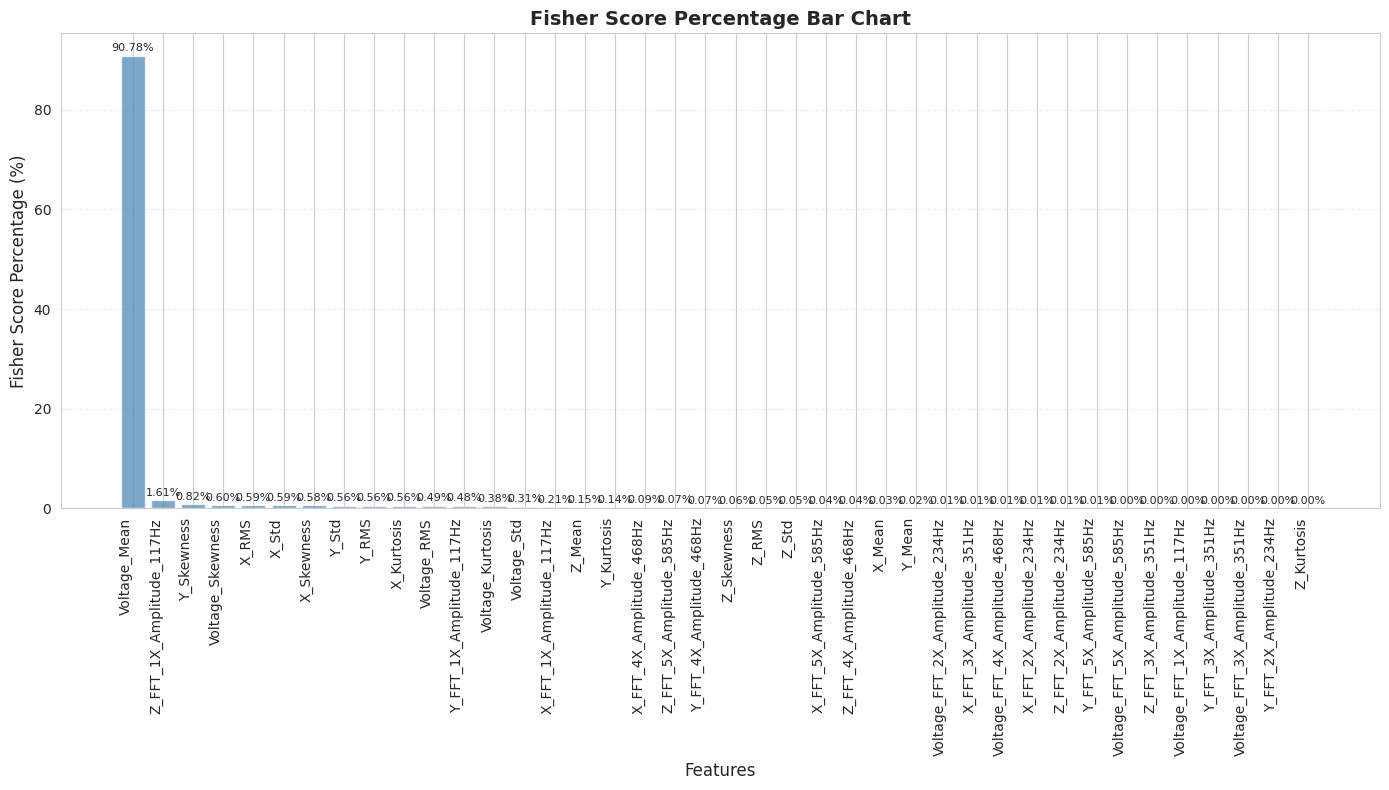


完成！


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 讀取合併後的數據
input_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Combined_Features_Df.csv"
df = pd.read_csv(input_path)

print(f"原始數據: {len(df)} 行 x {len(df.columns)} 列")
print(f"\n前5行預覽:")
print(df.head())

# 分離Label和特徵
label_col = df['Label']
feature_cols = [col for col in df.columns if col != 'Label']
features_df = df[feature_cols]

print(f"\n特徵數量: {len(feature_cols)}")

# 計算訓練集的平均數和標準差（變異數的平方根）
train_mean = features_df.mean()
train_std = features_df.std()
train_variance = features_df.var()

print(f"\n訓練集統計資訊:")
print(f"\n平均數 (Mean):")
print(train_mean)
print(f"\n變異數 (Variance):")
print(train_variance)
print(f"\n標準差 (Std):")
print(train_std)

# 進行Z-score標準化: z = (x - mean) / std
print("\n" + "="*50)
print("進行Z-score標準化...")
print("="*50)

features_normalized = (features_df - train_mean) / train_std

# 合併Label和標準化後的特徵
normalized_df = pd.concat([label_col, features_normalized], axis=1)

# 將Label列移到最前面
cols_normalized = ['Label'] + [col for col in normalized_df.columns if col != 'Label']
normalized_df = normalized_df[cols_normalized]

print(f"\n標準化後的表格: {len(normalized_df)} 行 x {len(normalized_df.columns)} 列")

# 顯示標準化後的統計資訊
print(f"\n標準化後的特徵統計（應該接近均值0和標準差1）:")
print(features_normalized.describe())

# 顯示前幾行
print("\n標準化後的前5行預覽:")
print(normalized_df.head())

# 保存標準化後的數據
normalized_output_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Combined_Features_Df_Normalized.csv"
normalized_df.to_csv(normalized_output_path, index=False)
print(f"\n標準化後的數據已保存到: {normalized_output_path}")

# 保存統計資訊
stats_output_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Normalization_Stats.csv"
stats_df = pd.DataFrame({
    'Feature': train_mean.index,
    'Mean': train_mean.values,
    'Variance': train_variance.values,
    'Std': train_std.values
})
stats_df.to_csv(stats_output_path, index=False)
print(f"標準化統計資訊已保存到: {stats_output_path}")

# 計算費雪分數 (Fisher Score)
print("\n" + "="*50)
print("計算費雪分數...")
print("="*50)

# 分離兩個類別
class_0 = normalized_df[normalized_df['Label'] == 0][feature_cols]  # Healthy
class_1 = normalized_df[normalized_df['Label'] == 1][feature_cols]  # Faulty

# 計算每個類別的平均值和變異數
mean_0 = class_0.mean()
mean_1 = class_1.mean()
var_0 = class_0.var()
var_1 = class_1.var()

# 費雪分數: F = (mean_1 - mean_0)^2 / (var_0 + var_1 + epsilon)
# 添加小值避免除以0
epsilon = 1e-8
fisher_scores = ((mean_1 - mean_0) ** 2) / (var_0 + var_1 + epsilon)

# 計算百分比（每個特徵的費雪分數占總和的比例）
fisher_total = fisher_scores.sum()
fisher_percentages = (fisher_scores / fisher_total) * 100

# 創建DataFrame方便查看
fisher_df = pd.DataFrame({
    'Feature': fisher_scores.index,
    'Fisher_Score': fisher_scores.values,
    'Percentage': fisher_percentages.values
}).sort_values('Fisher_Score', ascending=False)

print(f"\n費雪分數統計（按分數降序排列）:")
print(fisher_df)

# 保存費雪分數結果
fisher_output_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Fisher_Scores.csv"
fisher_df.to_csv(fisher_output_path, index=False)
print(f"\n費雪分數已保存到: {fisher_output_path}")

# 用matplotlib畫出百分比的柱狀圖
plt.figure(figsize=(14, 8))
plt.bar(range(len(fisher_df)), fisher_df['Percentage'], color='steelblue', alpha=0.7)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Fisher Score Percentage (%)', fontsize=12)
plt.title('Fisher Score Percentage Bar Chart', fontsize=14, fontweight='bold')
plt.xticks(range(len(fisher_df)), fisher_df['Feature'], rotation=90, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# 在每個柱子上顯示百分比數值
for i, v in enumerate(fisher_df['Percentage']):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontsize=8)

# 保存圖表
chart_output_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Fisher_Score_Chart.png"
plt.savefig(chart_output_path, dpi=300, bbox_inches='tight')
print(f"\n費雪分數柱狀圖已保存到: {chart_output_path}")

# 顯示圖表
plt.show()

print("\n完成！")



#Step4_Train_LR_Model

# 邏輯回歸模型訓練 ok


邏輯回歸訓練 - 使用費雪分數選取的特徵

使用前 2 名特徵進行邏輯回歸訓練

選取的特徵: ['Voltage_Mean', 'Z_FFT_1X_Amplitude_117Hz']

使用所有數據進行訓練: 96 樣本

模型評估指標:
準確率 (Accuracy): 1.0000 (100.00%)
精確率 (Precision): 1.0000 (100.00%)
召回率 (Recall): 1.0000 (100.00%)
F1 Score: 1.0000 (100.00%)

分類報告:
              precision    recall  f1-score   support

 Healthy (0)       1.00      1.00      1.00        48
  Faulty (1)       1.00      1.00      1.00        48

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

模型已保存到: /content/drive/MyDrive/ML_MY_Project_FCUT/model/LogisticRegression_Top2.pkl
預測機率圖已保存到: /content/drive/MyDrive/ML_MY_Project_FCUT/fig/Prediction_Probability_Top2.png
預測機率數據已保存到: /content/drive/MyDrive/ML_MY_Project_FCUT/fig/Prediction_Probabilities_Top2.csv

使用前 3 名特徵進行邏輯回歸訓練

選取的特徵: ['Voltage_Mean', 'Z_FFT_1X_Amplitude_117Hz', 'Y_Skewness']

使用所有數據進行訓練: 96 樣本

模型評估指標:
準確率 (Accuracy): 1.0000 (100.00%)
精確率 (Pre

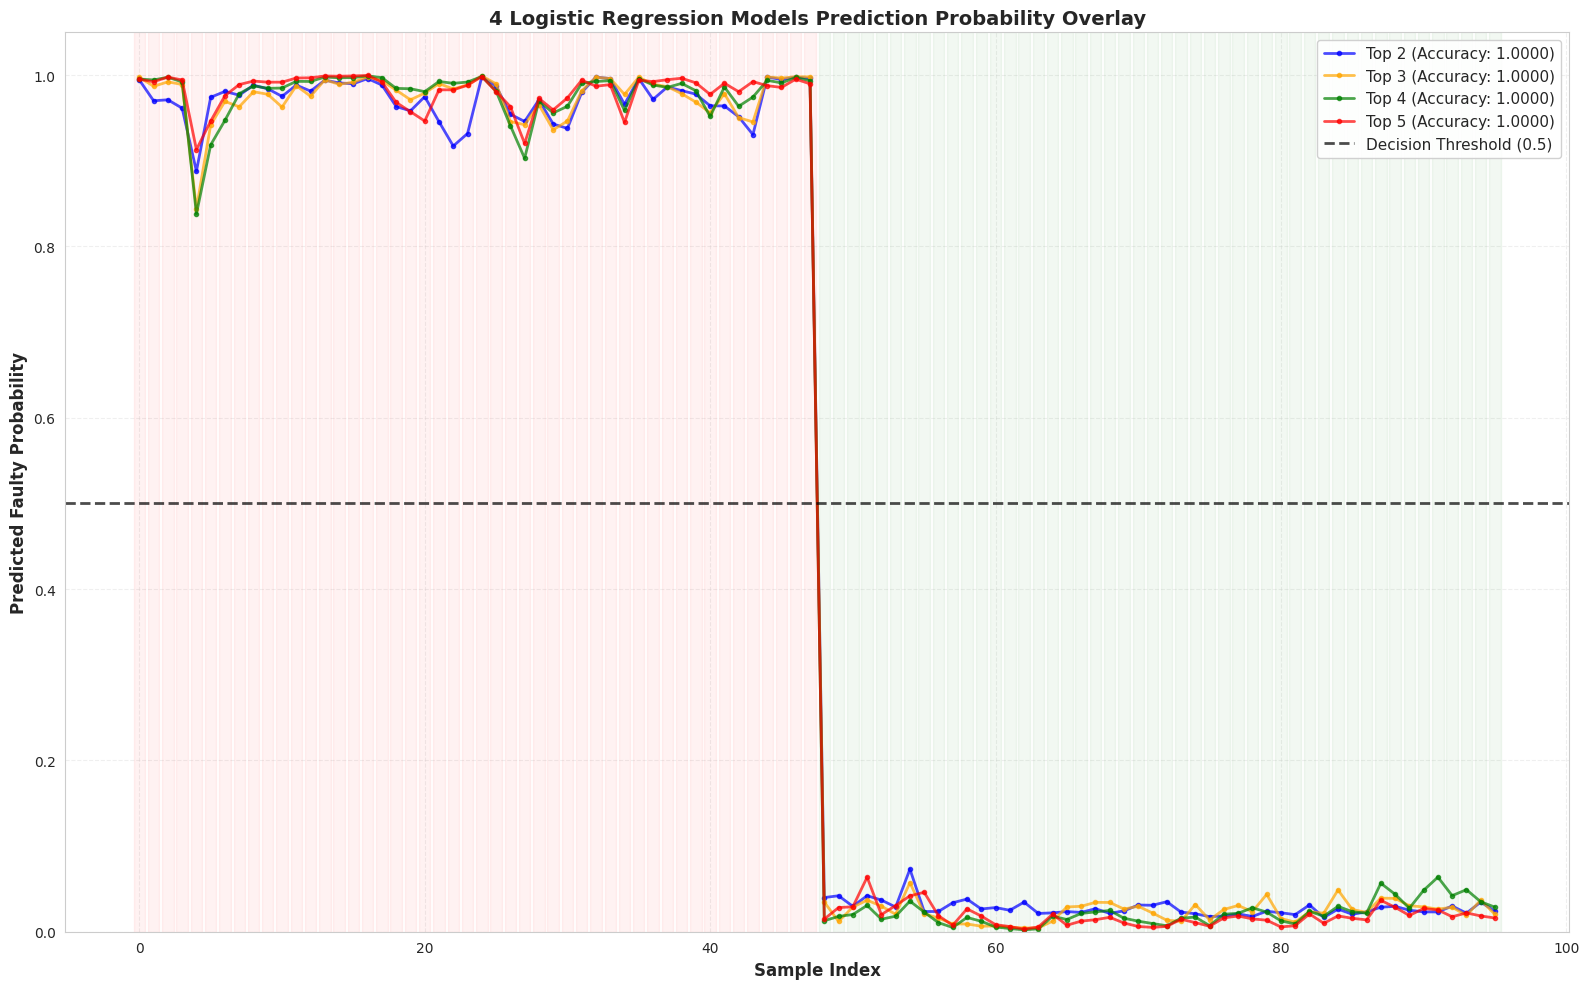


完成！


In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import joblib
import os

# 讀取費雪分數數據
fisher_scores_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Fisher_Scores.csv"
fisher_df = pd.read_csv(fisher_scores_path)

# 讀取標準化後的數據
data_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Combined_Features_Df_Normalized.csv"
df = pd.read_csv(data_path)

# 創建保存目錄（如果不存在）
fig_dir = "/content/drive/MyDrive/ML_MY_Project_FCUT/fig"
model_dir = "/content/drive/MyDrive/ML_MY_Project_FCUT/model"
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

print("="*60)
print("邏輯回歸訓練 - 使用費雪分數選取的特徵")
print("="*60)

# 分離Label和特徵
y = df['Label']
X_all = df.drop(columns=['Label'])

# 按費雪分數排序，獲取前N名特徵
fisher_df_sorted = fisher_df.sort_values('Fisher_Score', ascending=False)

# 定義要測試的特徵數量
top_n_list = [2, 3, 4, 5]

results = []
all_proba_dict = {}  # 儲存所有模型的預測機率

for top_n in top_n_list:
    print(f"\n{'='*60}")
    print(f"使用前 {top_n} 名特徵進行邏輯回歸訓練")
    print(f"{'='*60}")

    # 獲取前N名特徵名稱
    top_features = fisher_df_sorted.head(top_n)['Feature'].tolist()
    print(f"\n選取的特徵: {top_features}")

    # 選取對應的特徵
    X = X_all[top_features]

    # 使用所有數據進行訓練（不切割）
    print(f"\n使用所有數據進行訓練: {X.shape[0]} 樣本")

    # 創建並訓練邏輯回歸模型
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X, y)

    # 預測
    y_pred = lr_model.predict(X)

    # 計算評估指標
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    print(f"\n模型評估指標:")
    print(f"準確率 (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"精確率 (Precision): {precision:.4f} ({precision*100:.2f}%)")
    print(f"召回率 (Recall): {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1 Score: {f1:.4f} ({f1*100:.2f}%)")

    # 分類報告
    print(f"\n分類報告:")
    print(classification_report(y, y_pred, target_names=['Healthy (0)', 'Faulty (1)']))

    # 保存結果
    results.append({
        'Top_N': top_n,
        'Features': ', '.join(top_features),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Feature_Count': top_n
    })

    # 預測所有數據的機率並繪圖
    y_proba_all = lr_model.predict_proba(X)[:, 1]  # 故障機率

    # 保存預測機率到字典中（用於最後的疊加圖）
    all_proba_dict[f'Top_{top_n}'] = y_proba_all
    all_proba_dict[f'Top_{top_n}_Accuracy'] = accuracy

    # 創建包含索引、真實標籤和預測機率的DataFrame
    proba_df = pd.DataFrame({
        'Index': range(len(df)),
        'True_Label': y.values,
        'Predicted_Probability': y_proba_all
    })

    # 繪製預測機率圖
    fig, ax = plt.subplots(figsize=(16, 8))

    # 分離健康和故障樣本
    healthy_indices = proba_df[proba_df['True_Label'] == 0]['Index']
    healthy_proba = proba_df[proba_df['True_Label'] == 0]['Predicted_Probability']
    faulty_indices = proba_df[proba_df['True_Label'] == 1]['Index']
    faulty_proba = proba_df[proba_df['True_Label'] == 1]['Predicted_Probability']

    # 繪製散點圖，用不同顏色標識真實標籤
    ax.scatter(healthy_indices, healthy_proba,
              label='Healthy', color='green', alpha=0.6, s=50)
    ax.scatter(faulty_indices, faulty_proba,
              label='Faulty', color='red', alpha=0.6, s=50)

    # 添加決策閾值線（通常為0.5）
    ax.axhline(y=0.5, color='blue', linestyle='--', linewidth=2,
              label='Decision Threshold (0.5)', alpha=0.7)

    # 設置標籤和標題
    ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Faulty Probability', fontsize=12, fontweight='bold')
    ax.set_title(f'Logistic Regression Prediction Probability - Top {top_n} Features (Accuracy: {accuracy:.4f})',
                 fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()

    # 保存模型
    model_output_path = f"{model_dir}/LogisticRegression_Top{top_n}.pkl"
    joblib.dump(lr_model, model_output_path)
    print(f"模型已保存到: {model_output_path}")

    # 保存機率圖
    proba_output_path = f"{fig_dir}/Prediction_Probability_Top{top_n}.png"
    plt.savefig(proba_output_path, dpi=300, bbox_inches='tight')
    print(f"預測機率圖已保存到: {proba_output_path}")

    # 保存機率數據
    proba_data_output_path = f"{fig_dir}/Prediction_Probabilities_Top{top_n}.csv"
    proba_df.to_csv(proba_data_output_path, index=False)
    print(f"預測機率數據已保存到: {proba_data_output_path}")

    plt.close()

# 創建結果比較表
results_df = pd.DataFrame(results)
print(f"\n{'='*60}")
print("所有模型結果比較")
print(f"{'='*60}")
print(results_df[['Top_N', 'Accuracy', 'Precision', 'Recall', 'F1_Score']].to_string(index=False))

# 保存結果比較表
results_output_path = f"{fig_dir}/Logistic_Regression_Results.csv"
results_df.to_csv(results_output_path, index=False)
print(f"\n結果比較表已保存到: {results_output_path}")

# 繪製準確率比較圖
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(top_n_list))

plt.bar(x_pos, results_df['Accuracy'], width=0.6,
        label='Accuracy', color='steelblue', alpha=0.8)

plt.xlabel('Number of Features (Top N)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Logistic Regression Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xticks(x_pos, [f'Top {n}' for n in top_n_list])
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# 在柱子上顯示數值
for i, acc in enumerate(results_df['Accuracy']):
    plt.text(i, acc + 0.01, f'{acc:.3f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
comparison_output_path = f"{fig_dir}/Accuracy_Comparison.png"
plt.savefig(comparison_output_path, dpi=300, bbox_inches='tight')
print(f"\n準確率比較圖已保存到: {comparison_output_path}")
plt.close()

print("\n" + "="*60)
print("所有模型的預測機率圖已生成完成")
print("="*60)

# 繪製4種模型的疊加圖
print("\n" + "="*60)
print("繪製4種模型的疊加圖")
print("="*60)

fig, ax = plt.subplots(figsize=(16, 10))

# 定義4種模型的顏色
colors = {
    'Top_2': 'blue',
    'Top_3': 'orange',
    'Top_4': 'green',
    'Top_5': 'red'
}

# 樣本索引
sample_indices = range(len(df))

# 繪製每個模型的預測機率線
for top_n_key in ['Top_2', 'Top_3', 'Top_4', 'Top_5']:
    if top_n_key in all_proba_dict:
        proba = all_proba_dict[top_n_key]
        acc = all_proba_dict[f'{top_n_key}_Accuracy']
        color = colors[top_n_key]
        label = f'{top_n_key.replace("_", " ")} (Accuracy: {acc:.4f})'
        ax.plot(sample_indices, proba, label=label, color=color,
               linewidth=2, alpha=0.7, marker='o', markersize=3)

# 添加決策閾值線
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2,
          label='Decision Threshold (0.5)', alpha=0.7)

# 標記真實標籤區域（可選：用背景色區分）
for i, label in enumerate(y):
    if label == 0:  # Healthy
        ax.axvspan(i-0.4, i+0.4, alpha=0.05, color='green')
    else:  # Faulty
        ax.axvspan(i-0.4, i+0.4, alpha=0.05, color='red')

# 設置標籤和標題
ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Faulty Probability', fontsize=12, fontweight='bold')
ax.set_title('4 Logistic Regression Models Prediction Probability Overlay', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.05])
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()

# 保存疊加圖
overlay_output_path = f"{fig_dir}/Prediction_Probability_Overlay.png"
plt.savefig(overlay_output_path, dpi=300, bbox_inches='tight')
print(f"\n4種模型疊加圖已保存到: {overlay_output_path}")

plt.show()
plt.close()

print("\n完成！")



#SVM模型訓練OK

SVM模型訓練 - 使用費雪分數前2名特徵

選取的前2名特徵: ['Voltage_Mean', 'Z_FFT_1X_Amplitude_117Hz']

使用所有數據進行訓練: 96 樣本

訓練SVM模型（線性核函數）...

模型準確率: 1.0000 (100.00%)

分類報告:
              precision    recall  f1-score   support

 Healthy (0)       1.00      1.00      1.00        48
  Faulty (1)       1.00      1.00      1.00        48

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96


SVM模型已保存到: /content/drive/MyDrive/ML_MY_Project_FCUT/model/LR_Model.mat

繪製支援向量和決策邊界

支援向量數量: 2
支援向量索引: [54  4]...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3341934376.py:156: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, Z_decision, levels=[-1, 1], colors='blue',



決策邊界圖已保存到: /content/drive/MyDrive/ML_MY_Project_FCUT/fig/SVM_Decision_Boundary.png


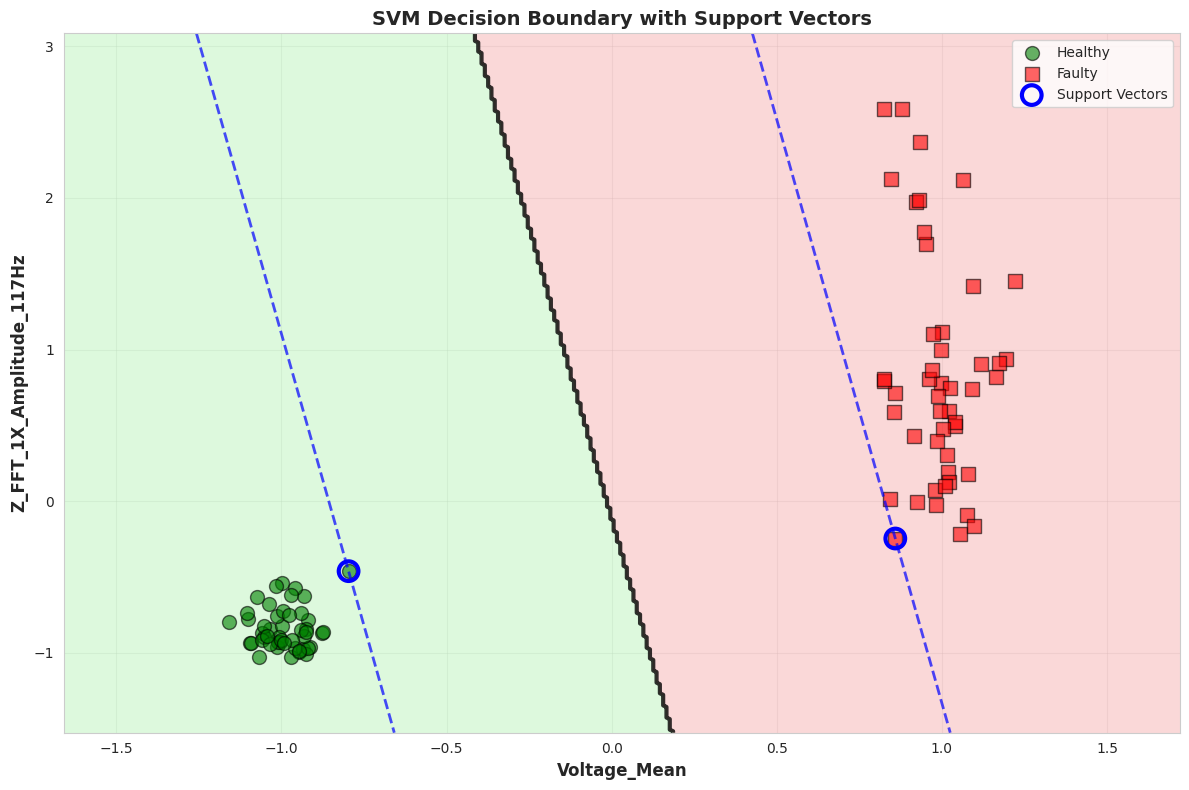


SVM模型訓練完成！


In [60]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import scipy.io
import os

# ============================================================================
# SVM模型訓練 - 使用前2名特徵
# ============================================================================
print("="*60)
print("SVM模型訓練 - 使用費雪分數前2名特徵")
print("="*60)

# 讀取費雪分數數據
fisher_scores_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Fisher_Scores.csv"
fisher_df = pd.read_csv(fisher_scores_path)

# 讀取標準化後的數據
data_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/data/Clean_Data/Combined_Features_Df_Normalized.csv"
df = pd.read_csv(data_path)

# 創建保存目錄（如果不存在）
fig_dir = "/content/drive/MyDrive/ML_MY_Project_FCUT/fig"
model_dir = "/content/drive/MyDrive/ML_MY_Project_FCUT/model"
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# 分離Label和特徵
y = df['Label']
X_all = df.drop(columns=['Label'])

# 按費雪分數排序，獲取前2名特徵
fisher_df_sorted = fisher_df.sort_values('Fisher_Score', ascending=False)
top_features = fisher_df_sorted.head(2)['Feature'].tolist()

print(f"\n選取的前2名特徵: {top_features}")

# 選取對應的特徵
X = X_all[top_features]

# 使用所有數據進行訓練（不切割）
print(f"\n使用所有數據進行訓練: {X.shape[0]} 樣本")

# 創建並訓練SVM模型（使用線性核函數）
print("\n訓練SVM模型（線性核函數）...")
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X, y)

# 預測
y_pred = svm_model.predict(X)

# 計算準確率
accuracy = accuracy_score(y, y_pred)

print(f"\n模型準確率: {accuracy:.4f} ({accuracy*100:.2f}%)")

# 分類報告
print(f"\n分類報告:")
print(classification_report(y, y_pred, target_names=['Healthy (0)', 'Faulty (1)']))

# 保存SVM模型為.mat格式
model_output_path = "/content/drive/MyDrive/ML_MY_Project_FCUT/model/LR_Model.mat"
# 提取模型參數
model_dict = {
    'coef': svm_model.coef_,
    'intercept': svm_model.intercept_,
    'support_vectors': svm_model.support_vectors_,
    'support': svm_model.support_,
    'n_support': svm_model.n_support_,
    'classes': svm_model.classes_,
    'feature_names': np.array(top_features, dtype=object)
}
scipy.io.savemat(model_output_path, model_dict)
print(f"\nSVM模型已保存到: {model_output_path}")

# 繪製支援向量和決策邊界
print("\n" + "="*60)
print("繪製支援向量和決策邊界")
print("="*60)

# 獲取支援向量
support_vectors = svm_model.support_vectors_
support_vector_indices = svm_model.support_

print(f"\n支援向量數量: {len(support_vectors)}")
print(f"支援向量索引: {support_vector_indices[:10]}...")  # 顯示前10個

# 創建2D網格來繪製決策邊界
feature1 = top_features[0]
feature2 = top_features[1] if len(top_features) > 1 else top_features[0]

# 獲取特徵的範圍
x_min, x_max = X[feature1].min() - 0.5, X[feature1].max() + 0.5
y_min, y_max = X[feature2].min() - 0.5, X[feature2].max() + 0.5

# 創建網格
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# 預測網格點的類別
if len(top_features) == 2:
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = svm_model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # 預測機率（用於繪製機率等高線）
    Z_proba = svm_model.predict_proba(grid_points)[:, 1]
    Z_proba = Z_proba.reshape(xx.shape)
else:
    # 如果只有一個特徵，需要特殊處理
    grid_points = np.c_[xx.ravel(), np.zeros(xx.size)]
    Z = svm_model.predict(X)
    Z_proba = svm_model.predict_proba(X)[:, 1]

# 繪製決策邊界圖
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# 繪製決策邊界（使用背景顏色區分區域）
if len(top_features) == 2:
    # 創建兩個區域的遮罩
    Z_healthy = (Z == 0).astype(float)
    Z_faulty = (Z == 1).astype(float)

    # 繪製背景區域（使用顏色填充）
    ax.contourf(xx, yy, Z_healthy, levels=[0.5, 1.5],
                colors=['lightgreen'], alpha=0.3)
    ax.contourf(xx, yy, Z_faulty, levels=[0.5, 1.5],
                colors=['lightcoral'], alpha=0.3)

    # 繪製決策邊界線（實線）
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=3, linestyles='-', alpha=0.8)

    # 繪製數據點
    ax.scatter(X[y == 0][feature1],
              X[y == 0][feature2],
              c='green', marker='o', s=100,
              label='Healthy', alpha=0.6, edgecolors='black', linewidths=1)
    ax.scatter(X[y == 1][feature1],
              X[y == 1][feature2],
              c='red', marker='s', s=100,
              label='Faulty', alpha=0.6, edgecolors='black', linewidths=1)

    # 繪製支援向量
    support_vectors_data = X.iloc[support_vector_indices]
    ax.scatter(support_vectors_data[feature1],
              support_vectors_data[feature2],
              s=200, facecolors='none', edgecolors='blue',
              linewidths=3, label='Support Vectors', marker='o', zorder=10)

    # 繪製支援向量的邊界線（使用決策函數的等高線）
    Z_decision = svm_model.decision_function(grid_points).reshape(xx.shape)
    # 繪製通過支援向量的虛線（決策函數值為±1的線）
    ax.contour(xx, yy, Z_decision, levels=[-1, 1], colors='blue',
              linewidths=2, linestyles='--', alpha=0.7, label='Support Vector Margins')

    ax.set_xlabel(feature1, fontsize=12, fontweight='bold')
    ax.set_ylabel(feature2, fontsize=12, fontweight='bold')
else:
    # 單特徵情況
    ax.scatter(X[y == 0][feature1],
              np.zeros(len(X[y == 0])),
              c='green', marker='o', s=100,
              label='Healthy', alpha=0.6)
    ax.scatter(X[y == 1][feature1],
              np.zeros(len(X[y == 1])),
              c='red', marker='s', s=100,
              label='Faulty', alpha=0.6)
    ax.set_xlabel(feature1, fontsize=12, fontweight='bold')
    ax.set_ylabel('', fontsize=12)

ax.set_title('SVM Decision Boundary with Support Vectors', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()

# 保存決策邊界圖
decision_boundary_output_path = f"{fig_dir}/SVM_Decision_Boundary.png"
plt.savefig(decision_boundary_output_path, dpi=300, bbox_inches='tight')
print(f"\n決策邊界圖已保存到: {decision_boundary_output_path}")

plt.show()
plt.close()

print("\nSVM模型訓練完成！")
